In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
import random
import time
from random import randint
import datetime
import random
import tqdm
from tqdm.notebook import tqdm_notebook
import math
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge, Lasso
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
time_now = str(datetime.datetime.now().date())
time_start = "2010-06-30"
time_end = '2022-07-17'

stocks = ['GC=F', 'SI=F', 'HG=F', 'CL=F', 'BZ=F', 'NG=F', 'ZC=F', 'ZO=F', 'KE=F', 'ZR=F'] 

GCF_trading_data = yf.download("GC=F", start=time_start, end=time_end)
SIF_trading_data = yf.download("SI=F", start=time_start, end=time_end)
HGF_trading_data = yf.download("HG=F", start=time_start, end=time_end)
CLF_trading_data = yf.download("CL=F", start=time_start, end=time_end)
BZF_trading_data = yf.download("BZ=F", start=time_start, end=time_end)
NGF_trading_data = yf.download("NG=F", start=time_start, end=time_end)
ZCF_trading_data = yf.download("ZC=F", start=time_start, end=time_end)
ZOF_trading_data = yf.download("ZO=F", start=time_start, end=time_end)
KEF_trading_data = yf.download("KE=F", start=time_start, end=time_end)
ZRF_trading_data = yf.download("ZR=F", start=time_start, end=time_end)

trading_datas = [GCF_trading_data, 
                 SIF_trading_data, 
                 HGF_trading_data, 
                 CLF_trading_data, 
                 BZF_trading_data, 
                 NGF_trading_data, 
                 ZCF_trading_data, 
                 ZOF_trading_data, 
                 KEF_trading_data, 
                 ZRF_trading_data
                ]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False) 
    percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent']).sort_values('Total', ascending=False)
    return missing_data

for stk, data in zip(stocks, trading_datas):
    print (stk)
    print ('Starting Date: ',data.index[0])
    print ('Ending Date: ',data.index[-1])
    print (missing_data(data))
    print ()

GC=F
Starting Date:  2010-06-29 00:00:00
Ending Date:  2022-07-15 00:00:00
           Total  Percent
Open           0      0.0
High           0      0.0
Low            0      0.0
Close          0      0.0
Adj Close      0      0.0
Volume         0      0.0

SI=F
Starting Date:  2010-06-29 00:00:00
Ending Date:  2022-07-15 00:00:00
           Total  Percent
Open           0      0.0
High           0      0.0
Low            0      0.0
Close          0      0.0
Adj Close      0      0.0
Volume         0      0.0

HG=F
Starting Date:  2010-06-29 00:00:00
Ending Date:  2022-07-15 00:00:00
           Total  Percent
Open           0      0.0
High           0      0.0
Low            0      0.0
Close          0      0.0
Adj Close      0      0.0
Volume         0      0.0

CL=F
Starting Date:  2010-06-29 00:00:00
Ending Date:  2022-07-15 00:00:00
           Total  Percent
Open           0      0.0
High           0      0.0
Low            0      0.0
Close          0      0.0
Adj Close      0     

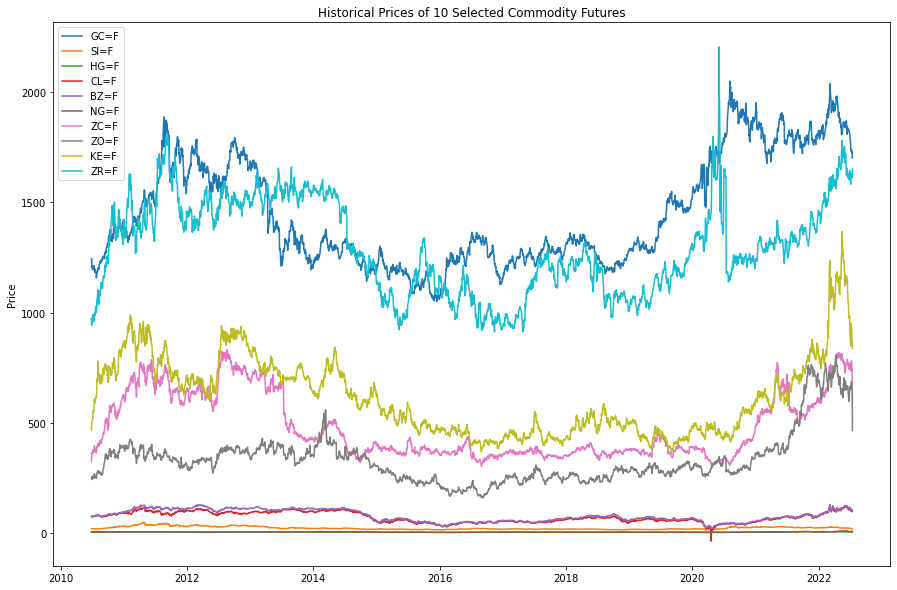

In [58]:
fig, ax = plt.subplots(figsize=(15,10))
for stk, data in zip(stocks, trading_datas):
    ax.plot(data.index.tolist(), data['Close'], label=stk)
    ax.set_ylabel('Price')
    ax.set_title('Historical Prices of 10 Selected Commodity Futures')
    ax.legend()

In [5]:
class Technical_Indicators(object):
    def __init__(self, stock_data, STD_periods, SMA_periods, SMA_envelope_range_percentage, EMA_period, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod, RSI_period, Stoch_periods, KDJ_periods):
        self.stock_data = stock_data
        self.STD_periods = STD_periods
        self.SMA_periods = SMA_periods
        self.SMA_envelope_range_percentage = SMA_envelope_range_percentage
        self.EMA_period = EMA_period
        self.MACD_shortPeriod = MACD_shortPeriod
        self.MACD_longPeriod = MACD_longPeriod
        self.MACD_signalPeriod = MACD_signalPeriod
        self.RSI_period = RSI_period
        self.Stoch_periods = Stoch_periods
        self.KDJ_periods = KDJ_periods
    
    def calculate_OC(self, stock_data):
        open_close = stock_data['Open'] - stock_data['Close']
        return open_close
    
    def calculate_HL(self, stock_data):
        hogh_low = stock_data['High'] - stock_data['Low']
        return hogh_low
    
    def calculate_std(self, close, days):
        standard_deviations = round(close.rolling(window = int(days)).std(), 4)
        return standard_deviations
    
    def calculate_SMA(self, close, days):
        simple_moving_averages = round(close.rolling(window = int(days)).mean(), 4)
        return simple_moving_averages
    
    def calculate_SMA_envelope(self, close, period, range_percentage):
        sma = self.calculate_SMA(close, period)
        up = sma*(1 + range_percentage * 0.01)
        down = sma*(1 - range_percentage * 0.01)
        return up, down
    
    def calculate_EMA(self, close, days):
        exponential_moving_averages = round(close.ewm(span = int(days), adjust = False, min_periods=days).mean(), 4)
        return exponential_moving_averages
    
    def calculate_MACD(self, close, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod):
        ema_short = self.calculate_EMA(close, self.MACD_shortPeriod)
        ema_long = self.calculate_EMA(close, self.MACD_longPeriod)
        macd = pd.Series(ema_short)-pd.Series(ema_long)
        signal = round(macd.ewm(span=self.MACD_signalPeriod, adjust=False, min_periods=self.MACD_signalPeriod).mean(), 4)
        macd_hist = round(macd - signal, 4)
        return macd, signal, macd_hist
    
    def calculate_RSI(self, close, period):
        diff = close.diff()
        diff = diff[1:]
        gain, loss = diff.clip(lower=0), abs(diff.clip(upper=0))
        gain_avg , loss_avg = round(gain.ewm(com = period - 1, adjust=True, min_periods = period).mean(), 4), round(loss.ewm(com = period - 1, adjust=True, min_periods = period).mean(), 4)
        rs = gain_avg/loss_avg
        rsi =100 - (100/(1 + rs))
        return rsi
    
    def calculate_StochRSI(self, close, periods):
        rsi_period = periods[0]
        stc_period = periods[1]
        stk_period = periods[2]
        std_period = periods[3]
        rsi = self.calculate_RSI(close, rsi_period)
        rsi = rsi.dropna(axis=0)
        min_rsi = rsi.rolling(window = int(stc_period)).min()
        max_rsi = rsi.rolling(window = int(stc_period)).max()
        stochrsi = 100 * ((rsi - min_rsi)/(max_rsi - min_rsi))
        stk = stochrsi.rolling(window = int(stk_period)).max()
        std = stk.rolling(window = int(std_period)).min()
        return stk, std
    
    def calculate_kdj(self, stock_data, periods):
        lows = stock_data['Low'].rolling(periods[0]).min()
        lows.fillna(value = stock_data['Low'].expanding().min(), inplace = True)
        highs = stock_data['High'].rolling(periods[1]).max()
        highs.fillna(value = stock_data['High'].expanding().max(), inplace = True)
        rsv = (stock_data['Close'] - lows) / (highs - lows) * 100
        kdj_data = pd.DataFrame(columns=['K','D','J'])
        kdj_data['K'] = rsv.ewm(com=2).mean()
        kdj_data['D'] = kdj_data['K'].ewm(com=2).mean().tolist()
        kdj_data['J'] = 3 * kdj_data['K'] - 2 * kdj_data['D']
        return kdj_data

    def main(self):
        df_results = stock_data
        df_results['OC'] = self.calculate_OC(stock_data)
        df_results['HL'] = self.calculate_HL(stock_data)
        
        for period in self.STD_periods:
            STD_name = 'STD'+str(period)
            df_results[STD_name] = self.calculate_std(stock_data['Close'], period)
            
        for period in self.SMA_periods:
            SMA_name = 'SMA'+str(period)
            df_results[SMA_name] = self.calculate_SMA(stock_data['Close'], period)
            
            SMA_envelope_name = 'SMA_'+str(period)+'_'+str(self.SMA_envelope_range_percentage)
            #print (SMA_envelope_name)
            df_results[SMA_envelope_name+'up']= self.calculate_SMA_envelope(stock_data['Close'], period, self.SMA_envelope_range_percentage)[0]
            df_results[SMA_envelope_name+'down']= self.calculate_SMA_envelope(stock_data['Close'], period, self.SMA_envelope_range_percentage)[1]
        
        df_results['EMA'] = self.calculate_EMA(stock_data['Close'], self.EMA_period)
        
        MACD = self.calculate_MACD(stock_data['Close'], self.MACD_shortPeriod, self.MACD_longPeriod, self.MACD_signalPeriod)
        df_results['MACD'] = MACD[0]
        df_results['MACD_Signal'] = MACD[1]
        df_results['MACD_Hist'] = MACD[2]
        
        df_results['RSI'] = self.calculate_RSI(stock_data['Close'], self.RSI_period)
        stoch_rsi = self.calculate_StochRSI(stock_data['Close'], self.Stoch_periods)
        df_results['Stoch_RSI_K'] = stoch_rsi[0]
        df_results['Stoch_RSI_D'] = stoch_rsi[1]
        
        kdj = self.calculate_kdj(stock_data, self.KDJ_periods)
        df_results['K'] = kdj['K']
        df_results['D'] = kdj['D']
        df_results['J'] = kdj['J']
        
        return df_results


    

## Initial Predictions

In [17]:
stock_names = []
mdl_names = []
r2s = []
mses = []
maes = []
mapes = []
run_times = []
df_pred_results = pd.DataFrame(columns=['Commodity'])
for stk, data in zip(stocks, trading_datas):
    #print (stk)
    if __name__ == '__main__':
        stock_data = data
        STD_periods = [7]
        SMA_periods = [7, 14, 30, 50]
        SMA_envelope_range_percentage = 5
        EMA_period = 8
        MACD_shortPeriod = 12
        MACD_longPeriod = 26
        MACD_signalPeriod = 9
        RSI_period = 14
        Stoch_periods = [14, 14, 14, 14] #RSI, StochRSI, %K(max), %D(min)
        KDJ_periods = [14, 14]

        tis = Technical_Indicators(stock_data, STD_periods, SMA_periods, SMA_envelope_range_percentage, EMA_period, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod, RSI_period, Stoch_periods, KDJ_periods)
        stock_results = tis.main()
        result_names = str(stk)
        df_technical_data = stock_results.dropna(axis=0)
        
        #df_technical_data = df_technical_data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
        

    prediction_days = 50
    future_days = 30
    df_data = pd.DataFrame(columns=['Close'], index = df_technical_data.tail(df_technical_data.shape[0]).index[prediction_days:len(df_technical_data)].tolist())

    for col in df_technical_data.columns: #,'SMA','MACD_Signal','RSI' 
        #print (col)
        
        #df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
        #col_nam = str(col)+str('-1')
        #df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
        if col == 'Close':
            df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
            
            prediction_day = 7
            for index_init in range(prediction_day):
                rolling_data = df_technical_data.iloc[index_init: index_init+(len(df_technical_data[col]) - prediction_days),:][col].tolist()
                col_name = str(col)+str(index_init-prediction_day)
                df_data[col_name] = rolling_data
            '''
        elif col == 'Open':
            df_data['Open'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Open'].tolist()
            '''
        else:
            col_nam = str(col)+str('-1')
            df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
    
    
    XGB = XGBRegressor()#num_boost_round=v1, eta=v2, max_depth=v3, gamma=v4,#early_stopping_rounds=20)
    RFR = RandomForestRegressor()
    #SGD = SGDRegressor()
    BYR = BayesianRidge()
    #LAS = Lasso()
    #SVR = svm.SVR(kernel="poly")

    models = [XGB, 
              RFR,
              #SVR,
              #SGD,
              BYR,
              #LAS
             ]
    model_names = ['XGBoost', 
                   'RandomForestRegressor',
                   #'SupportVectorRegressor',
                   #'SGDRegressor',
                   'BayesianRidge',
                   #'Lasso'
                  ]
    
    time_set_num = 20
    data_length = len(df_data)
    
    for model, mdl_name in zip(models, model_names):
        if mdl_name == 'SGDRegressor':
            SGD_pipline = make_pipeline(StandardScaler(),
                                        SGDRegressor(max_iter=1000, tol=1e-3)
                                       )
            model = SGD_pipline
            
        for i in range(1, time_set_num+1):
            df_train_period = df_data.iloc[future_days*(i-1): data_length-future_days*(time_set_num-(i-1)), :]
            df_test_period = df_data.iloc[data_length-future_days*(time_set_num-(i-1)): data_length-future_days*(time_set_num-(i)), :]

            
            x_train = df_train_period[df_train_period.columns.drop('Close').tolist()]
            y_train = df_train_period['Close']
            x_test = df_test_period[df_test_period.columns.drop('Close').tolist()]
            y_test = df_test_period['Close']
            '''
            scaler = MinMaxScaler(feature_range=(0,1))
            scaled_train = df_train_period.copy()
            scaled_test = df_test_period.copy()
            for col in df_train_period.columns:
                scaled_train[col] = scaler.fit_transform(df_train_period[col].values.reshape(-1,1))
                scaled_test[col] = scaler.fit_transform(df_test_period[col].values.reshape(-1,1))
            
            x_train = scaled_train[scaled_train.columns.drop('Close').tolist()]
            y_train = scaled_train['Close']
            x_test = scaled_test[scaled_test.columns.drop('Close').tolist()]
            y_test = scaled_test['Close']
            '''
            
            mdlst = time.time()
            model.fit(x_train, y_train)
            predict_test = model.predict(x_test)
            mdled = time.time()
            r2_scr = r2_score(y_test, predict_test)
            mse = mean_squared_error(y_test, predict_test)
            mae = mean_absolute_error(y_test, predict_test)
            mape = mean_absolute_percentage_error(y_test, predict_test)
            '''
            print (mdl_name,"'s performances:")
            print (' R^2 Score', r2_scr)
            print (' Mean Squared Error', mse)
            print (' Mean Absolute Error', mae)
            print (' Mean Absolute Percentage Error', mape)
            '''
            mdl_names.append(mdl_name)
            stock_names.append(stk)
            r2s.append(r2_scr)
            mses.append(mse)
            maes.append(mae)
            mapes.append(mape)
            run_times.append(mdled-mdlst)
            #scr_name = str(i)+str()
            #df_pred_results[scr_name]
            '''
            fig, ax = plt.subplots(figsize=(20,12))
            #ax.plot(y_train.index.tolist(), y_train, label='train',)
            ax.plot(y_test.index.tolist(), y_test,'o-', label='test',)
            ax.plot(y_test.index.tolist(), predict_test, 'o-', label='predict')
            ax.set_title(str(mdl_name)+' '+str(future_days)+' days prediction on '+str(stk))
            ax.set_ylabel('Price')
            ax.legend()
            '''

df_pred_results['Model'] = mdl_names
df_pred_results['Commodity'] = stock_names
df_pred_results['R^2'] = r2s
df_pred_results['MSE'] = mses
df_pred_results['MAE'] = maes
df_pred_results['MAPE'] = mapes
df_pred_results['Running Time'] = run_times
stks = []
mdls = []
pd_r2s = []
pd_mse = []
pd_mae = []
pd_mape = []
pd_rt = []
for stk in df_pred_results['Commodity'].unique():
    df_pd_stk = df_pred_results[df_pred_results['Commodity']==stk]
    for mdl in df_pd_stk['Model'].unique():
        df_pd_mdl = df_pd_stk[df_pd_stk['Model']==mdl]
        stks.append(stk)
        mdls.append(mdl)
        pd_r2s.append(df_pd_mdl['R^2'].max())
        pd_mse.append(df_pd_mdl['MSE'].max())
        pd_mae.append(df_pd_mdl['MAE'].max())
        pd_mape.append(df_pd_mdl['MAPE'].max())
        pd_rt.append(df_pd_mdl['Running Time'].max())
df_pred_val_results = pd.DataFrame({'Commodity':stks,
                                    'Model':mdls,
                                    'R^2':pd_r2s,
                                    'MSE':pd_mse,
                                    'MAE':pd_mae,
                                    'MAPE':pd_mape,
                                    'Running Time':pd_rt
                                   }
                                  )
df_pred_val_results 

Commodity                  Model       R^2           MSE         MAE  \
0       GC=F                XGBoost  0.867649  31641.420516  146.260559   
1       GC=F  RandomForestRegressor  0.900803  21260.989908  121.331939   
2       GC=F          BayesianRidge  0.889586   1646.900034   30.755515   
3       SI=F                XGBoost  0.902986      2.882420    1.274228   
4       SI=F  RandomForestRegressor  0.900026      2.043185    1.099101   
5       SI=F          BayesianRidge  0.920910      1.415792    0.929019   
6       HG=F                XGBoost  0.879211      0.142213    0.281640   
7       HG=F  RandomForestRegressor  0.881459      0.098202    0.248058   
8       HG=F          BayesianRidge  0.940234      0.009208    0.078165   
9       CL=F                XGBoost  0.907985    144.382266    5.432182   
10      CL=F  RandomForestRegressor  0.903844    155.859806    5.894303   
11      CL=F          BayesianRidge  0.940413    156.129426    5.113919   
12      BZ=F                XGBoost  0.865068     50.490097    6.048260   
13      BZ=F  RandomForestRegressor  0.922408     79.675062    7.432877   
14      BZ=F          BayesianRidge  0.931511     30.231370    4.131597   
15      NG=F                XGBoost  0.941597      1.970874    1.209754   
16      NG=F  RandomForestRegressor  0.930458      1.368562    0.987539   
17      NG=F          BayesianRidge  0.925503      0.251653    0.368985   
18      ZC=F                XGBoost  0.931636   1548.337007   33.227234   
19      ZC=F  RandomForestRegressor  0.903148    789.207045   22.122667   
20      ZC=F          BayesianRidge  0.963003    723.188279   16.220336   
21      ZO=F                XGBoost  0.859725  22342.396846  135.989165   
22      ZO=F  RandomForestRegressor  0.935498  15535.068748  113.751167   
23      ZO=F          BayesianRidge  0.926677   1462.589999   18.519007   
24      KE=F                XGBoost  0.936673  10545.220790   77.630709   
25      KE=F  RandomForestRegressor  0.948654   9758.058768   76.338250   
26      KE=F          BayesianRidge  0.949047   1821.886560   32.012915   
27      ZR=F                XGBoost  0.786098  21369.083870  109.021126   
28      ZR=F  RandomForestRegressor  0.895975  19857.966500   93.089667   
29      ZR=F          BayesianRidge  0.929846  10044.084226   77.908349   

        MAPE  Running Time  
0   0.074296      2.199698  
1   0.061682      4.994734  
2   0.019152      0.096456  
3   0.055647      1.128652  
4   0.050754      6.842409  
5   0.037119      0.007881  
6   0.062841      1.002665  
7   0.060105      4.044176  
8   0.021015      0.009747  
9   0.270461      1.197861  
10  0.298617      4.123452  
11  0.261758      0.007368  
12  0.148226      1.001093  
13  0.175646      3.914951  
14  0.070053      0.006955  
15  0.146146      1.158739  
16  0.118864      4.025439  
17  0.055803      0.007824  
18  0.044028      0.952660  
19  0.028792      4.119996  
20  0.026075      0.016325  
21  0.215350      0.935156  
22  0.180214      3.964251  
23  0.032249      0.011227  
24  0.071927      0.953498  
25  0.071470      4.081088  
26  0.031467      0.009519  
27  0.066871      0.993749  
28  0.052455      4.076010  
29  0.046260      0.008567

In [31]:
df_pred_val_results.to_excel('Commodity_Validation.xlsx')

GC=F
SI=F
HG=F
CL=F
BZ=F
NG=F
ZC=F


<ipython-input-18-b7df4c38ab21>:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20,12))


ZO=F
KE=F
ZR=F
   Commodity                  Model       R^2          MSE        MAE  \
0       GC=F                XGBoost  0.829267   434.617595  15.607471   
1       GC=F  RandomForestRegressor  0.900940   252.166206  11.813237   
2       GC=F          BayesianRidge  0.890504   278.732056  12.400152   
3       SI=F                XGBoost  0.903009     0.156233   0.315810   
4       SI=F  RandomForestRegressor  0.895357     0.168559   0.352668   
5       SI=F          BayesianRidge  0.922763     0.124413   0.282942   
6       HG=F                XGBoost  0.919551     0.012394   0.085165   
7       HG=F  RandomForestRegressor  0.936503     0.009783   0.076432   
8       HG=F          BayesianRidge  0.950165     0.007678   0.068516   
9       CL=F                XGBoost  0.262098    51.315674   5.896842   
10      CL=F  RandomForestRegressor  0.741245    17.994514   3.656623   
11      CL=F          BayesianRidge  0.807944    13.356101   2.669014   
12      BZ=F                XGBoost 

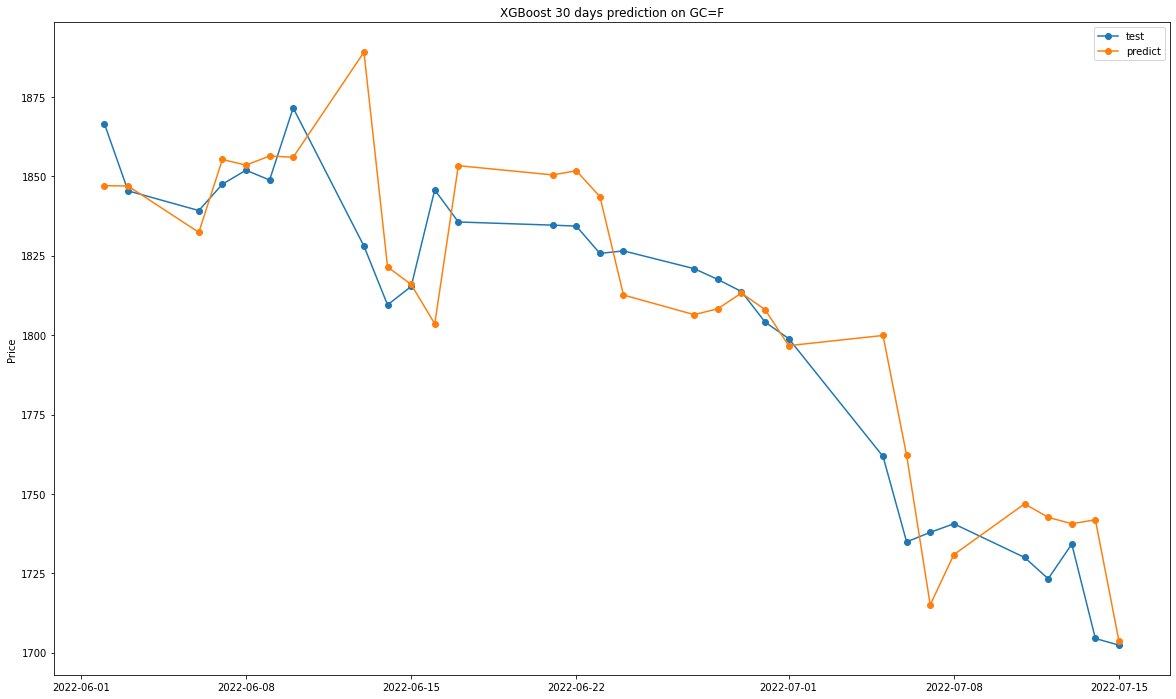

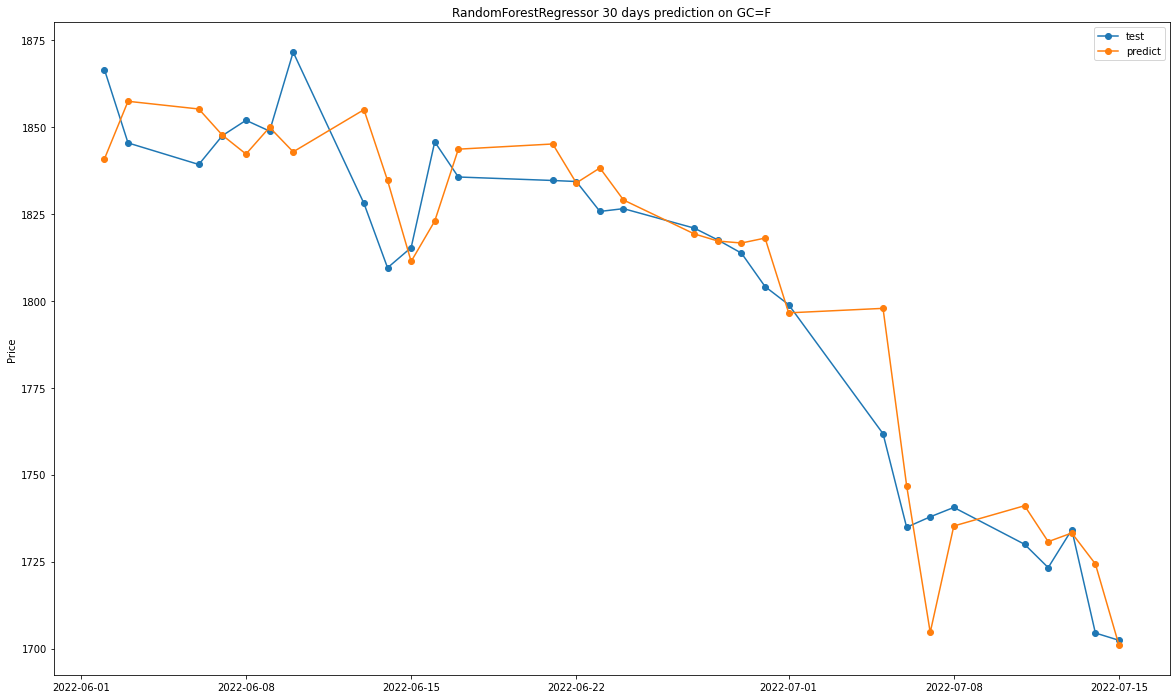

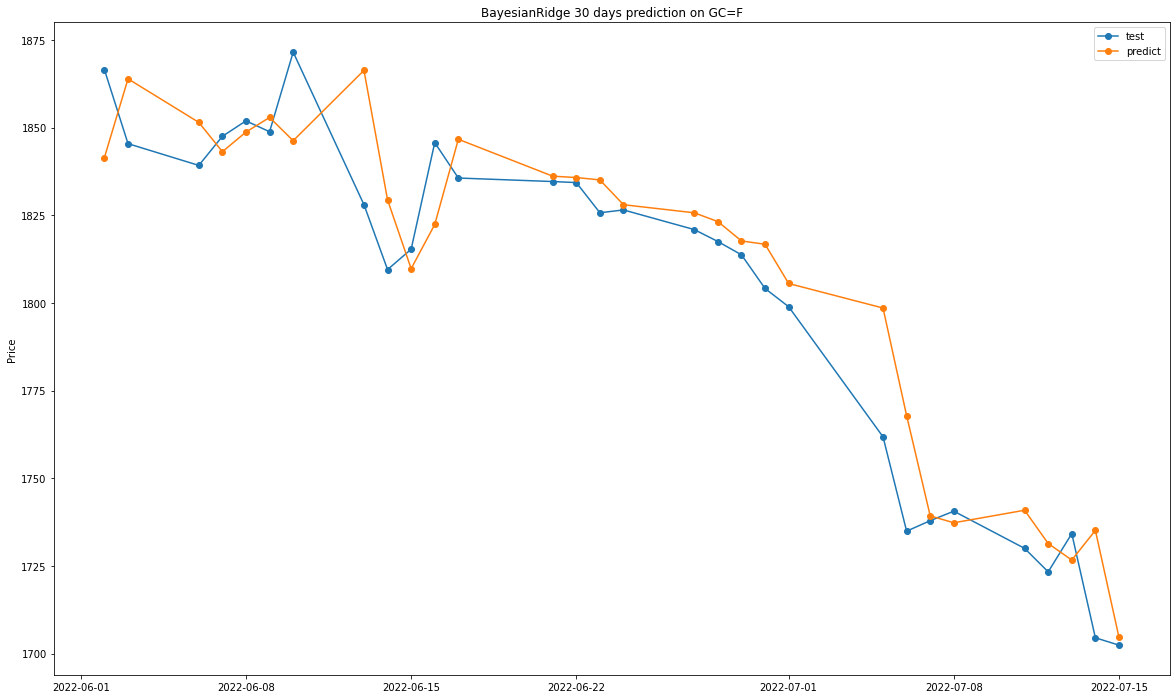

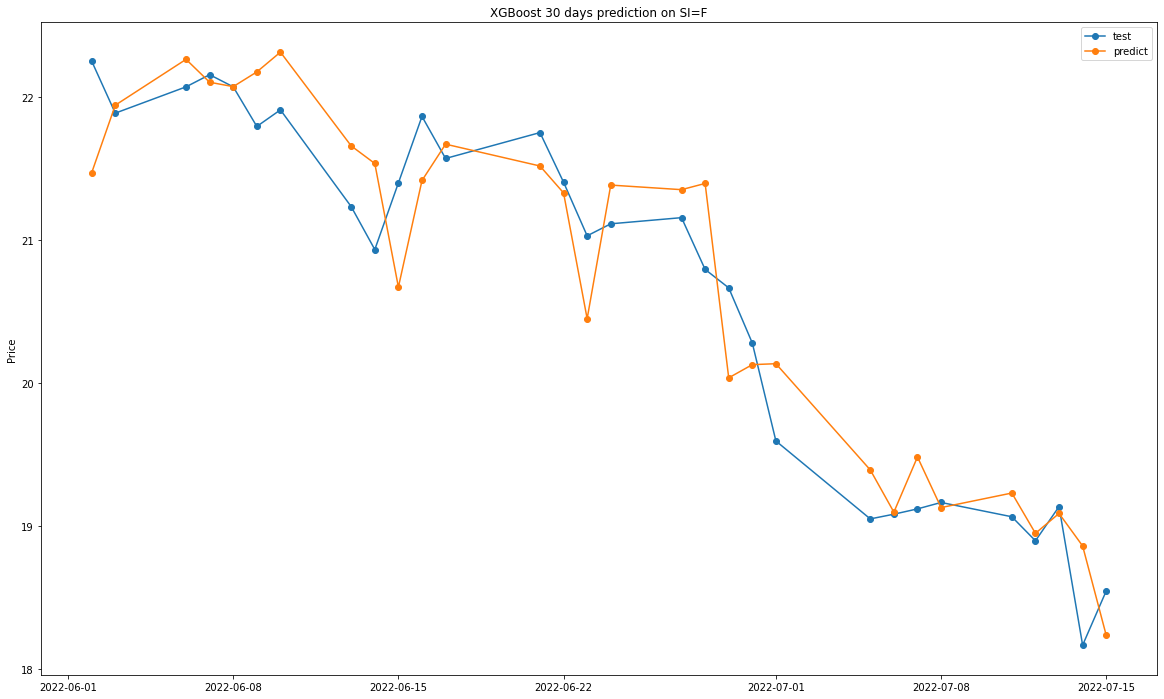

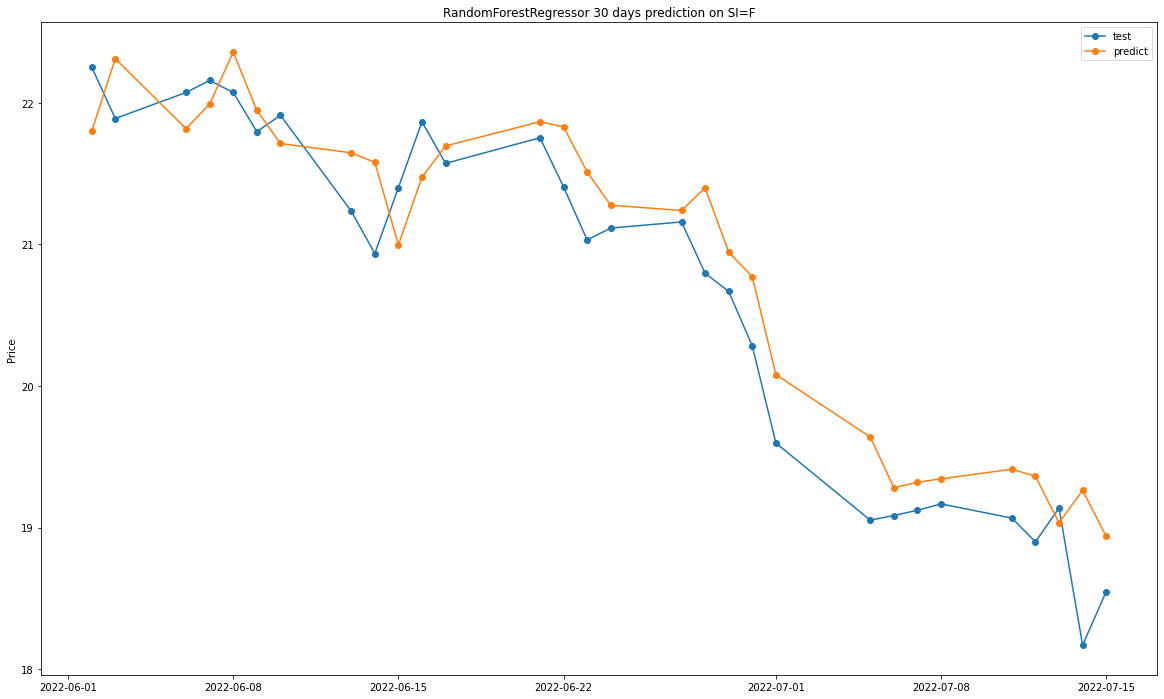

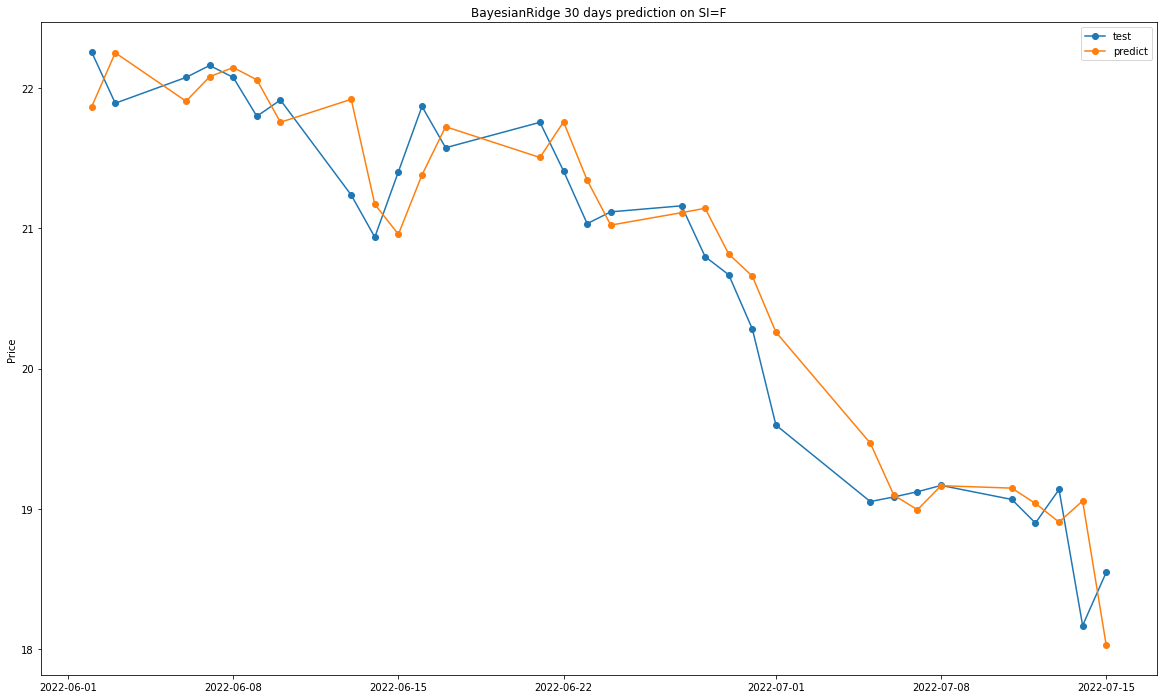

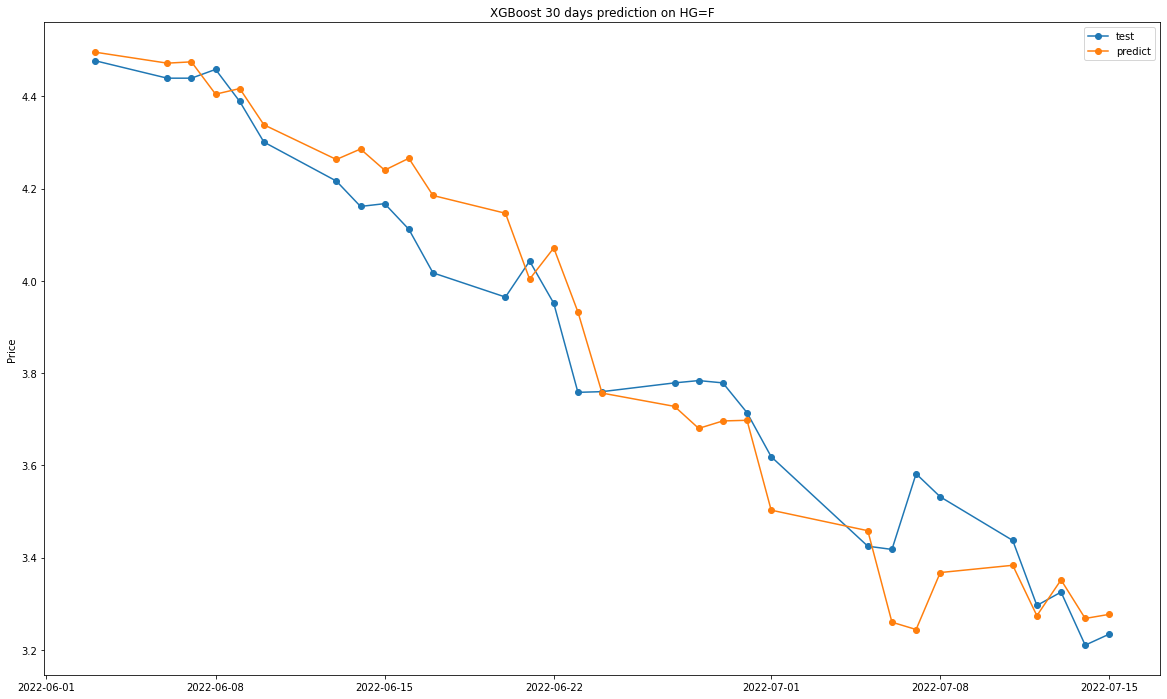

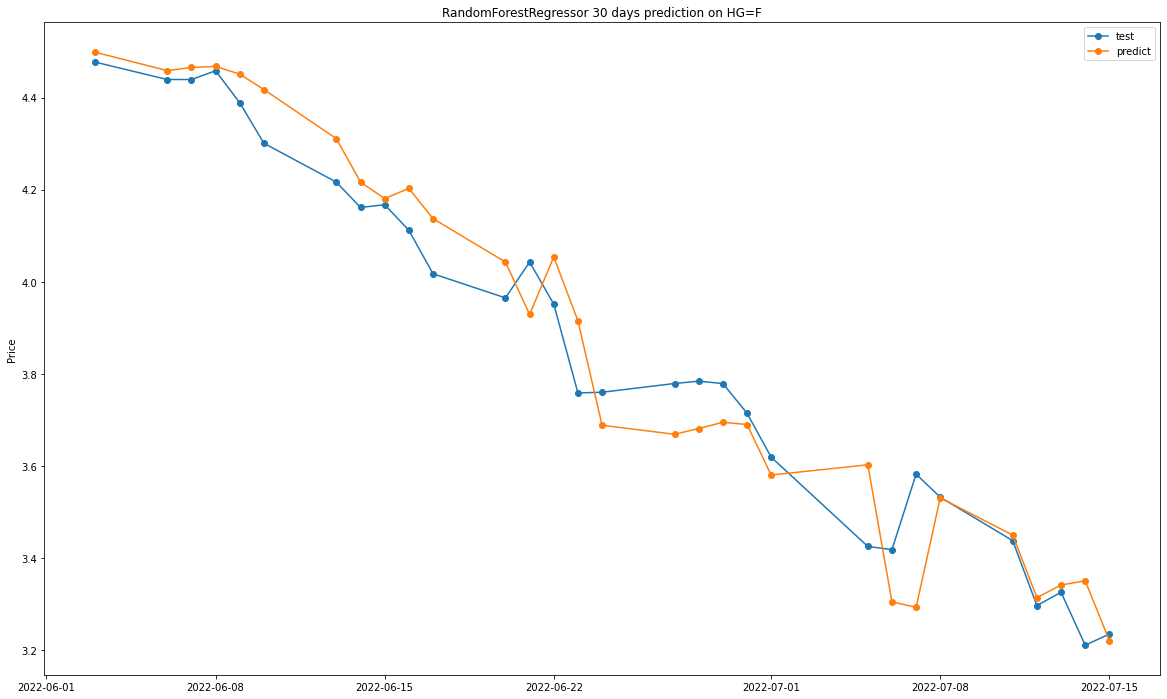

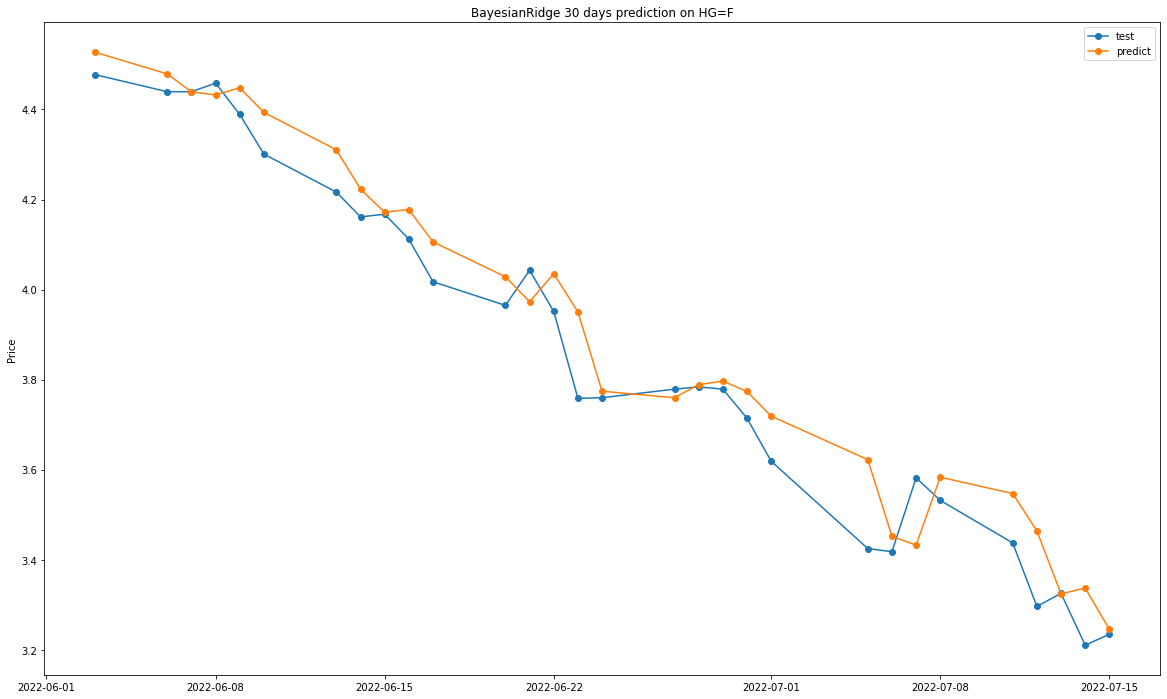

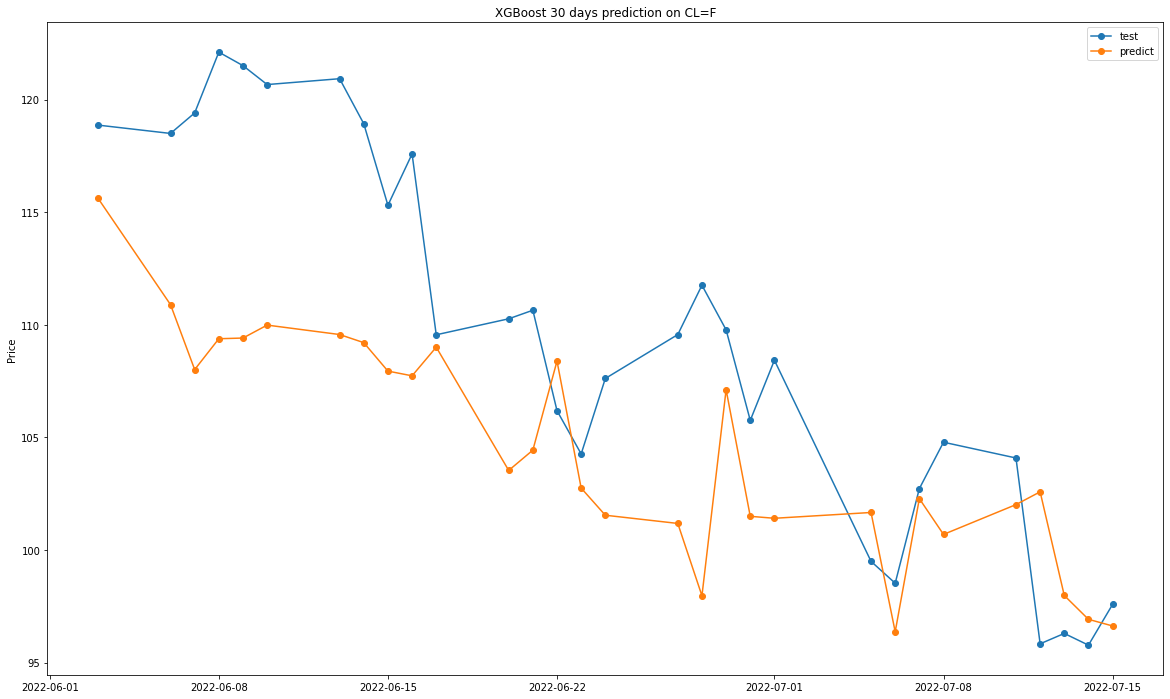

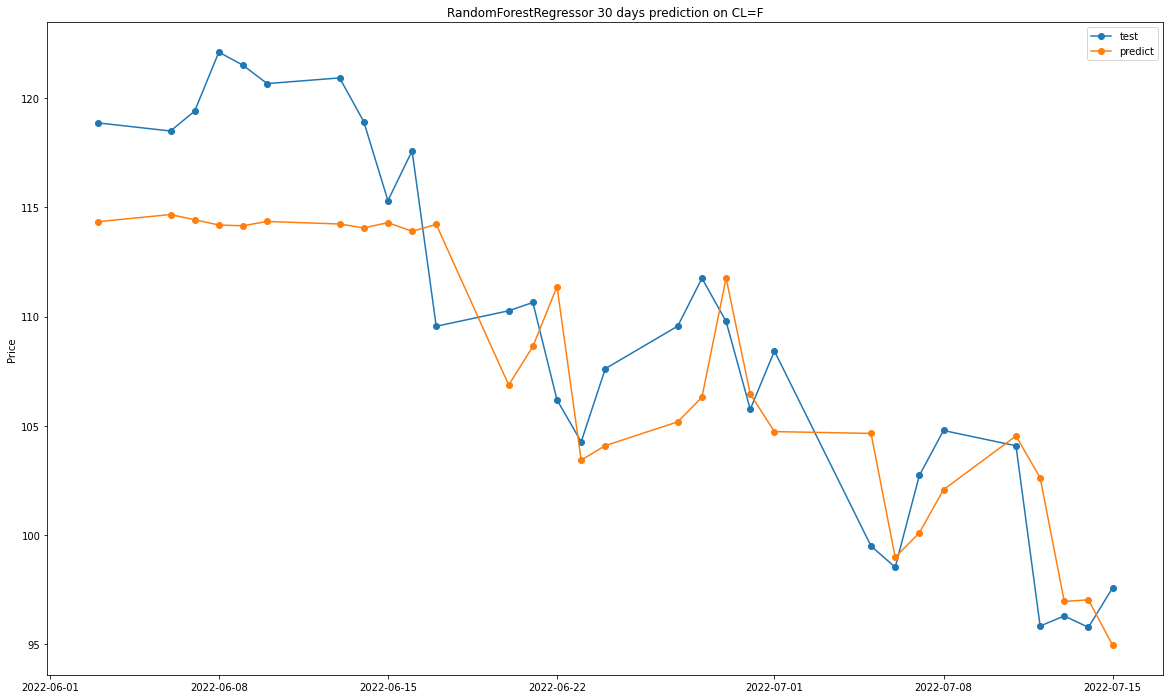

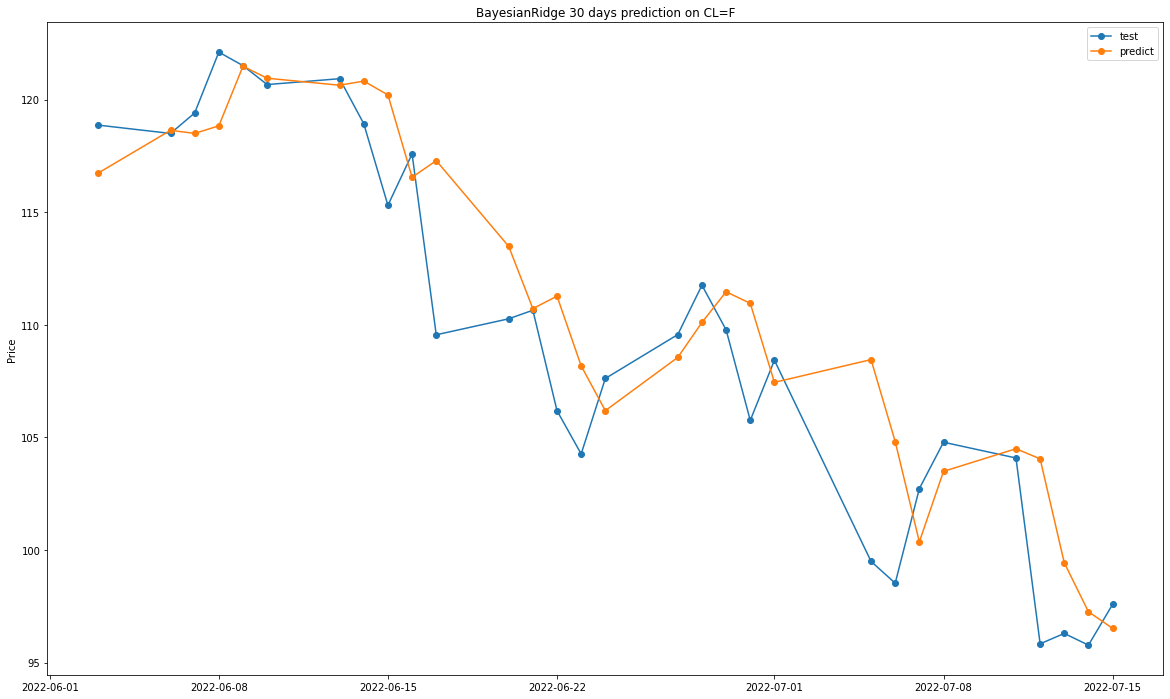

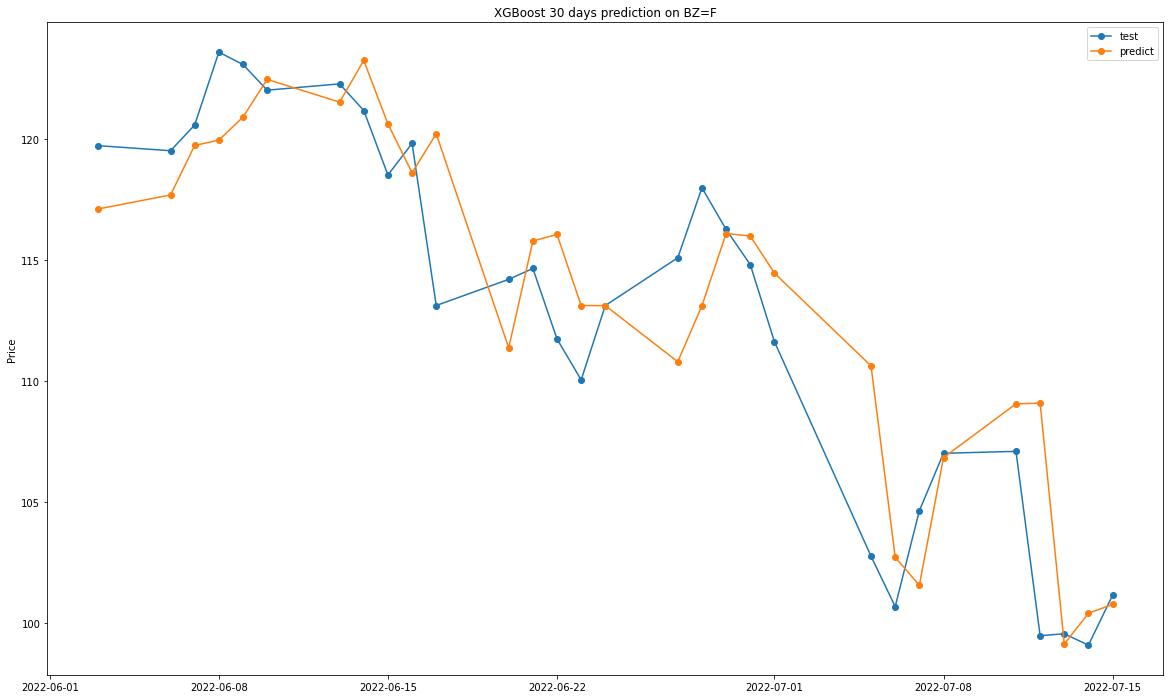

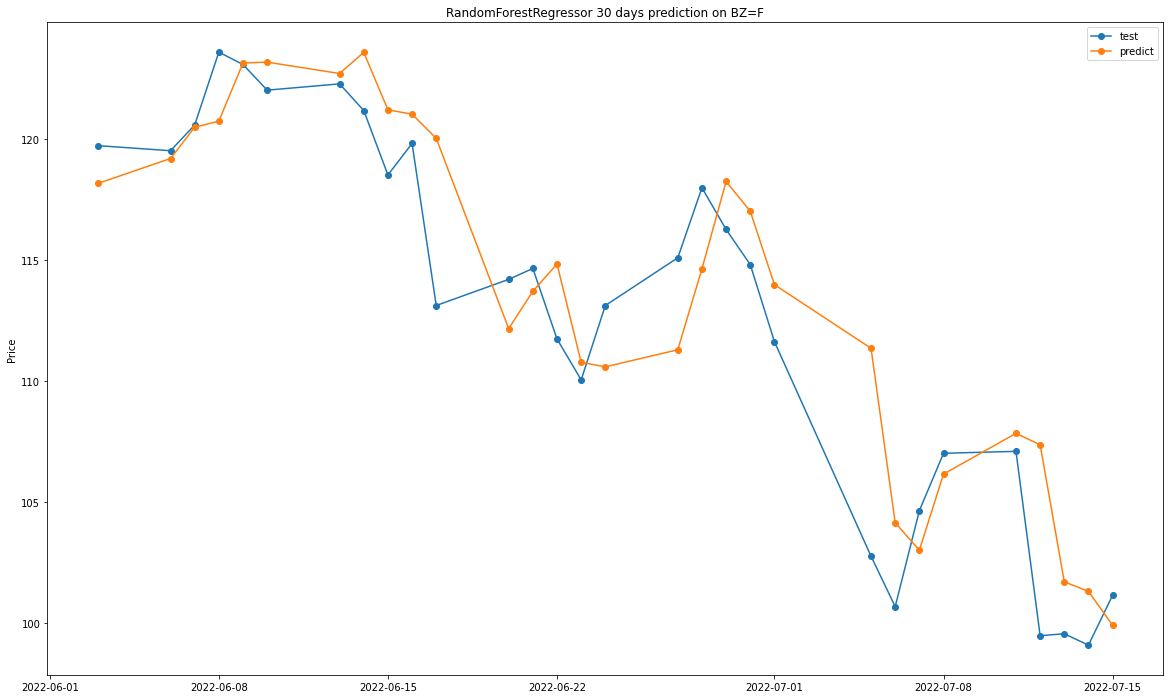

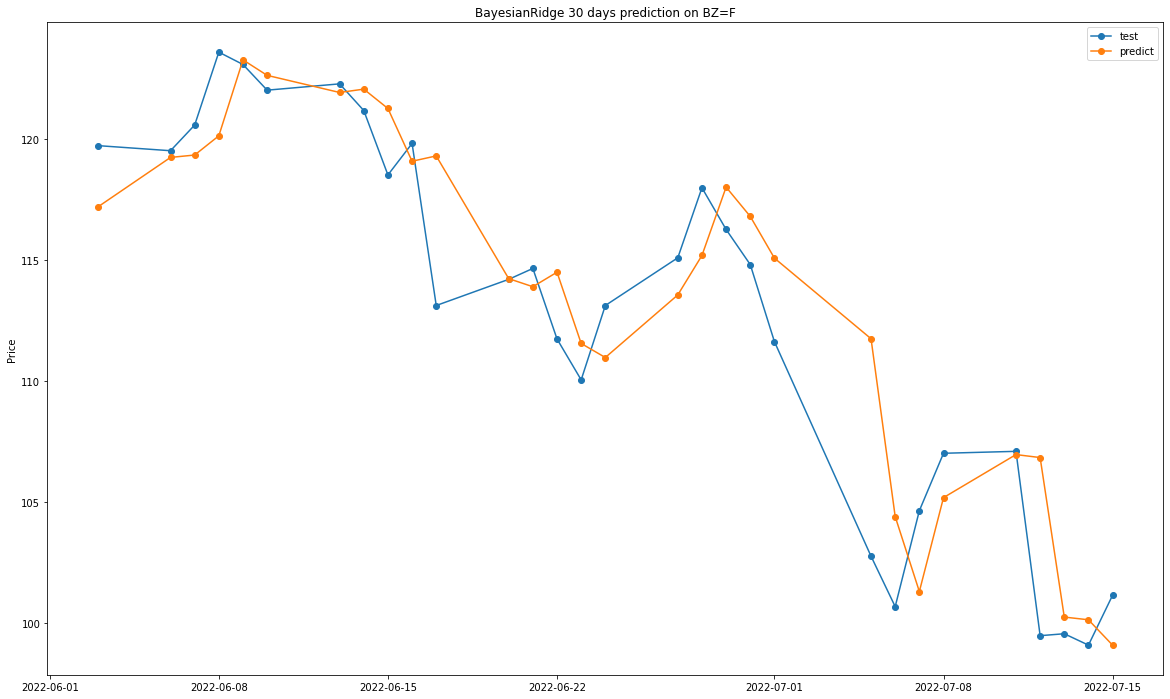

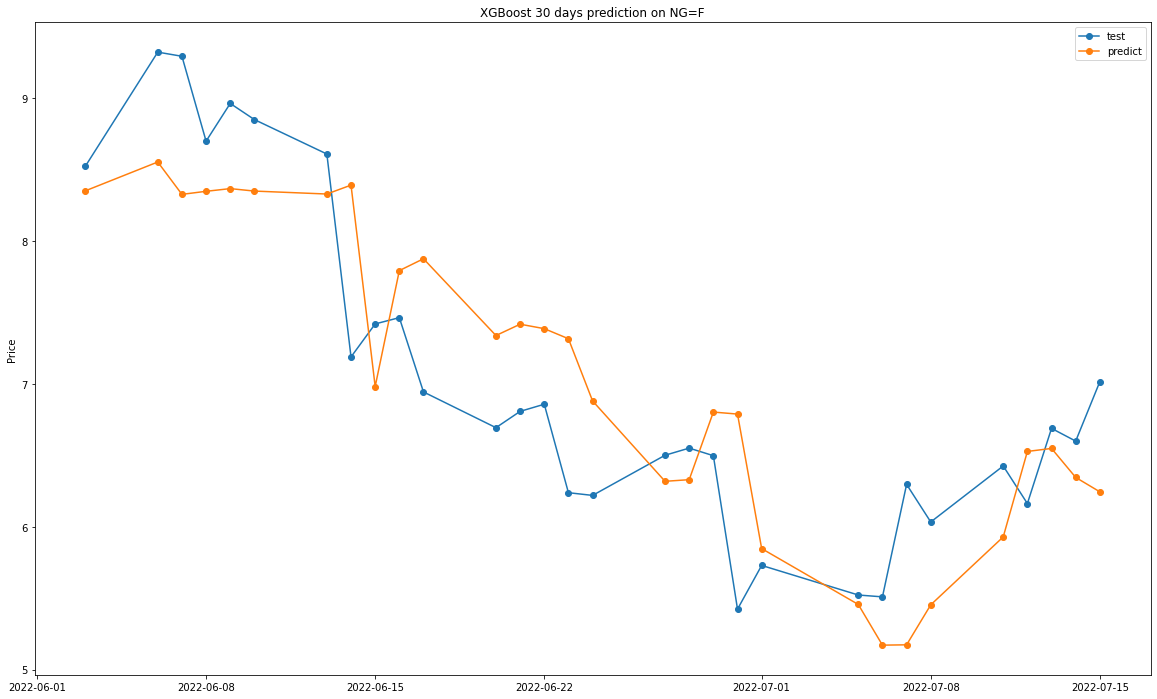

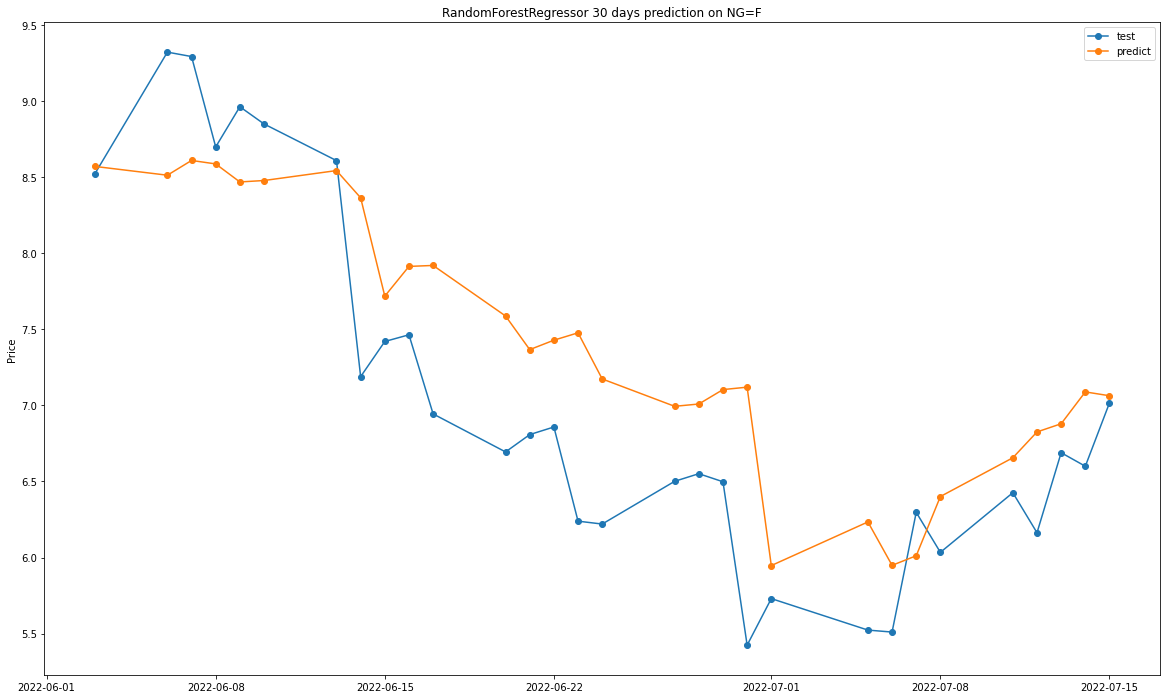

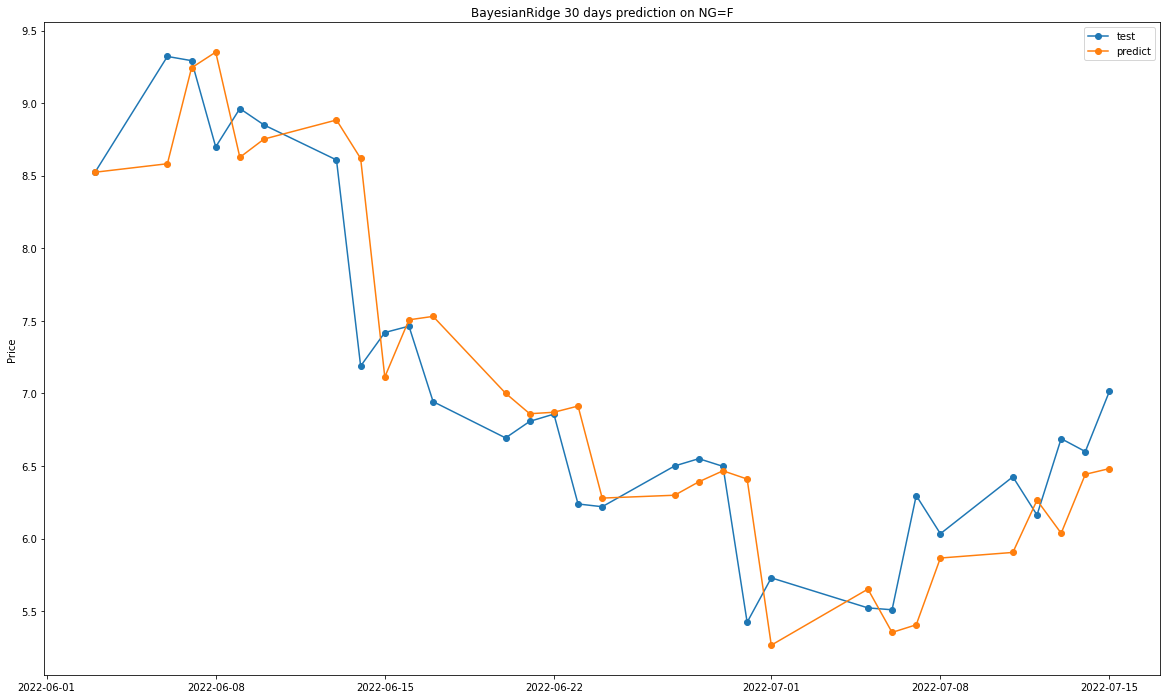

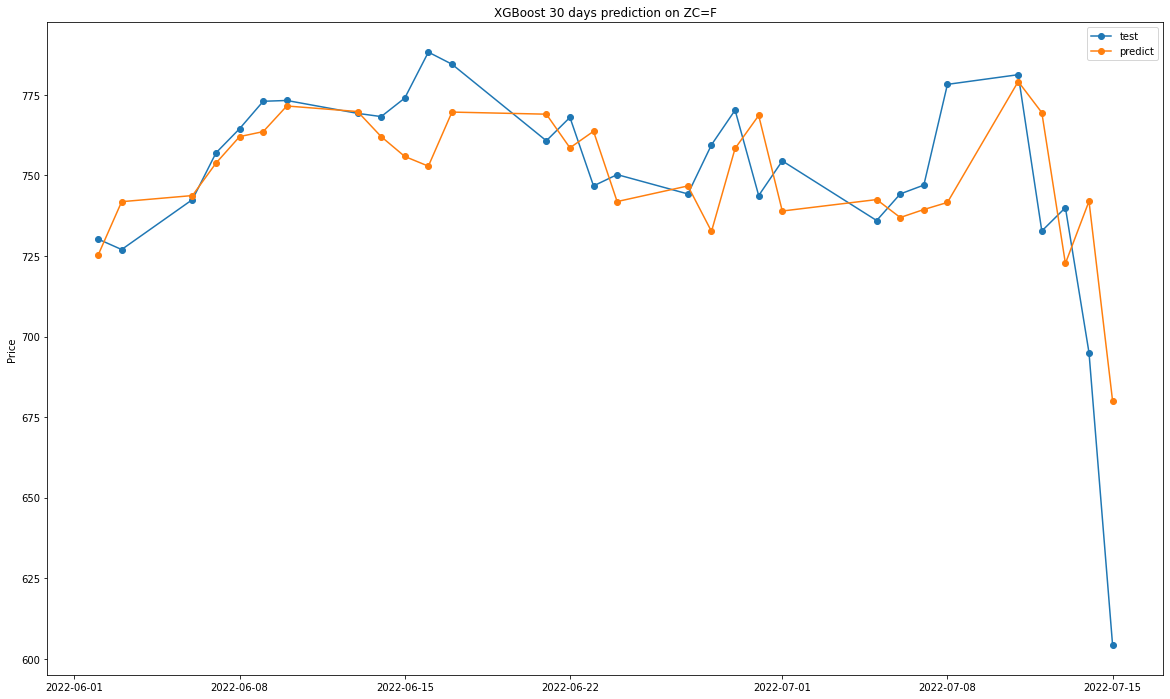

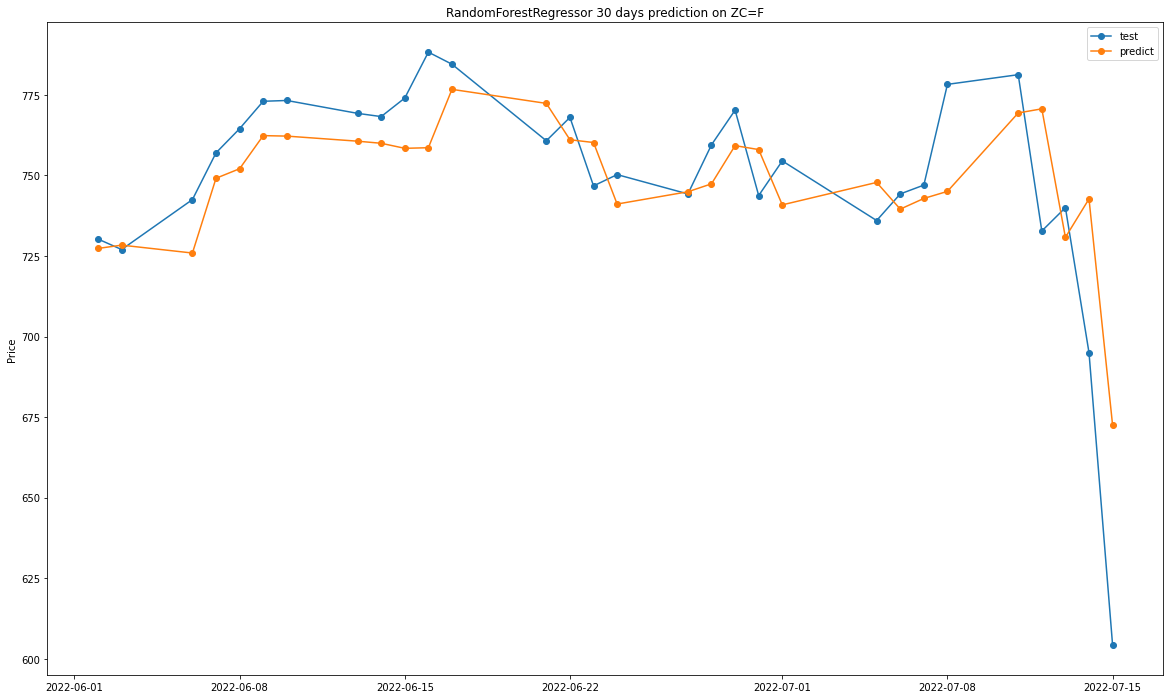

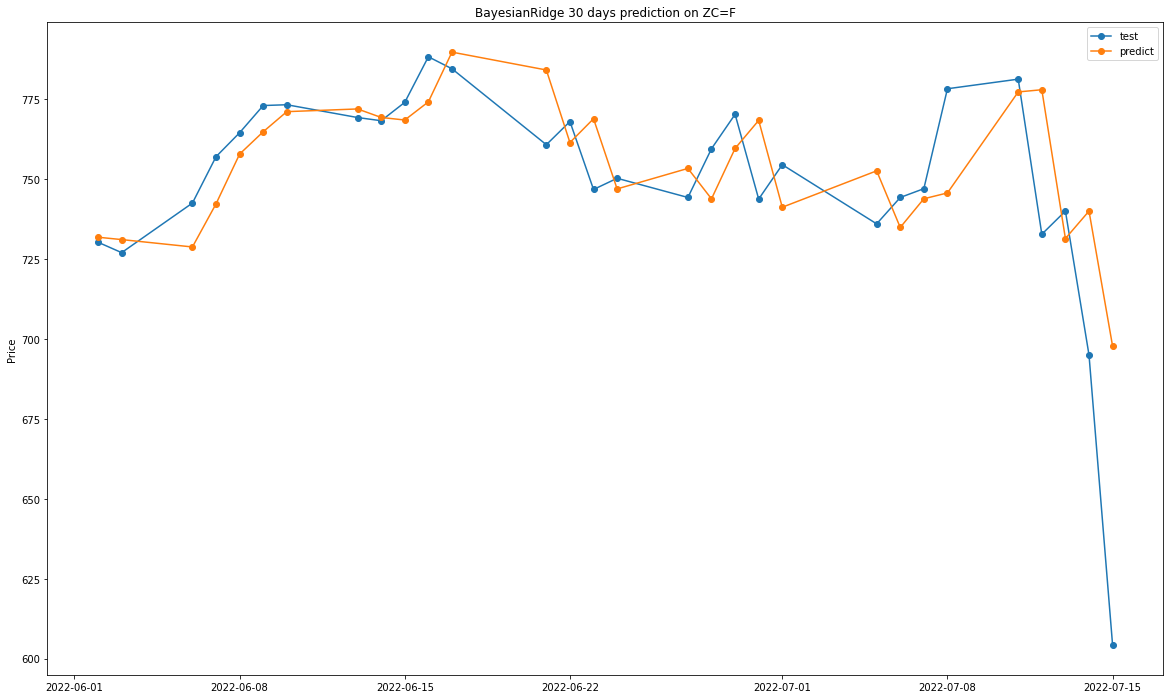

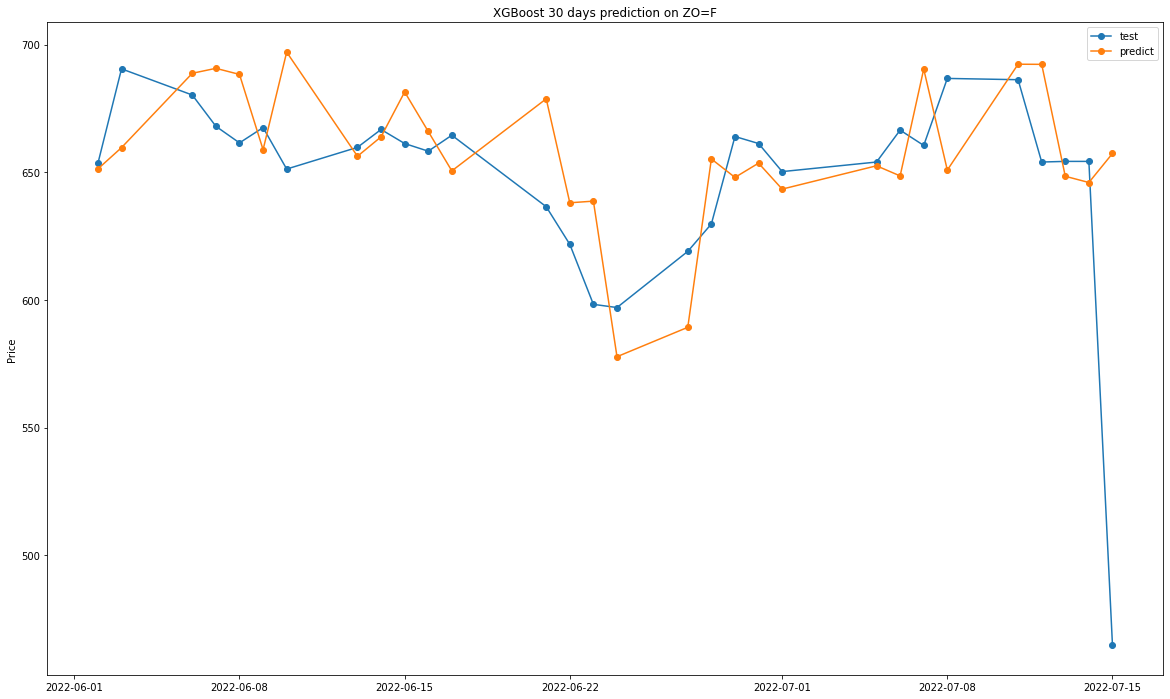

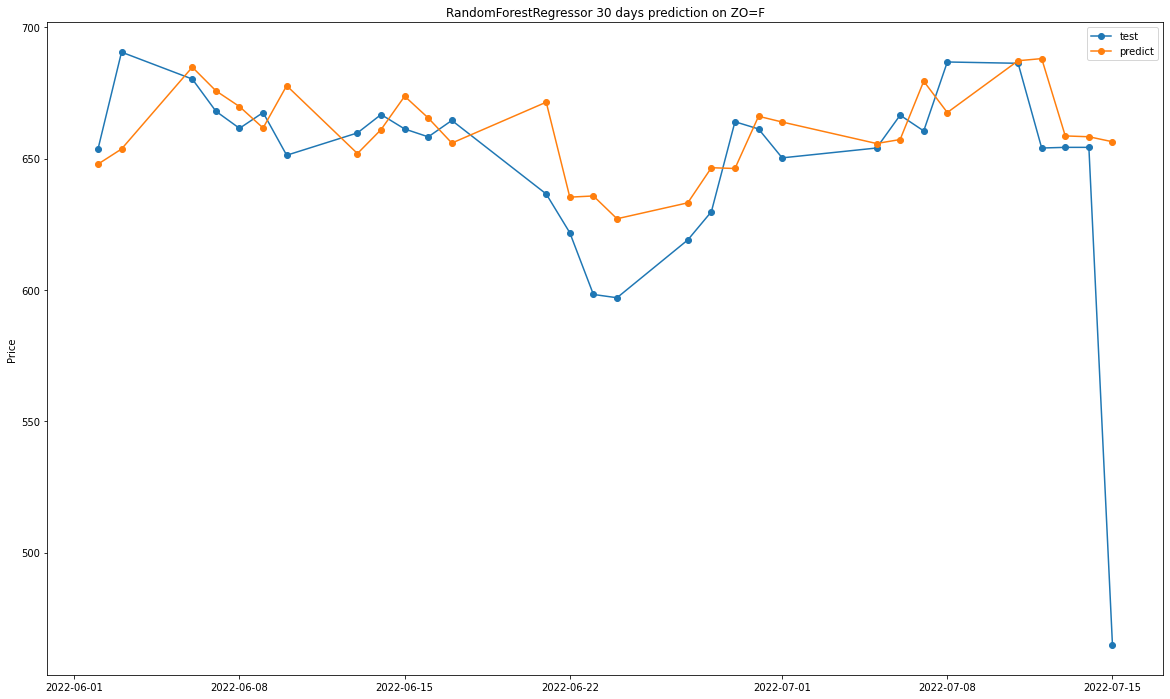

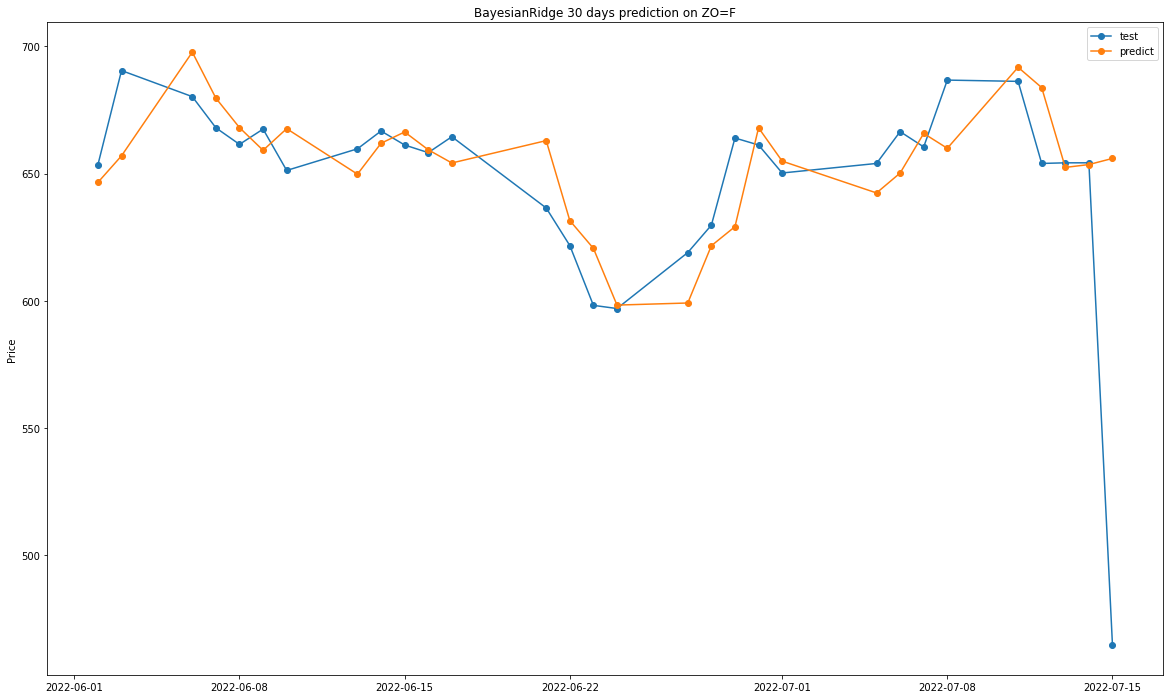

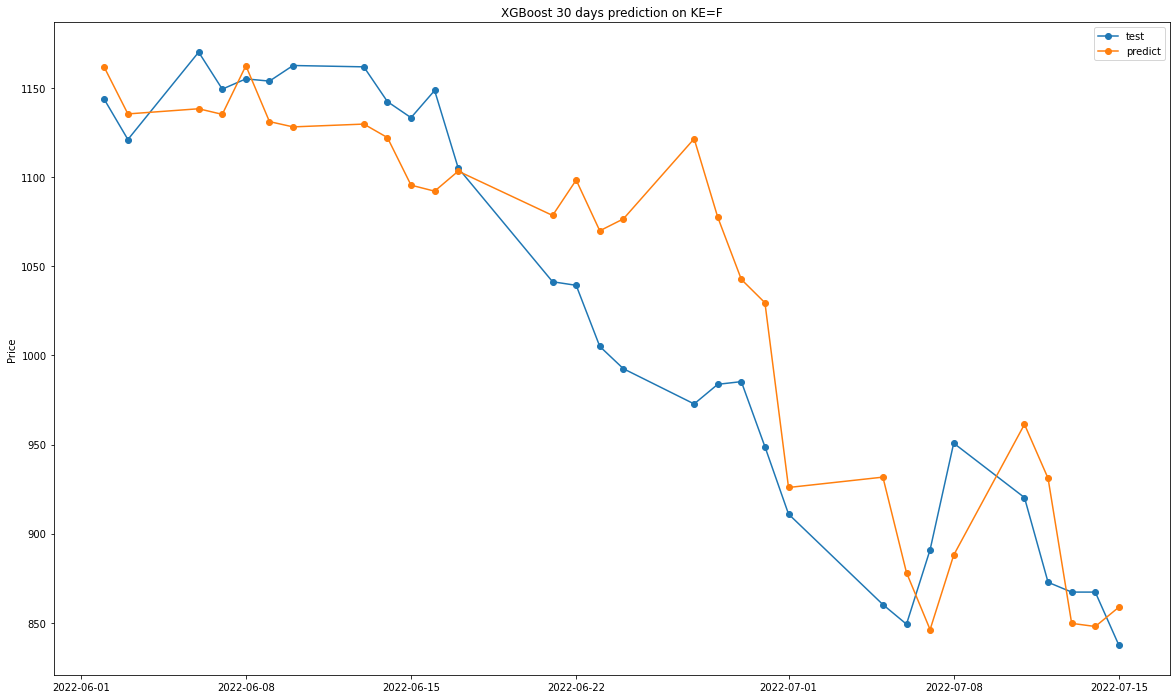

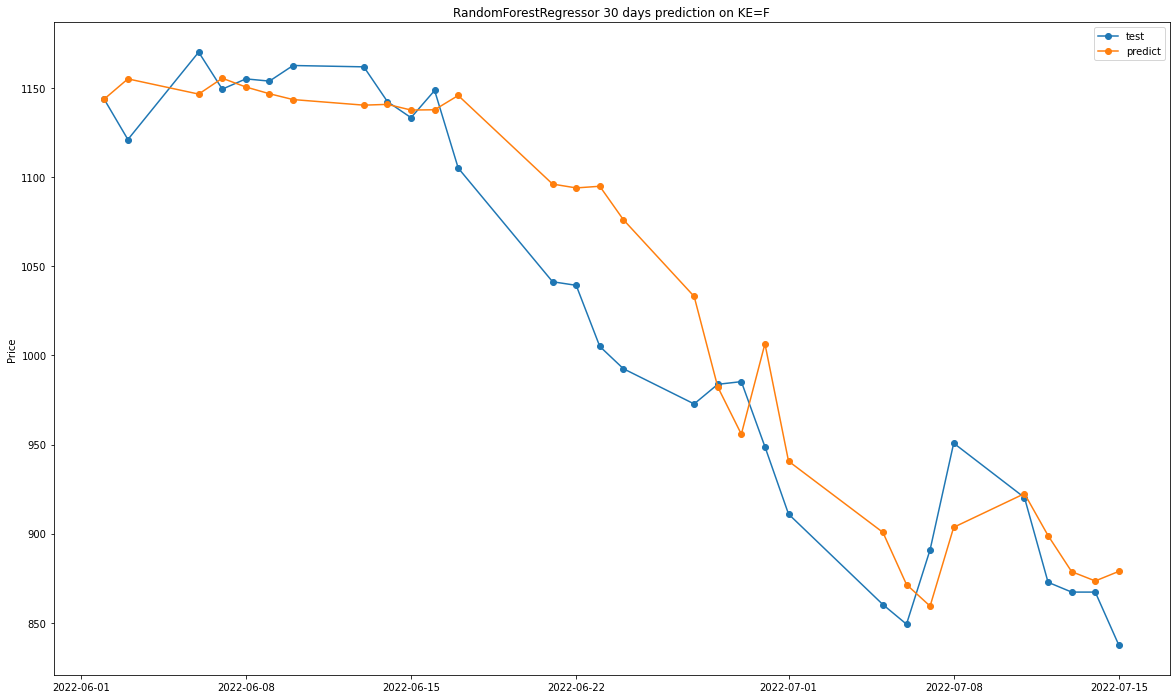

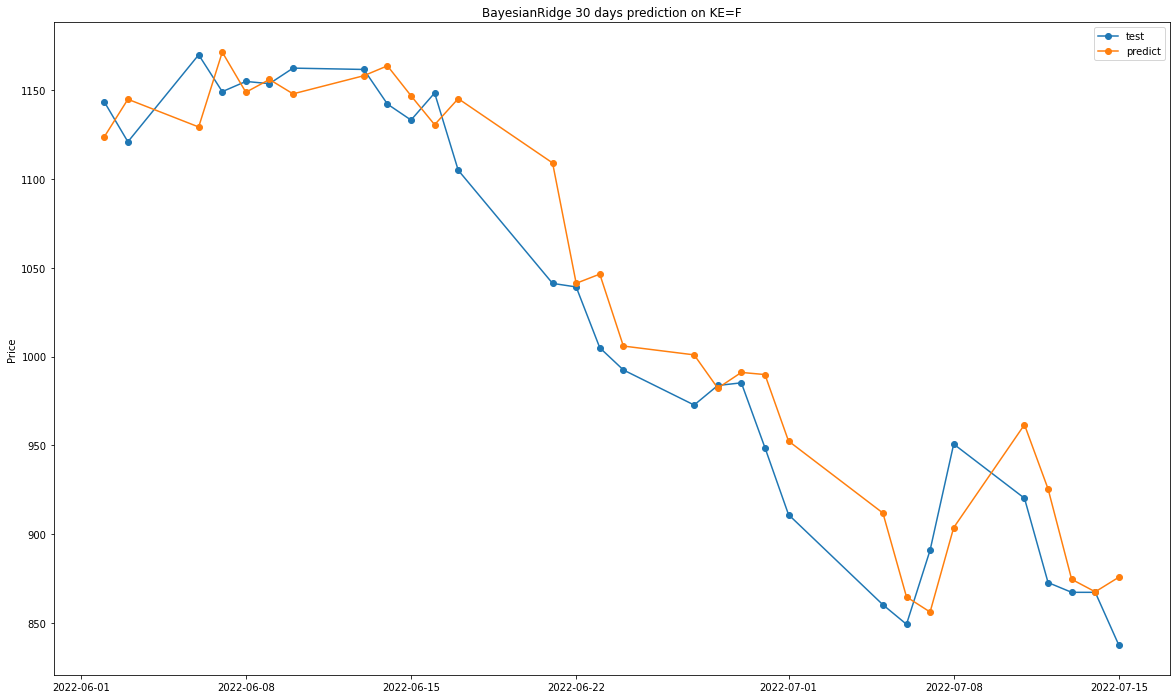

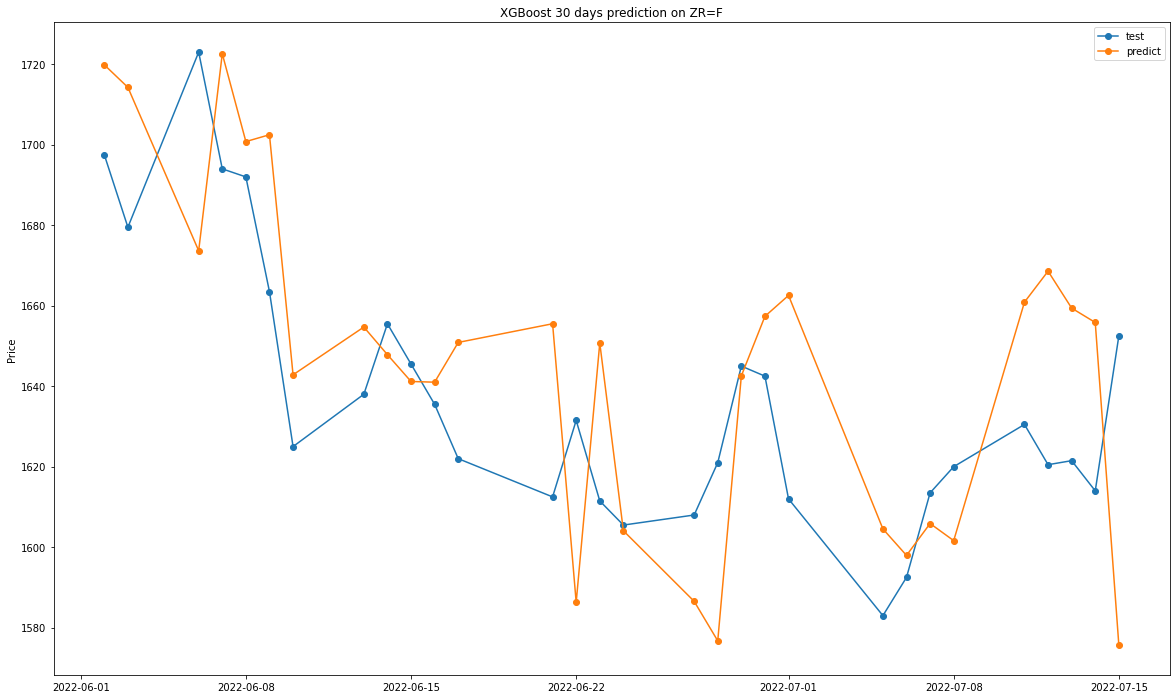

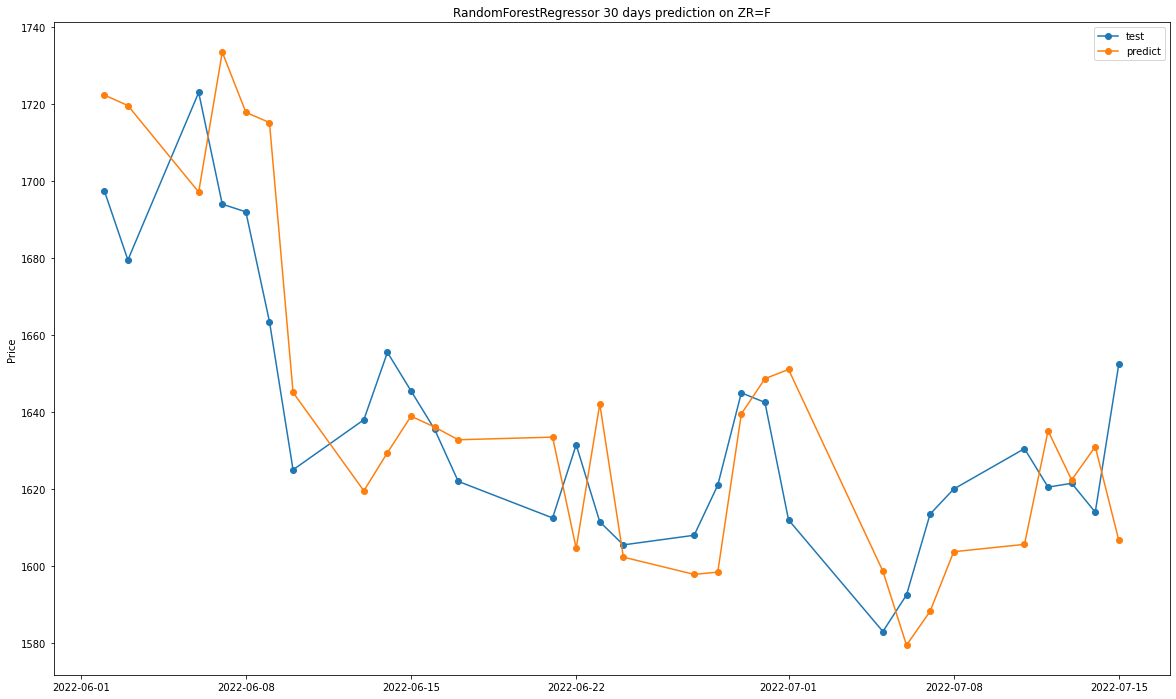

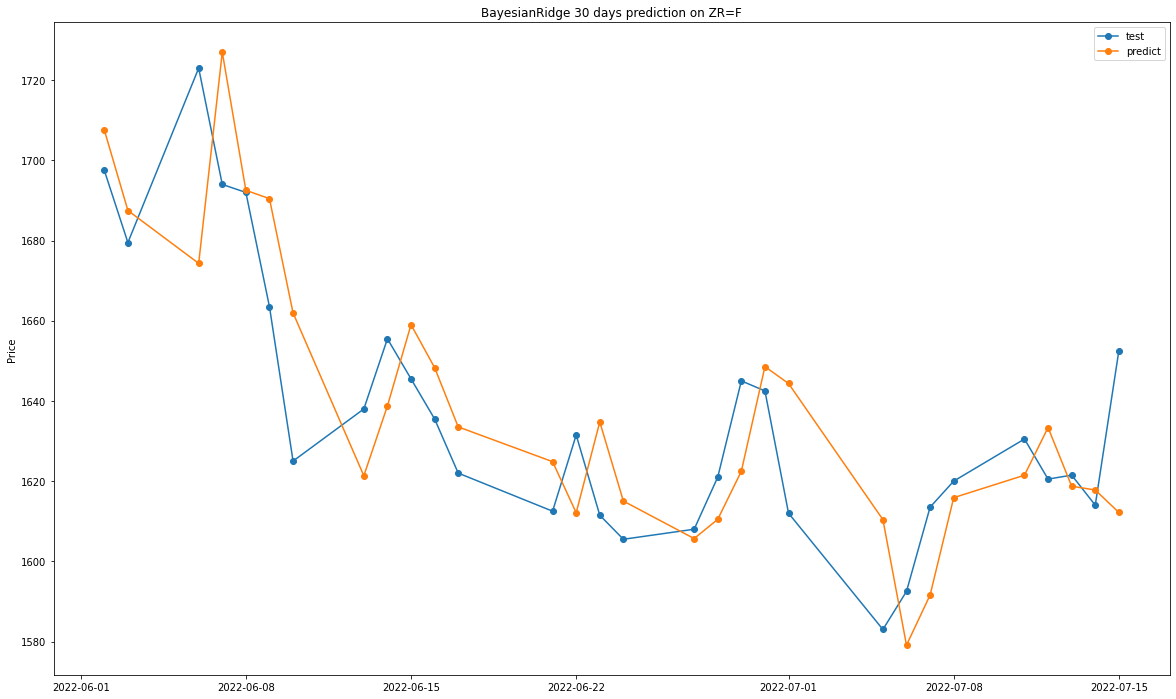

In [18]:
stock_names = []
mdl_names = []
r2s = []
mses = []
maes = []
mapes = []
run_times = []
df_pred_results = pd.DataFrame(columns=['Commodity'])
for stk, data in zip(stocks, trading_datas):
    print (stk)
    if __name__ == '__main__':
        stock_data = data
        STD_periods = [7]
        SMA_periods = [7, 14, 30, 50]
        SMA_envelope_range_percentage = 5
        EMA_period = 8
        MACD_shortPeriod = 12
        MACD_longPeriod = 26
        MACD_signalPeriod = 9
        RSI_period = 14
        Stoch_periods = [14, 14, 14, 14] #RSI, StochRSI, %K(max), %D(min)
        KDJ_periods = [14, 14]

        tis = Technical_Indicators(stock_data, STD_periods, SMA_periods, SMA_envelope_range_percentage, EMA_period, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod, RSI_period, Stoch_periods, KDJ_periods)
        stock_results = tis.main()
        result_names = str(stk)
        df_technical_data = stock_results.dropna(axis=0)
        #df_technical_data = df_technical_data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
        

    prediction_days = 50
    future_days = 30
    df_data = pd.DataFrame(columns=['Close'], index = df_technical_data.tail(df_technical_data.shape[0]).index[prediction_days:len(df_technical_data)].tolist())

    for col in df_technical_data.columns: #,'SMA','MACD_Signal','RSI' 
        #print (col)
        
        #df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
        #col_nam = str(col)+str('-1')
        #df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
        if col == 'Close':
            df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
            
            prediction_day = 7
            for index_init in range(prediction_day):
                rolling_data = df_technical_data.iloc[index_init: index_init+(len(df_technical_data[col]) - prediction_days),:][col].tolist()
                col_name = str(col)+str(index_init-prediction_day)
                df_data[col_name] = rolling_data
            '''
        elif col == 'Open':
            df_data['Open'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Open'].tolist()
            '''
        else:
            col_nam = str(col)+str('-1')
            df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
    
    
    XGB = XGBRegressor()#num_boost_round=v1, eta=v2, max_depth=v3, gamma=v4,#early_stopping_rounds=20)
    RFR = RandomForestRegressor()
    #SGD = SGDRegressor()
    BYR = BayesianRidge()
    #LAS = Lasso()
    #SVR = svm.SVR(kernel="poly")

    models = [XGB, 
              RFR,
              #SVR,
              #SGD,
              BYR,
              #LAS
             ]
    model_names = ['XGBoost', 
                   'RandomForestRegressor',
                   #'SupportVectorRegressor',
                   #'SGDRegressor',
                   'BayesianRidge',
                   #'Lasso'
                  ]
    
    time_set_num = 1
    data_length = len(df_data)
    
    for model, mdl_name in zip(models, model_names):
        
        for i in range(1, time_set_num+1):
            df_train_period = df_data.iloc[future_days*(i-1): data_length-future_days*(time_set_num-(i-1)), :]
            df_test_period = df_data.iloc[data_length-future_days*(time_set_num-(i-1)): data_length-future_days*(time_set_num-(i)), :]

            
            x_train = df_train_period[df_train_period.columns.drop('Close').tolist()]
            y_train = df_train_period['Close']
            x_test = df_test_period[df_test_period.columns.drop('Close').tolist()]
            y_test = df_test_period['Close']
            '''
            scaler = MinMaxScaler(feature_range=(0,1))
            scaled_train = df_train_period.copy()
            scaled_test = df_test_period.copy()
            for col in df_train_period.columns:
                scaled_train[col] = scaler.fit_transform(df_train_period[col].values.reshape(-1,1))
                scaled_test[col] = scaler.fit_transform(df_test_period[col].values.reshape(-1,1))
            
            x_train = scaled_train[scaled_train.columns.drop('Close').tolist()]
            y_train = scaled_train['Close']
            x_test = scaled_test[scaled_test.columns.drop('Close').tolist()]
            y_test = scaled_test['Close']
            '''
            
        if mdl_name == 'SGDRegressor':
            SGD_pipline = make_pipeline(StandardScaler(),
                                        SGDRegressor(max_iter=1000, tol=1e-3)
                                       )
            model = SGD_pipline
        mdlst = time.time()  
        model.fit(x_train, y_train)
        predict_test = model.predict(x_test)
        mdled = time.time()  
        
        r2_scr = r2_score(y_test, predict_test)
        mse = mean_squared_error(y_test, predict_test)
        mae = mean_absolute_error(y_test, predict_test)
        mape = mean_absolute_percentage_error(y_test, predict_test)
        '''
        print (mdl_name,"'s performances:")
        print (' R^2 Score', r2_scr)
        print (' Mean Squared Error', mse)
        print (' Mean Absolute Error', mae)
        print (' Mean Absolute Percentage Error', mape)
        '''
        mdl_names.append(mdl_name)
        stock_names.append(stk)
        r2s.append(r2_scr)
        mses.append(mse)
        maes.append(mae)
        mapes.append(mape)
        run_times.append(mdled-mdlst)
            
        #scr_name = str(i)+str()
        #df_pred_results[scr_name]
            
        fig, ax = plt.subplots(figsize=(20,12))
        #ax.plot(y_train.index.tolist(), y_train, label='train',)
        ax.plot(y_test.index.tolist(), y_test,'o-', label='test',)
        ax.plot(y_test.index.tolist(), predict_test, 'o-', label='predict')
        ax.set_title(str(mdl_name)+' '+str(future_days)+' days prediction on '+str(stk))
        ax.set_ylabel('Price')
        ax.legend()
    

df_pred_results['Model'] = mdl_names
df_pred_results['Commodity'] = stock_names
df_pred_results['R^2'] = r2s
df_pred_results['MSE'] = mses
df_pred_results['MAE'] = maes
df_pred_results['MAPE'] = mapes
df_pred_results['Running Time'] = run_times
print (df_pred_results)


In [32]:
df_pred_results.to_excel('Commodity_ML_Predictions.xlsx')

## MinMaxScaled

GC=F
SI=F
HG=F
CL=F
BZ=F
NG=F
ZC=F


<ipython-input-19-d3cbf04de270>:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20,12))


ZO=F
KE=F
ZR=F
   Commodity                  Model       R^2       MSE       MAE  \
0       GC=F                XGBoost  0.878362  0.010829  0.081071   
1       GC=F  RandomForestRegressor  0.883624  0.010360  0.078159   
2       GC=F          BayesianRidge  0.879237  0.010751  0.080878   
3       SI=F                XGBoost  0.879401  0.011641  0.084689   
4       SI=F  RandomForestRegressor  0.915237  0.008182  0.072014   
5       SI=F          BayesianRidge  0.926190  0.007125  0.069585   
6       HG=F                XGBoost  0.958067  0.004024  0.051105   
7       HG=F  RandomForestRegressor  0.957973  0.004033  0.047409   
8       HG=F          BayesianRidge  0.966558  0.003210  0.044018   
9       CL=F                XGBoost  0.755303  0.024546  0.123839   
10      CL=F  RandomForestRegressor  0.760387  0.024036  0.116681   
11      CL=F          BayesianRidge  0.641490  0.035963  0.144613   
12      BZ=F                XGBoost  0.826427  0.017571  0.097463   
13      BZ=F  Rando

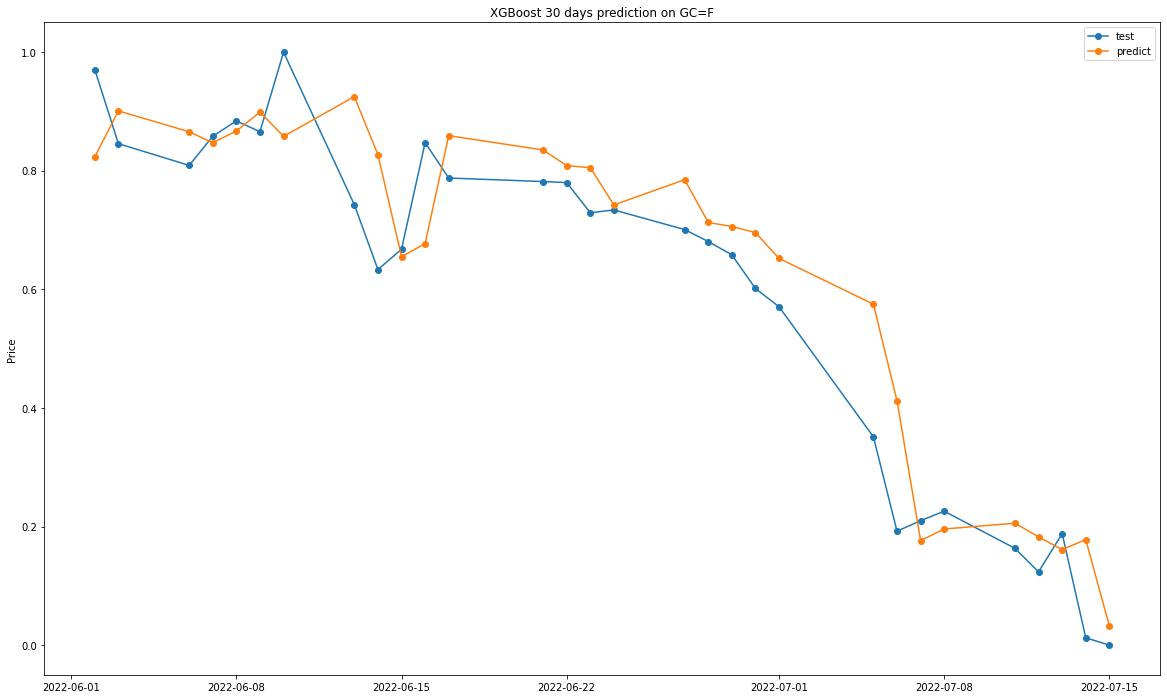

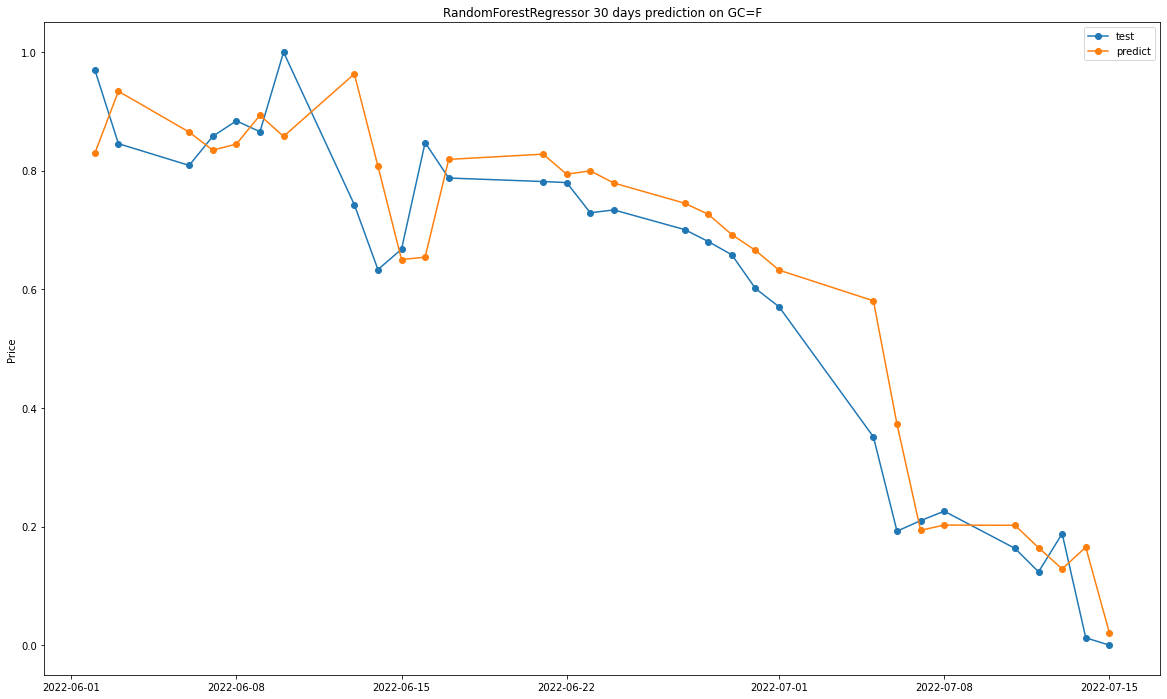

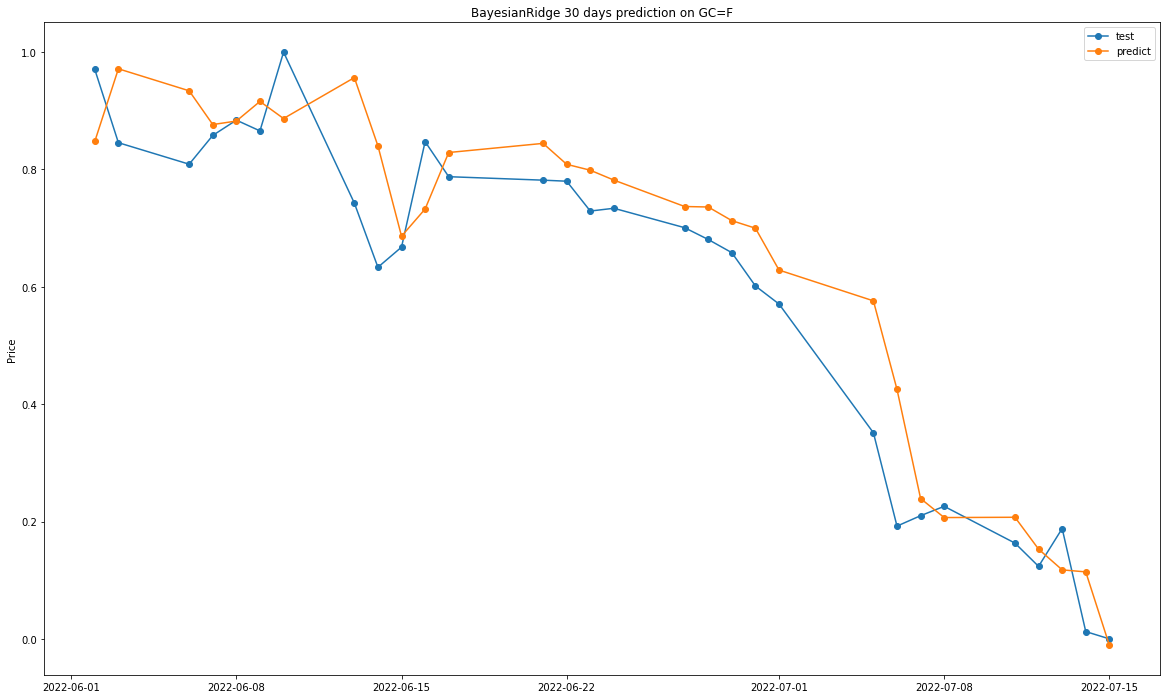

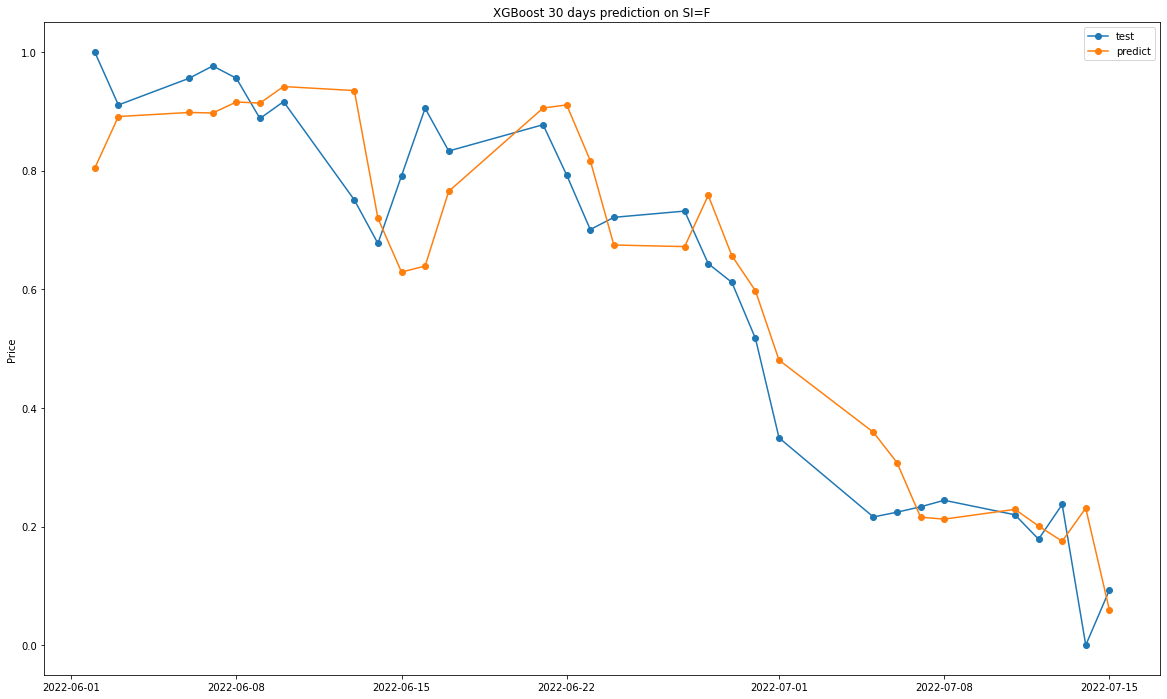

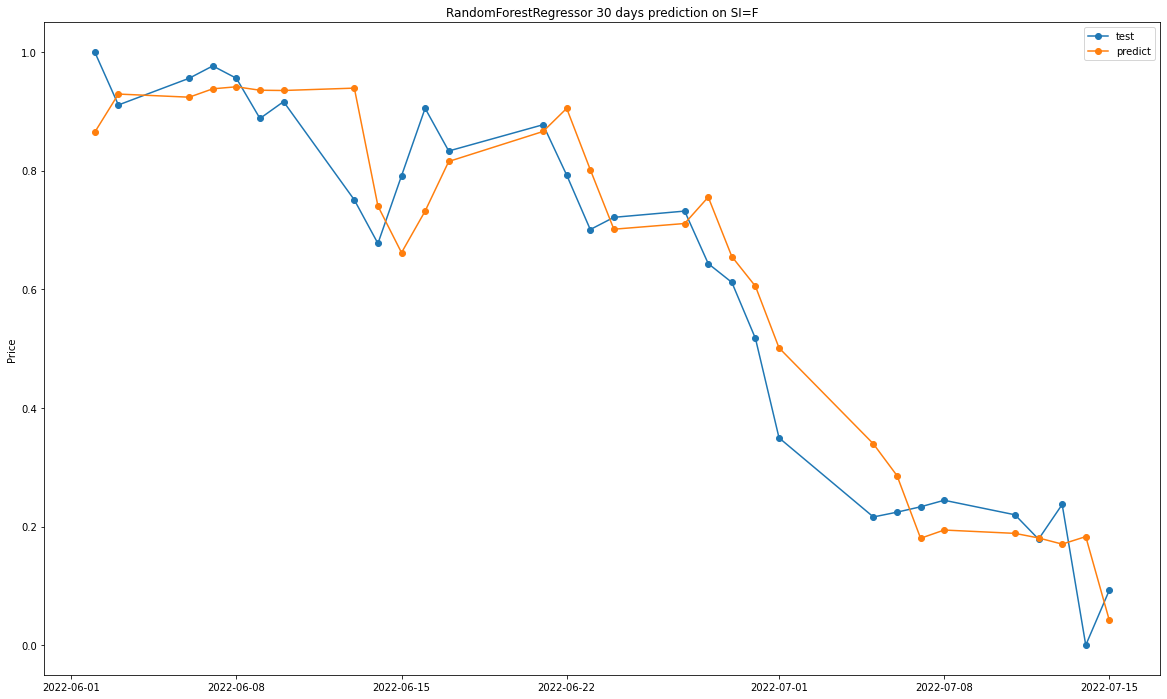

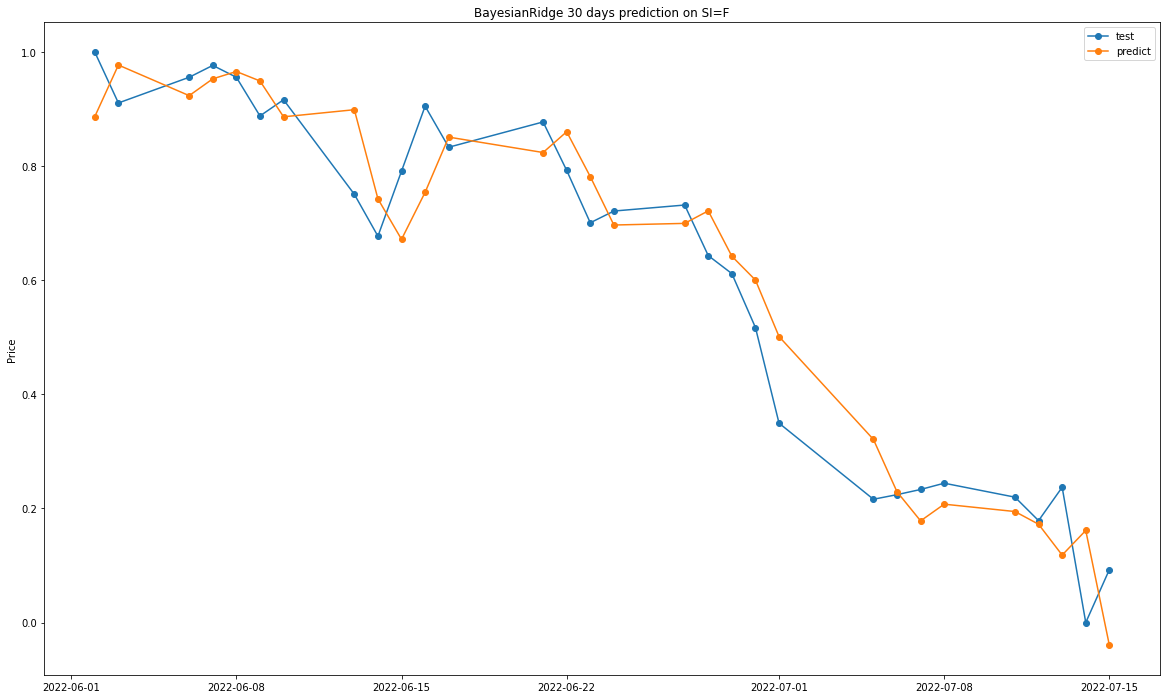

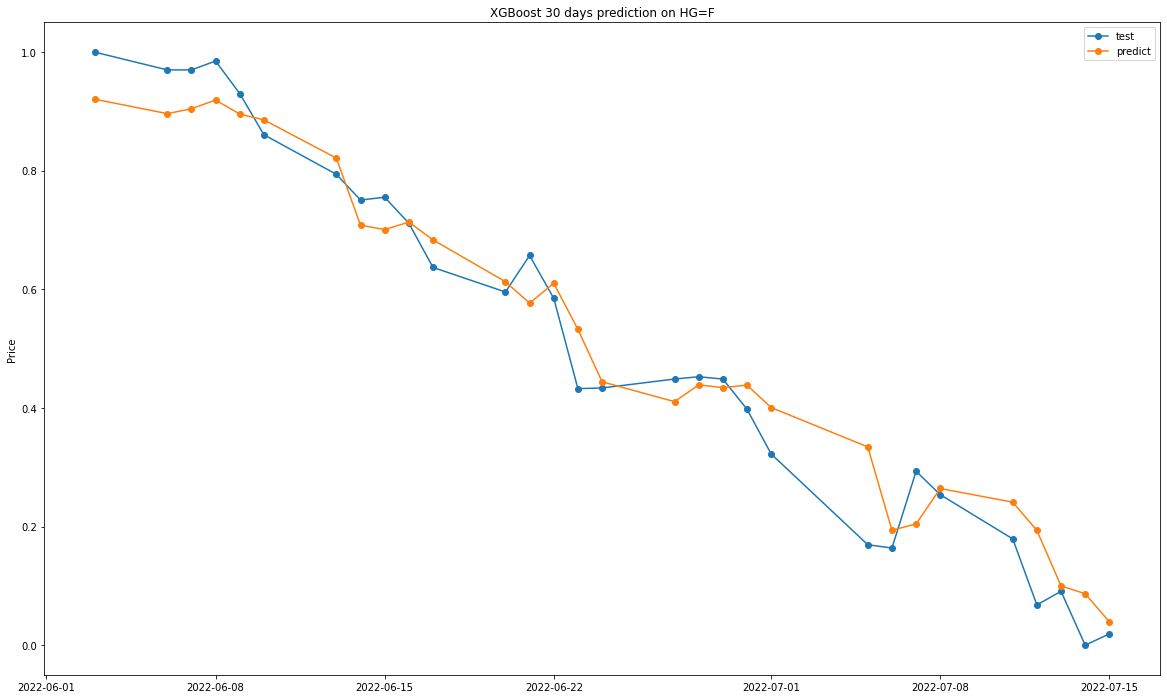

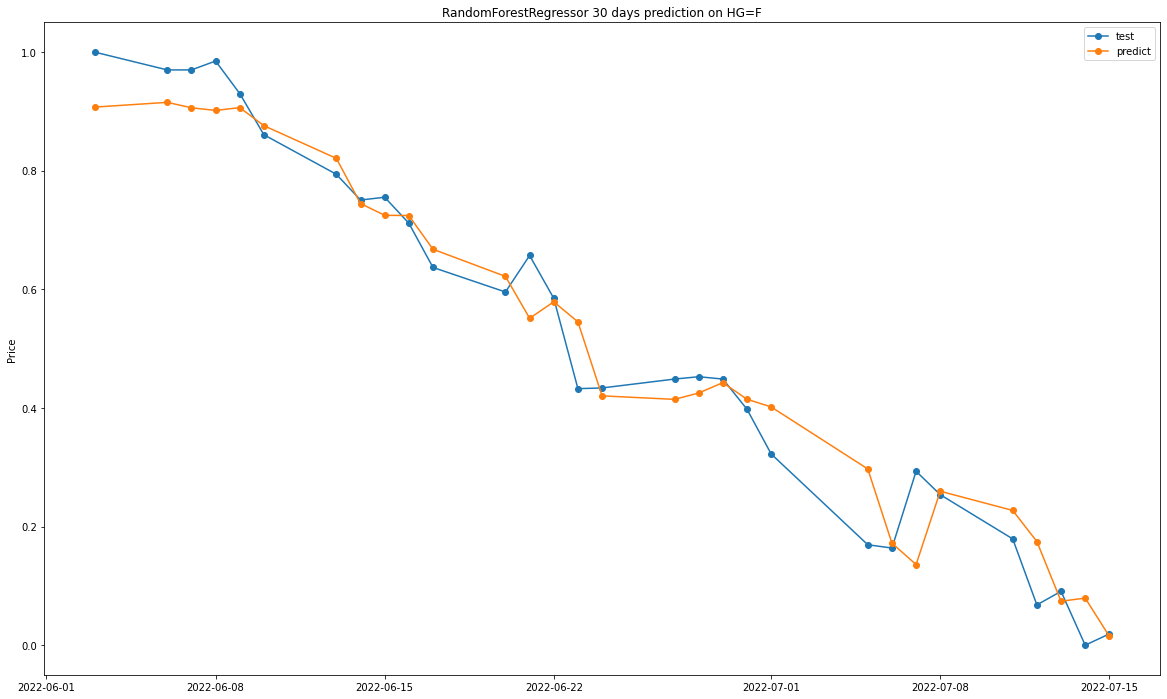

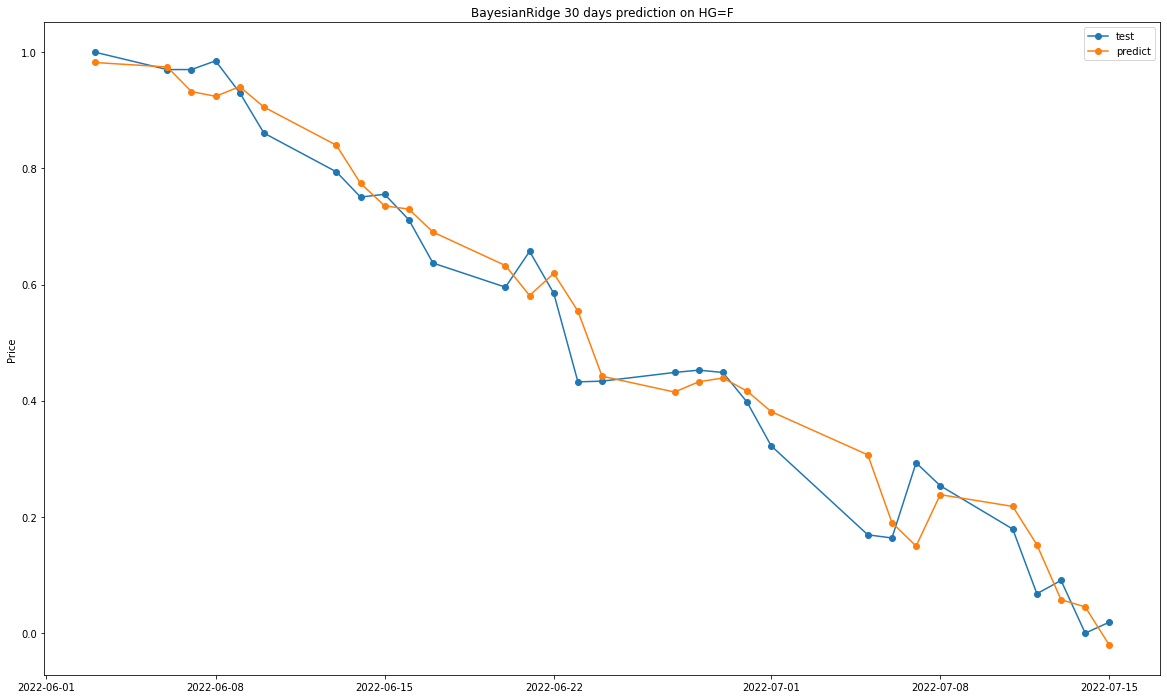

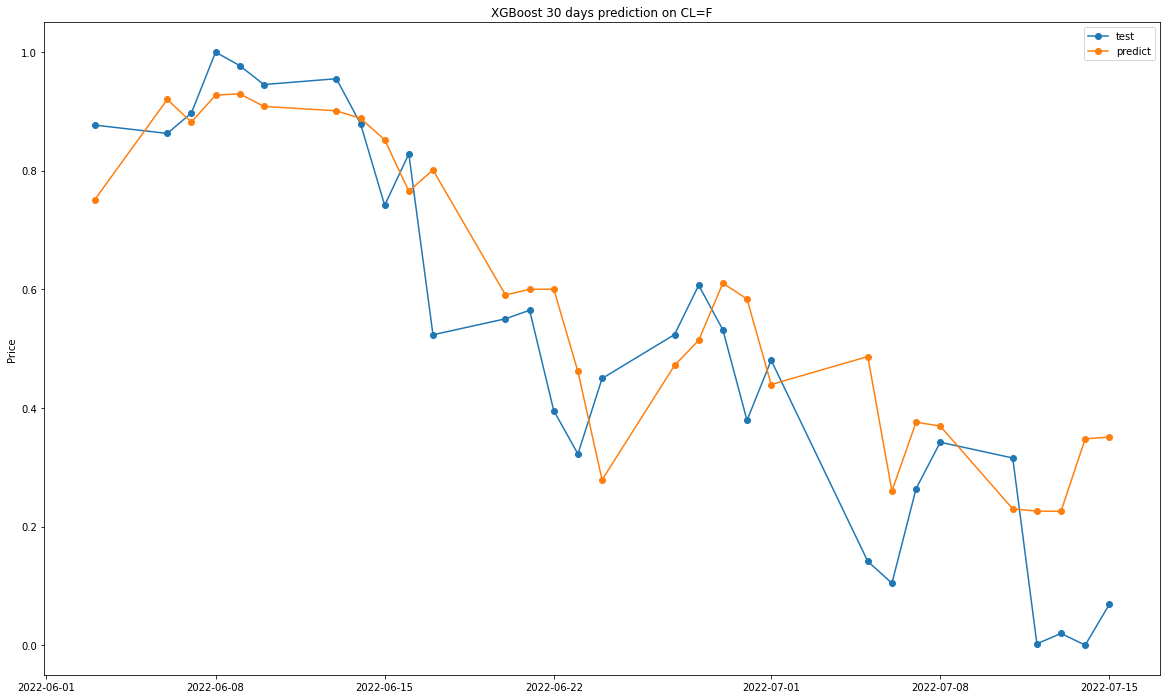

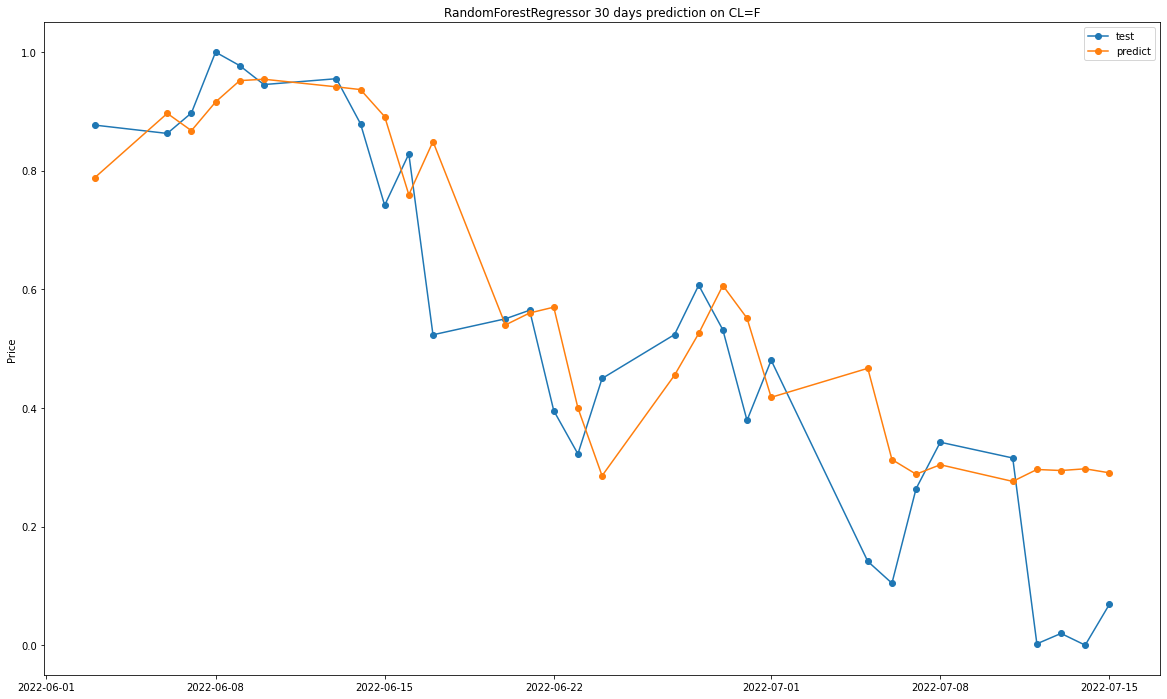

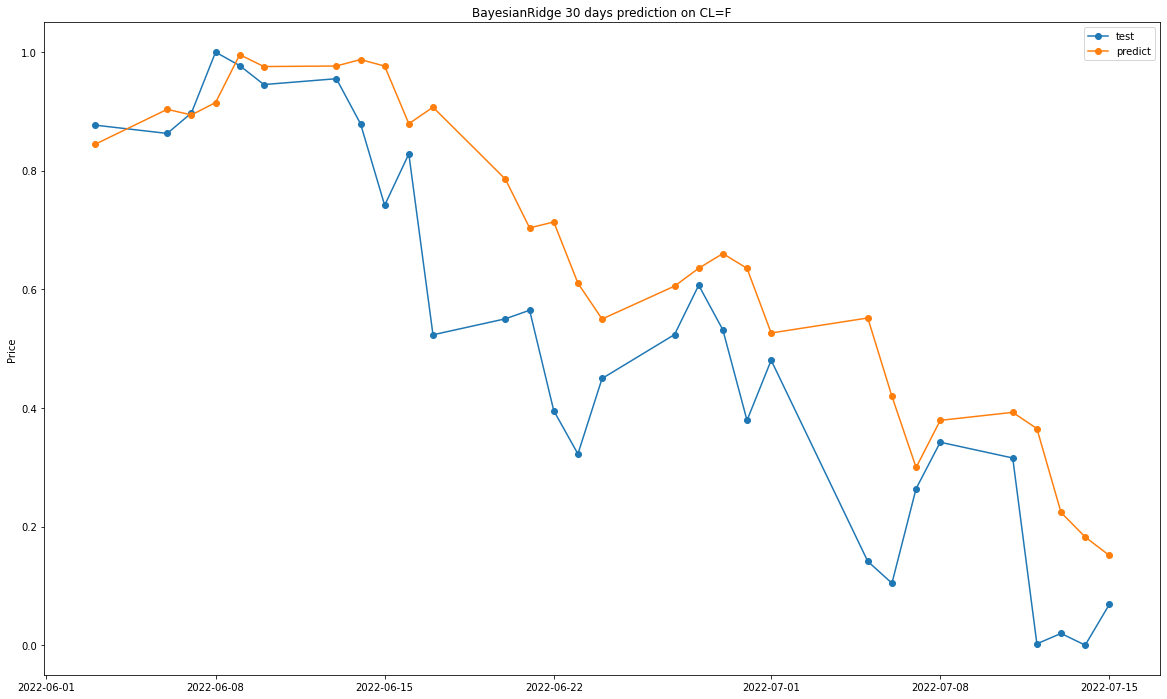

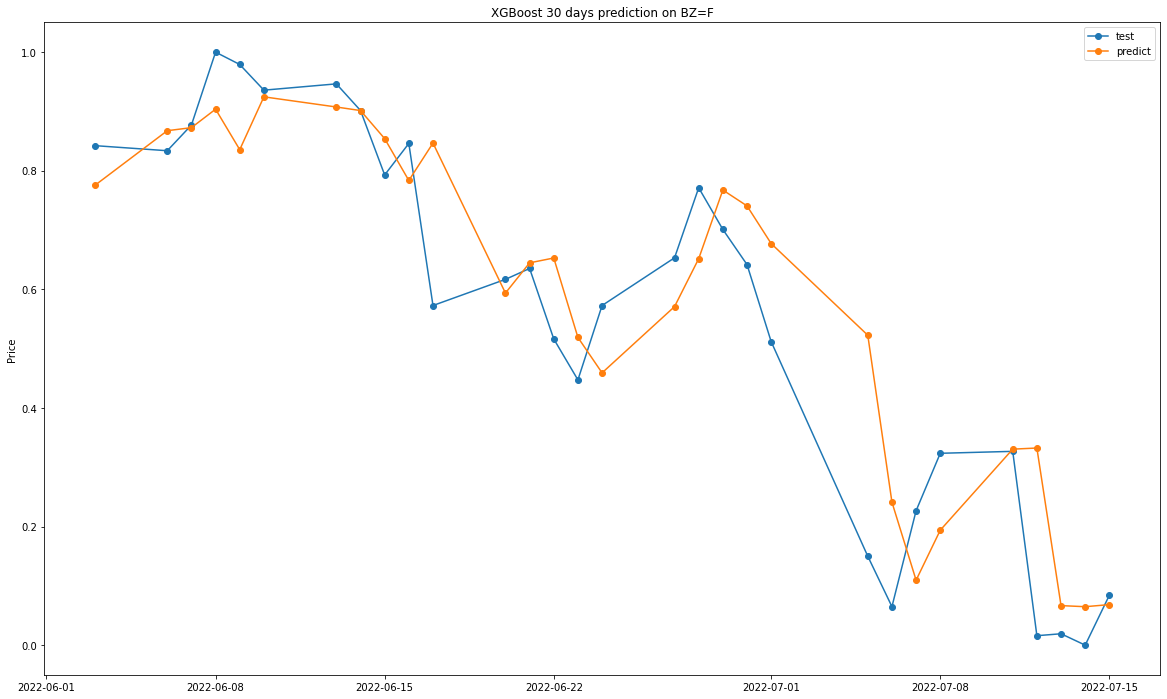

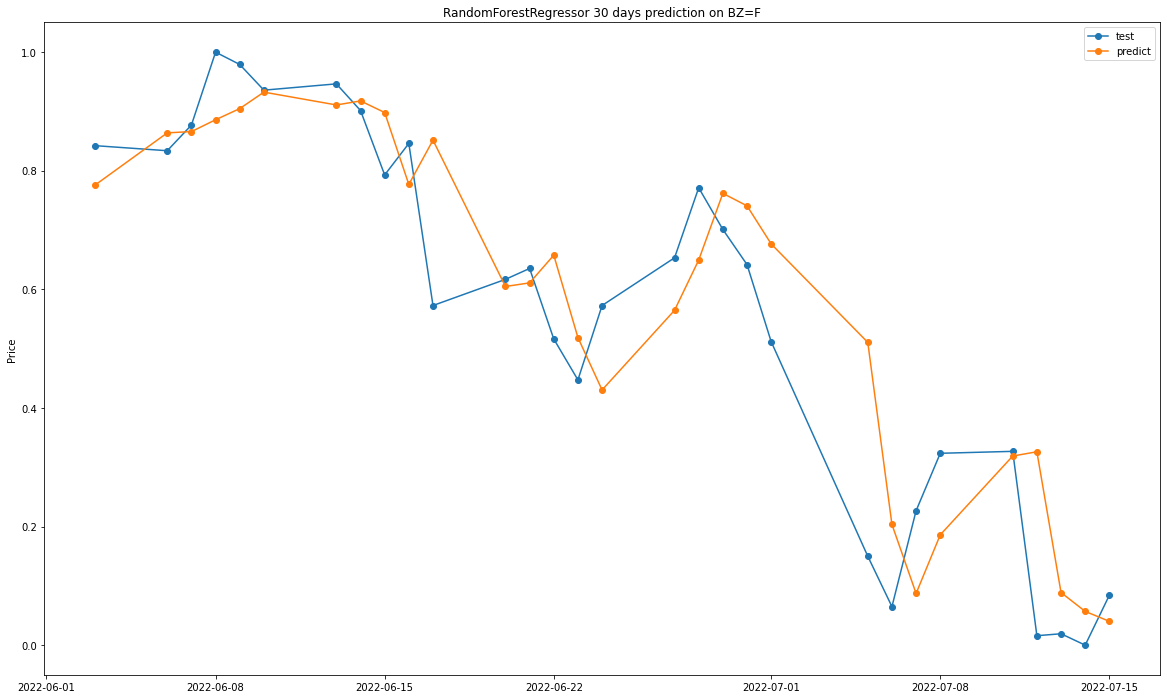

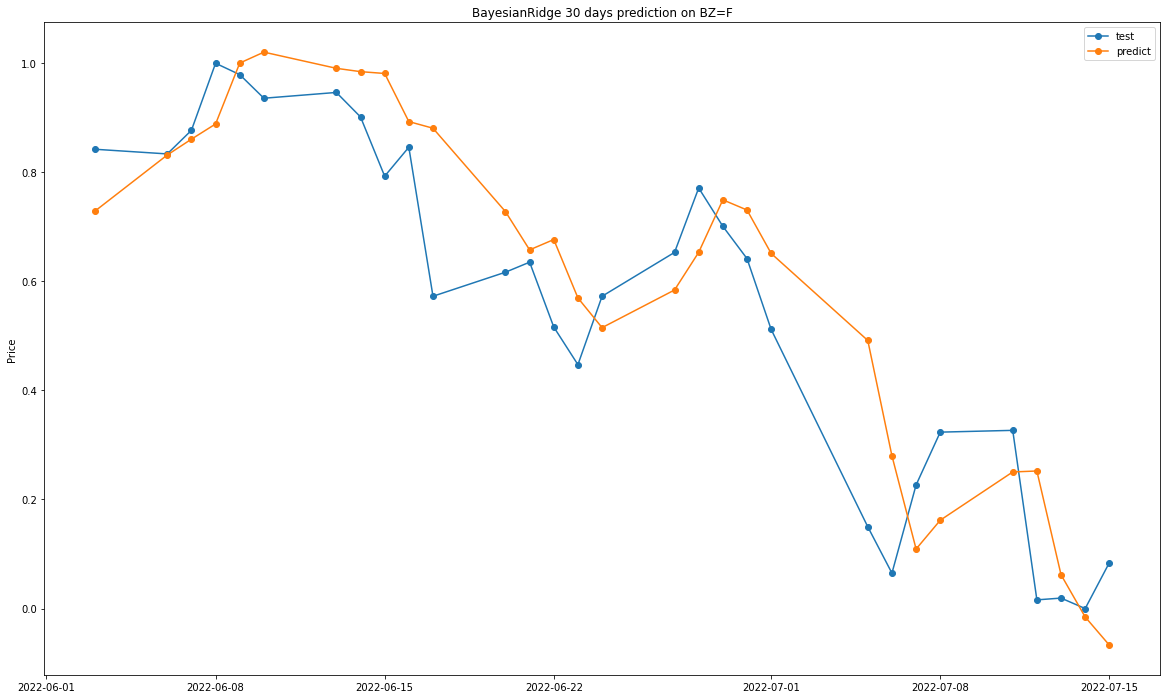

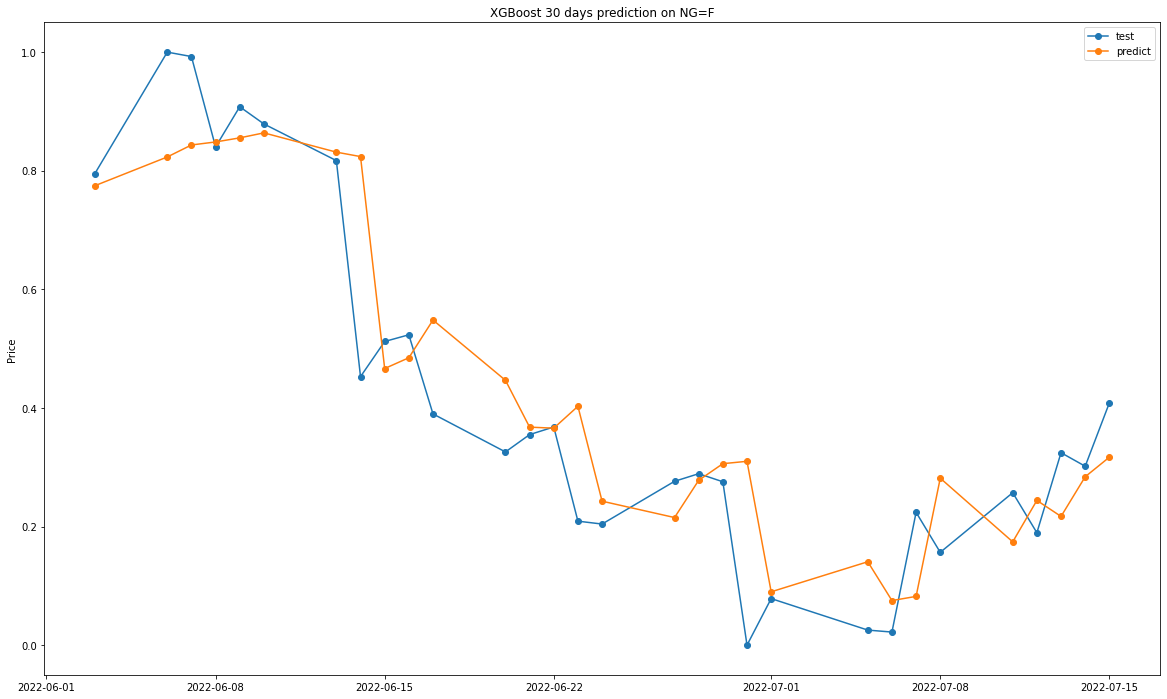

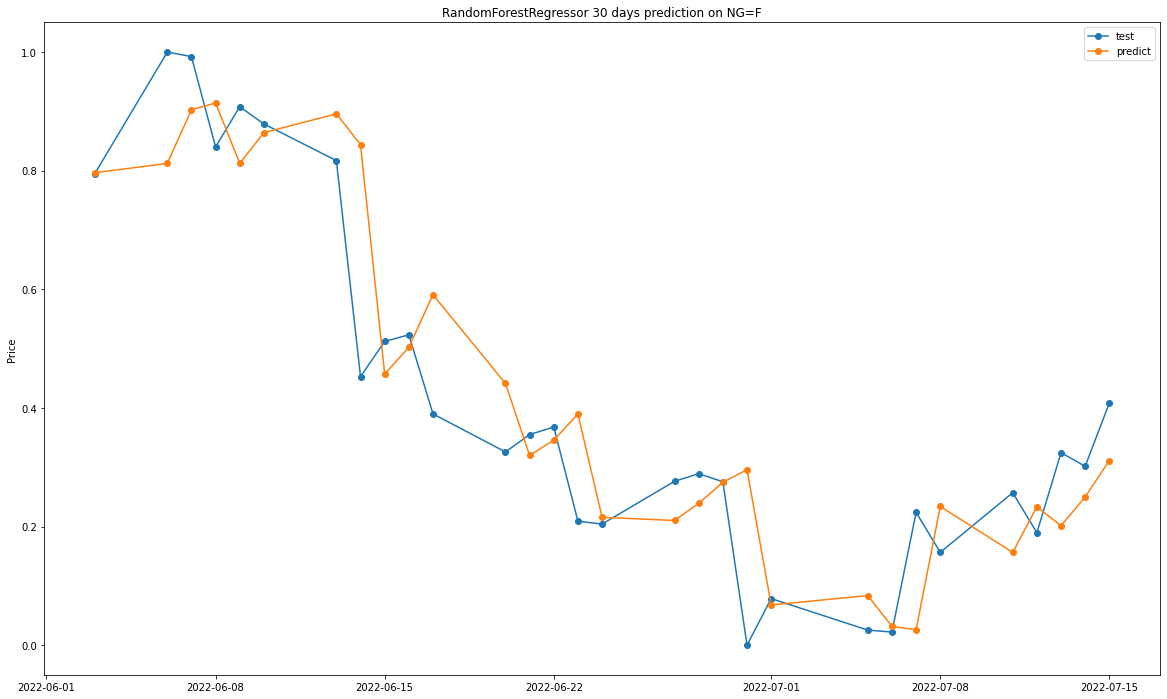

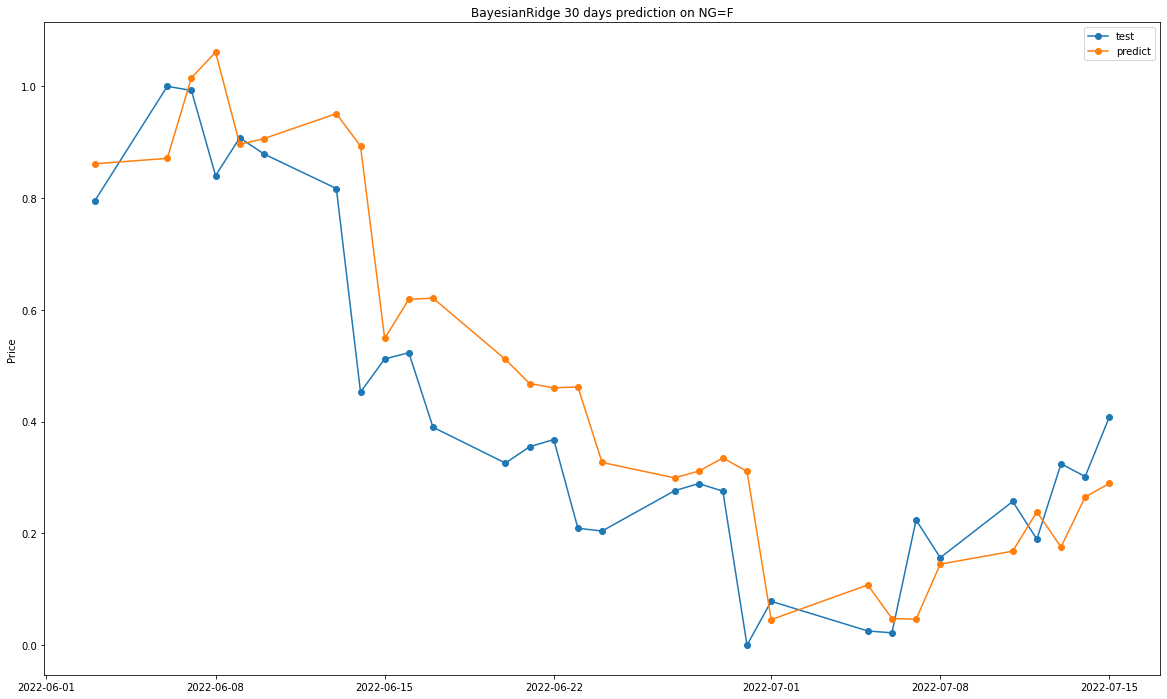

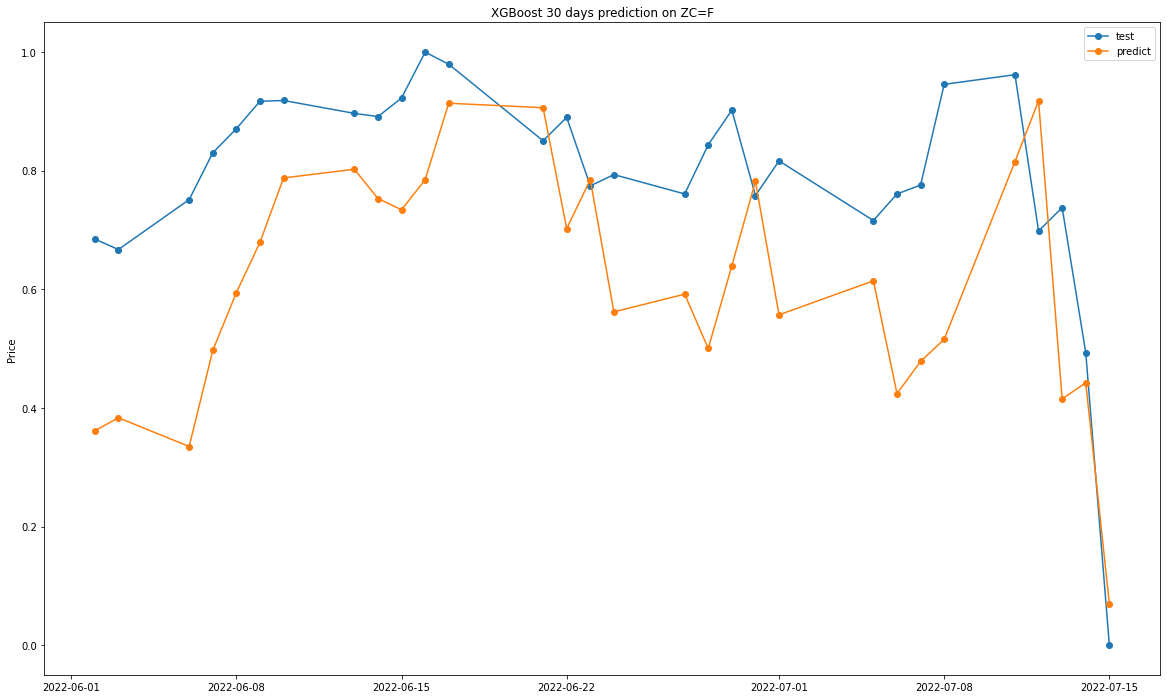

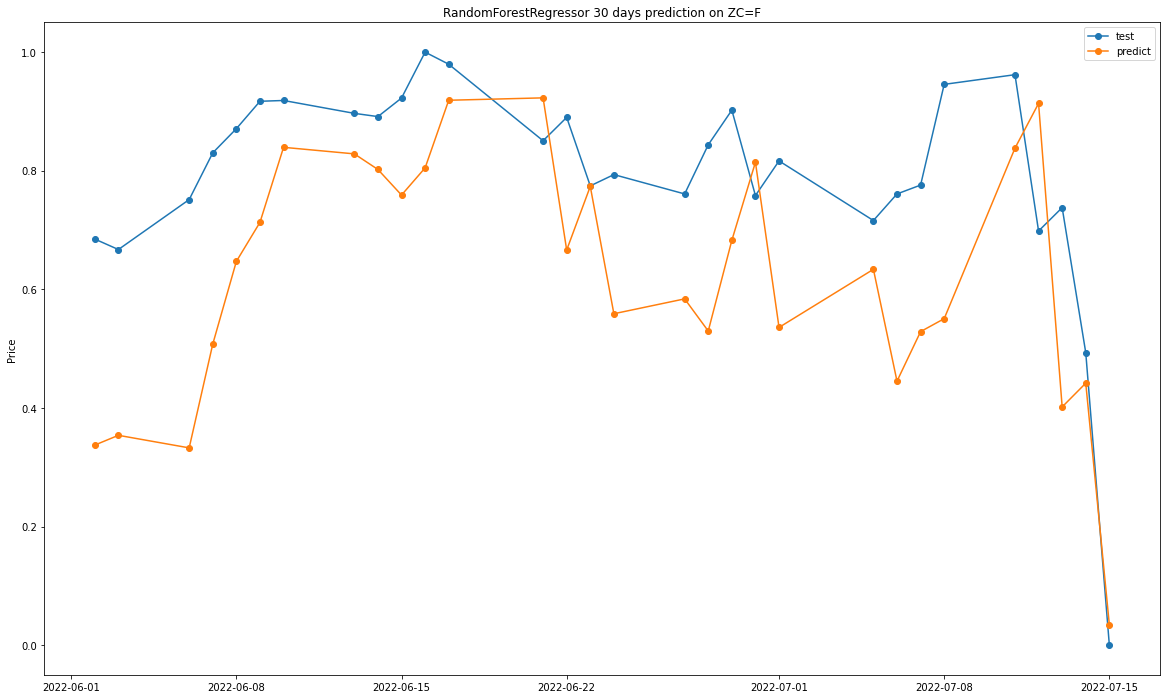

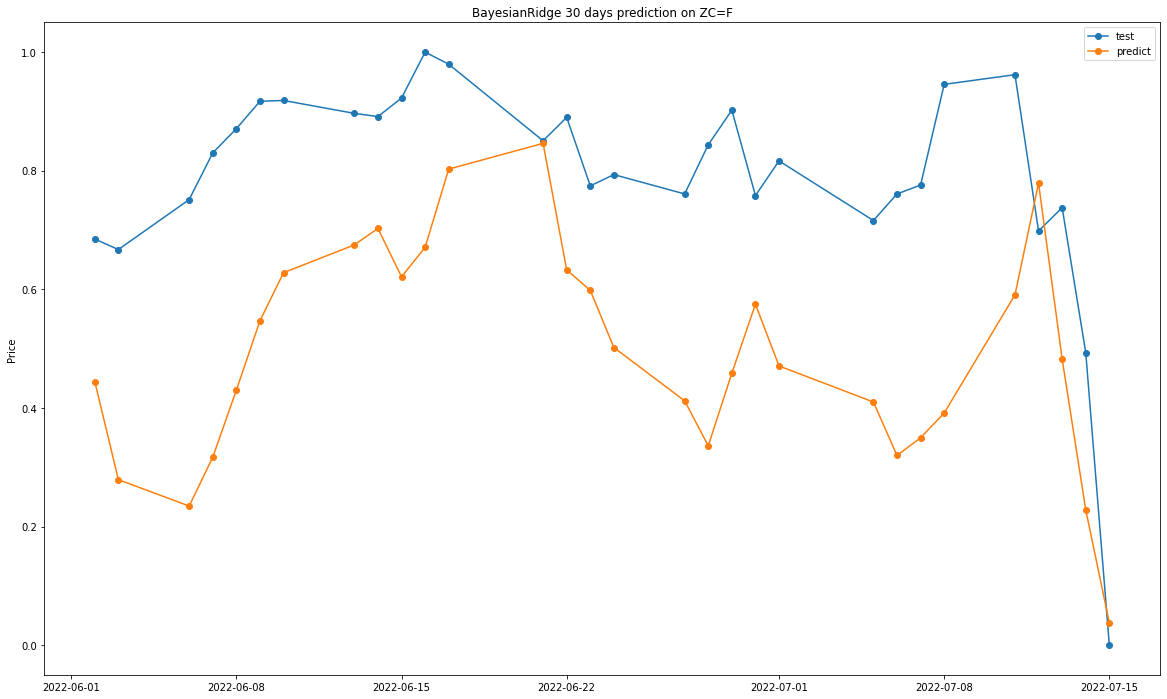

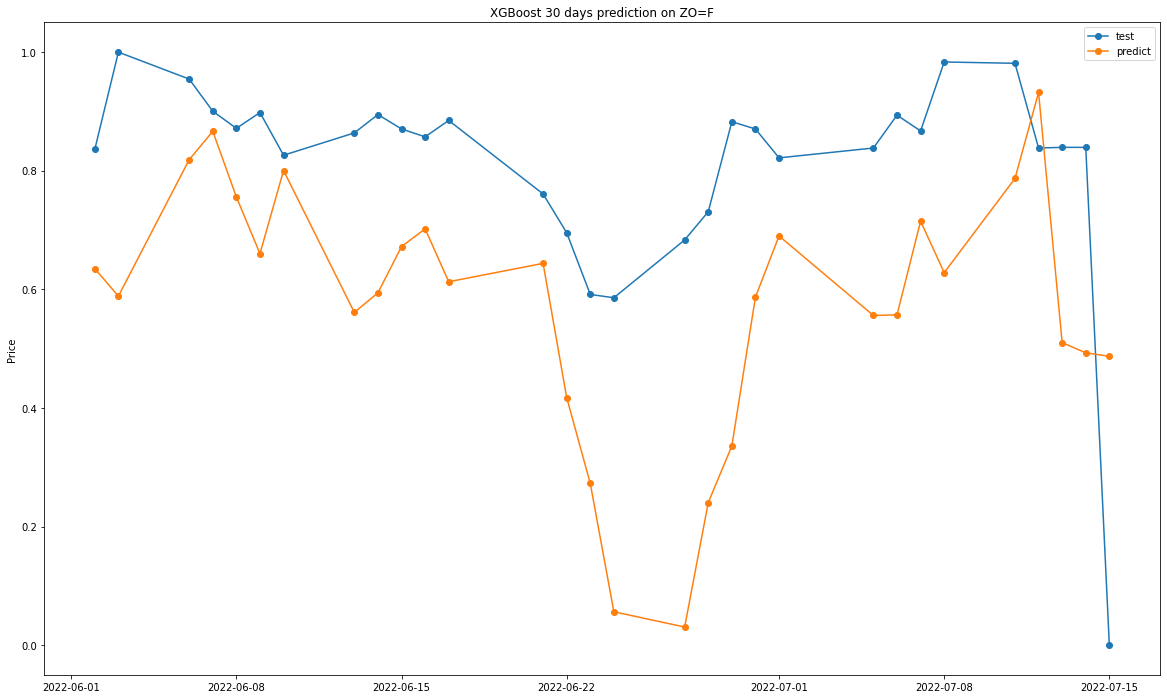

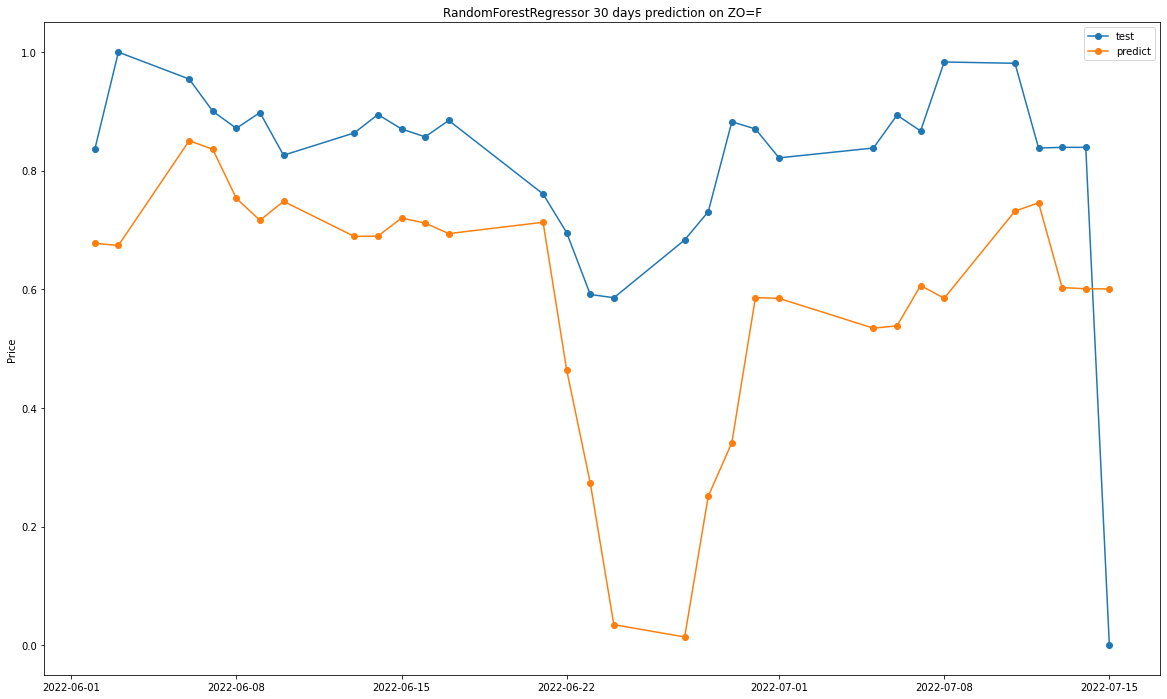

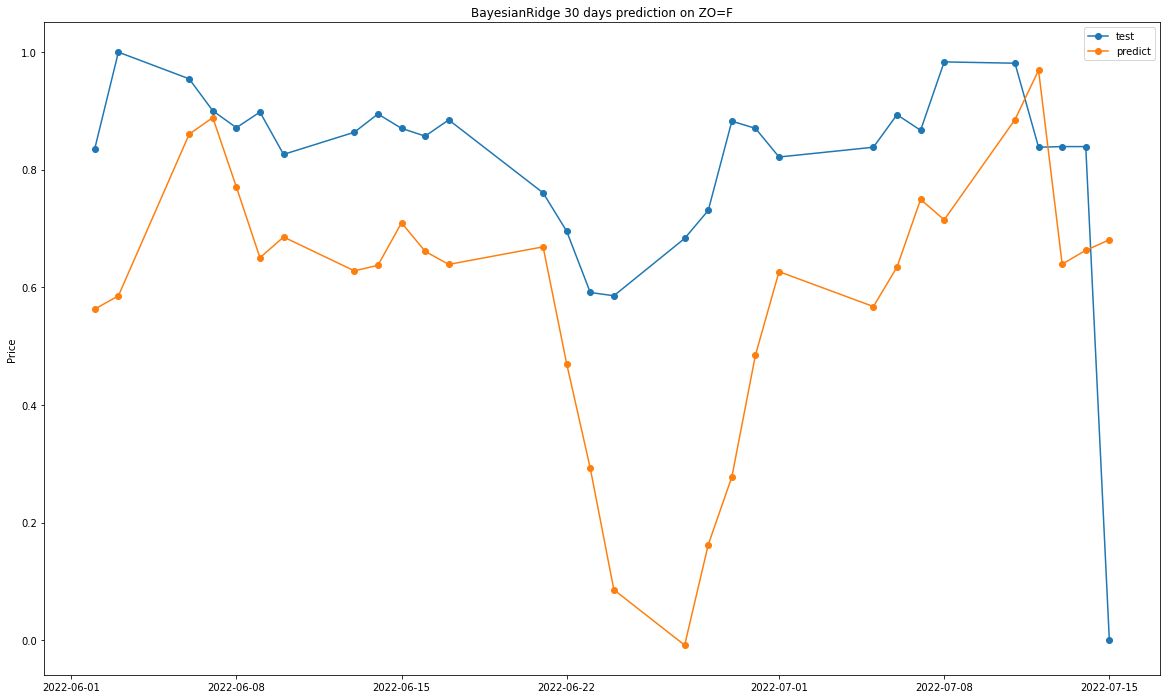

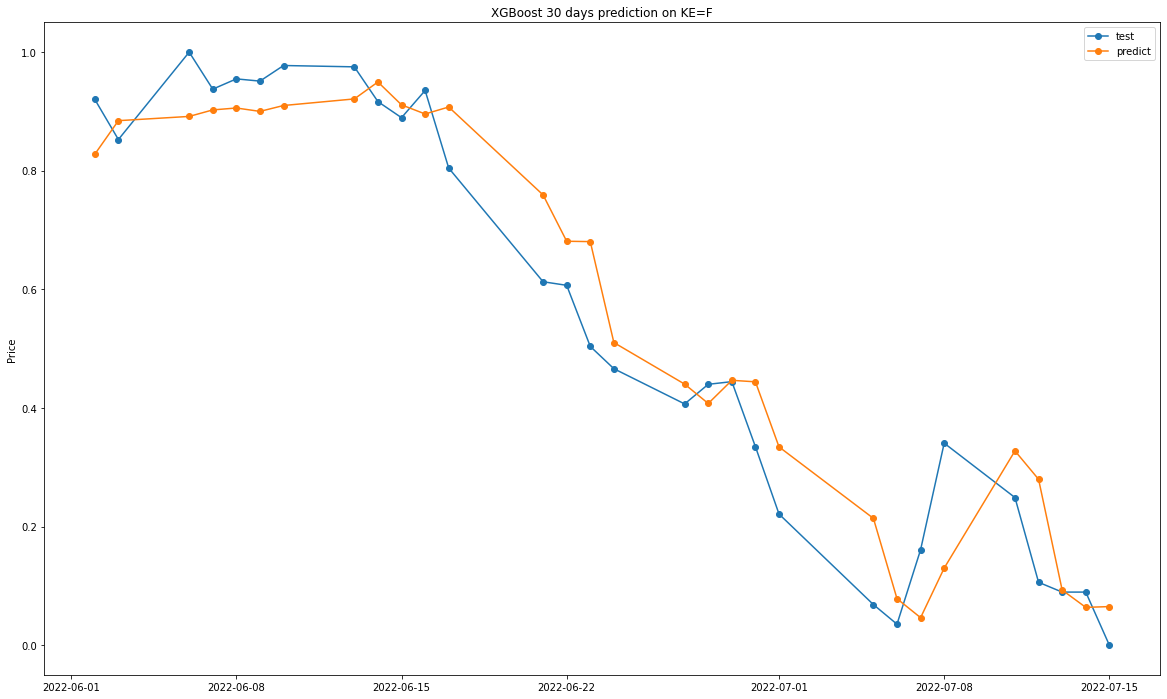

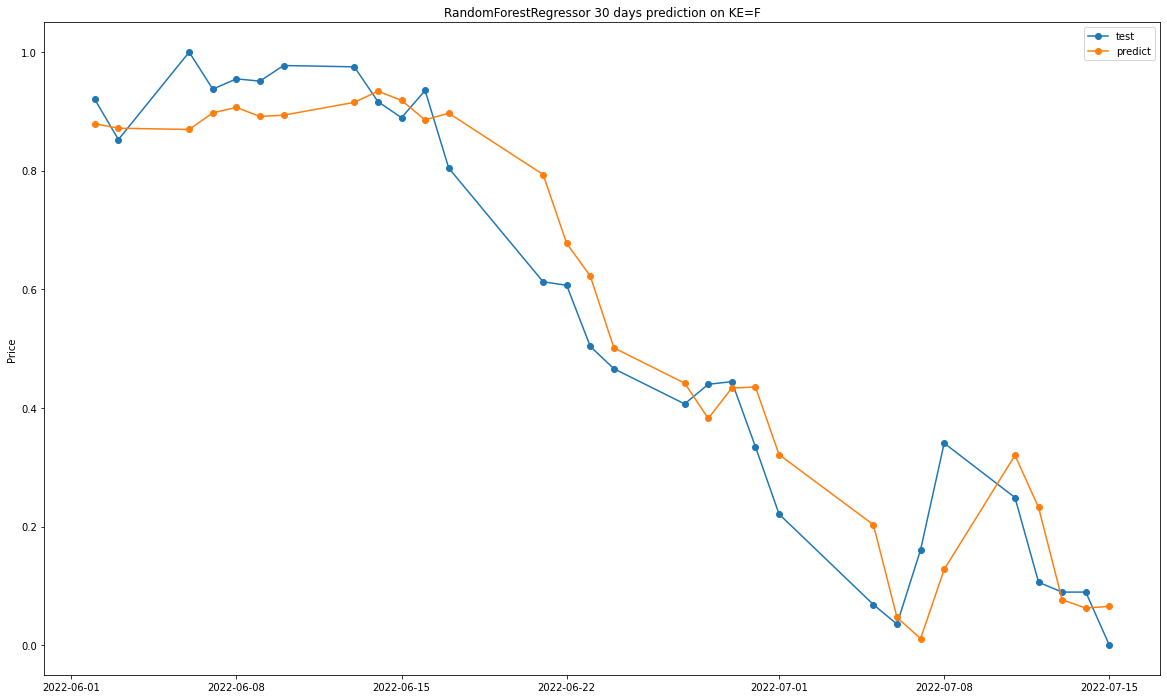

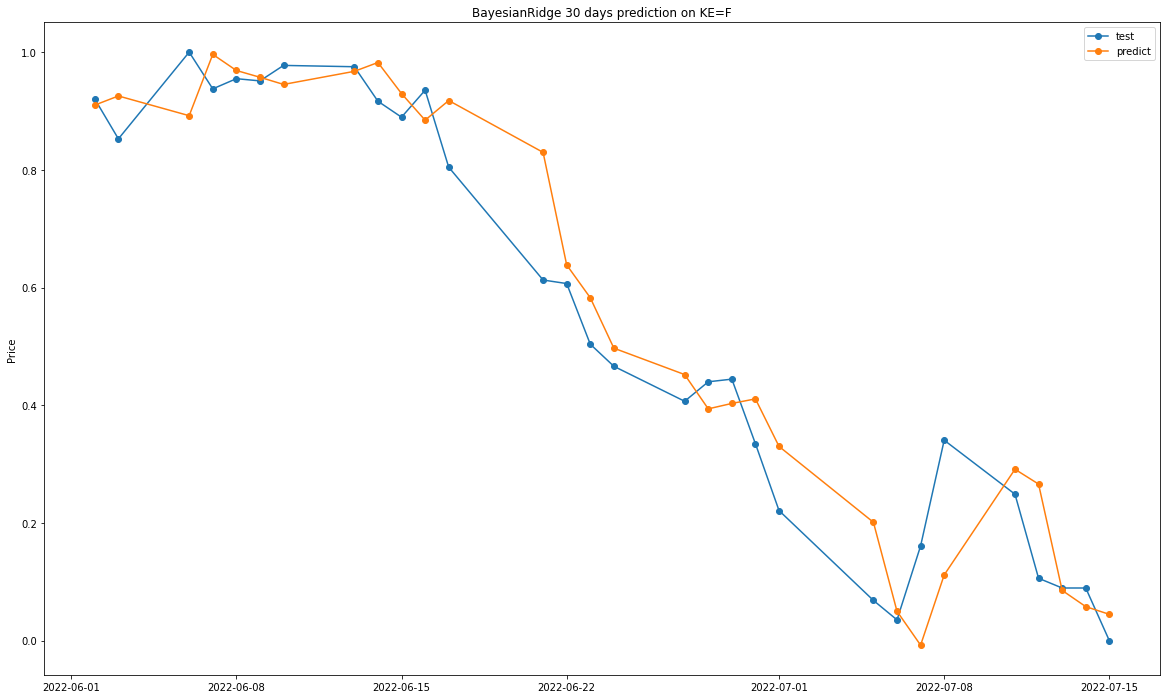

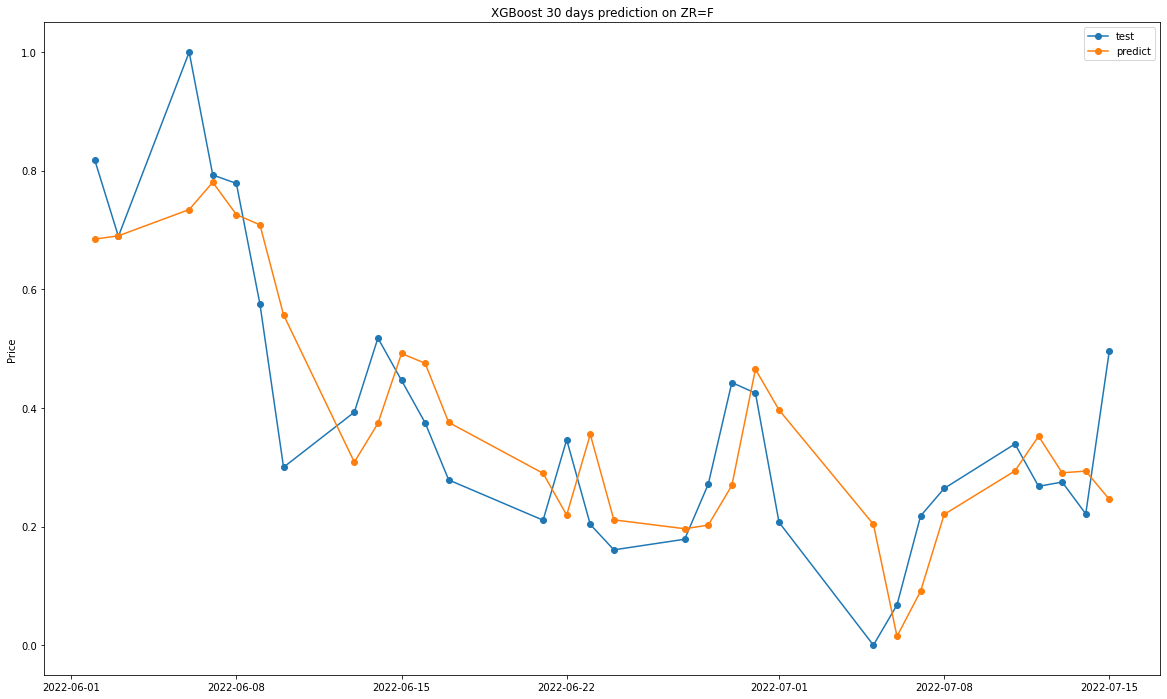

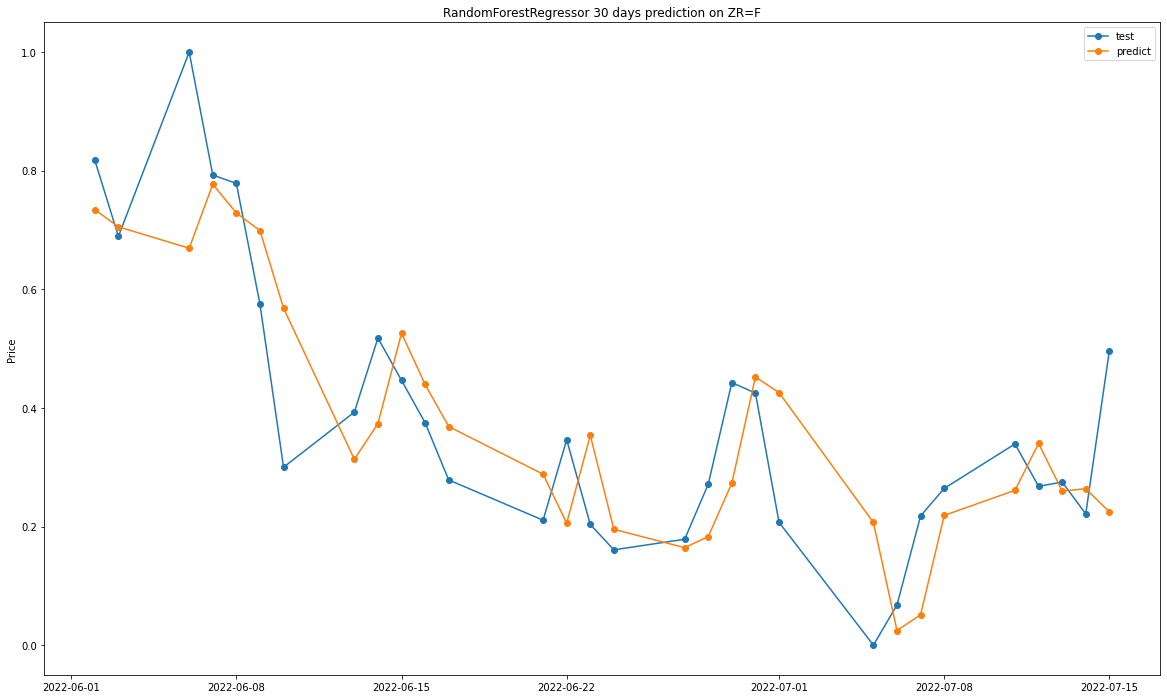

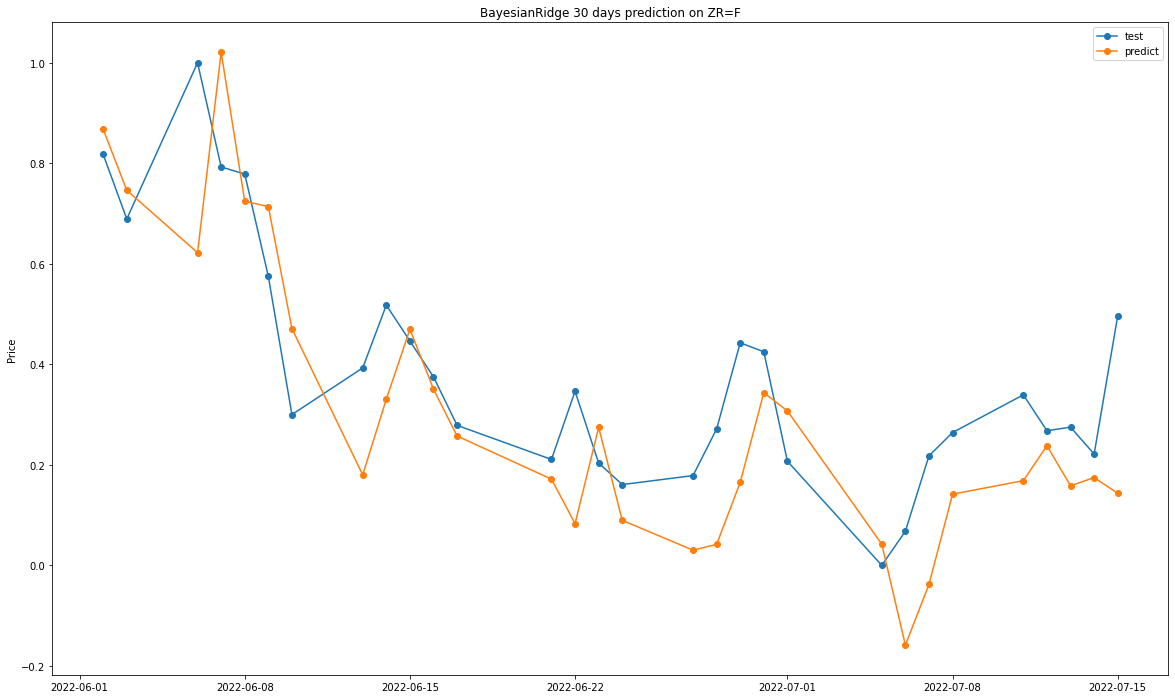

In [19]:
stock_names = []
mdl_names = []
r2s = []
mses = []
maes = []
mapes = []
run_times = []
df_pred_mimmax = pd.DataFrame(columns=['Commodity'])
for stk, data in zip(stocks, trading_datas):
    print (stk)
    if __name__ == '__main__':
        stock_data = data
        STD_periods = [7]
        SMA_periods = [7, 14, 30, 50]
        SMA_envelope_range_percentage = 5
        EMA_period = 8
        MACD_shortPeriod = 12
        MACD_longPeriod = 26
        MACD_signalPeriod = 9
        RSI_period = 14
        Stoch_periods = [14, 14, 14, 14] #RSI, StochRSI, %K(max), %D(min)
        KDJ_periods = [14, 14]
        
        tis = Technical_Indicators(stock_data, STD_periods, SMA_periods, SMA_envelope_range_percentage, EMA_period, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod, RSI_period, Stoch_periods, KDJ_periods)
        stock_results = tis.main()
        result_names = str(stk)
        df_technical_data = stock_results.dropna(axis=0)
        #df_technical_data = df_technical_data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
        

    prediction_days = 50
    future_days = 30
    df_data = pd.DataFrame(columns=['Close'], index = df_technical_data.tail(df_technical_data.shape[0]).index[prediction_days:len(df_technical_data)].tolist())

    for col in df_technical_data.columns: #,'SMA','MACD_Signal','RSI' 
        #print (col)
        
        #df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
        #col_nam = str(col)+str('-1')
        #df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
        if col == 'Close':
            df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
            '''
            for index_init in range(prediction_days):
                rolling_data = df_technical_data.iloc[index_init: index_init+(len(df_technical_data[col]) - prediction_days),:][col].tolist()
                col_name = str(col)+str(index_init-prediction_days)
                df_data[col_name] = rolling_data
            
        elif col == 'Open':
            df_data['Open'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Open'].tolist()
            '''
        else:
            col_nam = str(col)+str('-1')
            df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
    
    
    XGB = XGBRegressor()#num_boost_round=v1, eta=v2, max_depth=v3, gamma=v4,#early_stopping_rounds=20)
    RFR = RandomForestRegressor()
    #SGD = SGDRegressor()
    BYR = BayesianRidge()
    #LAS = Lasso()
    #SVR = svm.SVR(kernel="poly")

    models = [XGB, 
              RFR,
              #SVR,
              #SGD,
              BYR,
              #LAS
             ]
    model_names = ['XGBoost', 
                   'RandomForestRegressor',
                   #'SupportVectorRegressor',
                   #'SGDRegressor',
                   'BayesianRidge',
                   #'Lasso'
                  ]
    
    time_set_num = 1
    data_length = len(df_data)
    
    for model, mdl_name in zip(models, model_names):
        
        for i in range(1, time_set_num+1):
            df_train_period = df_data.iloc[future_days*(i-1): data_length-future_days*(time_set_num-(i-1)), :]
            df_test_period = df_data.iloc[data_length-future_days*(time_set_num-(i-1)): data_length-future_days*(time_set_num-(i)), :]
            '''
            x_train = df_train_period[df_train_period.columns.drop('Close').tolist()]
            y_train = df_train_period['Close']
            x_test = df_test_period[df_test_period.columns.drop('Close').tolist()]
            y_test = df_test_period['Close']
            '''
            scaler = MinMaxScaler(feature_range=(0,1))
            scaled_train = df_train_period.copy()
            scaled_test = df_test_period.copy()
            
            for col in df_train_period.columns:
                scaled_train[col] = scaler.fit_transform(df_train_period[col].values.reshape(-1,1))
                scaled_test[col] = scaler.fit_transform(df_test_period[col].values.reshape(-1,1))
            
            x_train = scaled_train[scaled_train.columns.drop('Close').tolist()]
            y_train = scaled_train['Close']
            x_test = scaled_test[scaled_test.columns.drop('Close').tolist()]
            y_test = scaled_test['Close']
            
            mdlst = time.time()  
            model.fit(x_train, y_train)
            scaled_predict = model.predict(x_test)
            mdled = time.time()  
            r2_scr = r2_score(y_test, scaled_predict)
            mse = mean_squared_error(y_test, scaled_predict)
            mae = mean_absolute_error(y_test, scaled_predict)
            mape = mean_absolute_percentage_error(y_test, scaled_predict)
            '''
            print (mdl_name,"'s performances:")
            print (' R^2 Score', r2_scr)
            print (' Mean Squared Error', mse)
            print (' Mean Absolute Error', mae)
            print (' Mean Absolute Percentage Error', mape)
            '''
            mdl_names.append(mdl_name)
            stock_names.append(stk)
            r2s.append(r2_scr)
            mses.append(mse)
            maes.append(mae)
            mapes.append(mape)
            run_times.append(mdled-mdlst)
            #scr_name = str(i)+str()
            #df_pred_results[scr_name]
            
            fig, ax = plt.subplots(figsize=(20,12))
            #ax.plot(y_train.index.tolist(), y_train, label='train',)
            ax.plot(y_test.index.tolist(), y_test,'o-', label='test',)
            ax.plot(y_test.index.tolist(), scaled_predict, 'o-', label='predict')
            ax.set_title(str(mdl_name)+' '+str(future_days)+' days prediction on '+str(stk))
            ax.set_ylabel('Price')
            ax.legend()
    

df_pred_mimmax['Model'] = mdl_names
df_pred_mimmax['Commodity'] = stock_names
df_pred_mimmax['R^2'] = r2s
df_pred_mimmax['MSE'] = mses
df_pred_mimmax['MAE'] = maes
df_pred_mimmax['MAPE'] = mapes
df_pred_mimmax['Running Time'] = run_times
print (df_pred_mimmax)


## LSTM

GC=F
Epoch 1/100
58/58 [==============================] - 8s 48ms/step - loss: 0.0272
Epoch 2/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0034
Epoch 3/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0031
Epoch 4/100
58/58 [==============================] - 3s 46ms/step - loss: 0.0024
Epoch 5/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0024
Epoch 6/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0023
Epoch 7/100
58/58 [==============================] - 3s 43ms/step - loss: 0.0022
Epoch 8/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0021
Epoch 9/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0021
Epoch 10/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0021
Epoch 11/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0020
Epoch 12/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0024
Epoch 13/100
58/58 [

Epoch 99/100
58/58 [==============================] - 3s 45ms/step - loss: 8.5446e-04
Epoch 100/100
58/58 [==============================] - 3s 44ms/step - loss: 8.2982e-04
 R^2 Score 0.8920545916793348
 Mean Squared Error 0.009609619350383623
 Mean Absolute Error 0.0710075376139357
 Mean Absolute Percentage Error 12122715202082.393
SI=F
Epoch 1/100
58/58 [==============================] - 7s 47ms/step - loss: 0.0095
Epoch 2/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0018
Epoch 3/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0017
Epoch 4/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0014
Epoch 5/100
58/58 [==============================] - 3s 48ms/step - loss: 0.0014
Epoch 6/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0014
Epoch 7/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0015
Epoch 8/100
58/58 [==============================] - 3s 46ms/step - loss: 0.0013
Epoch 9/100


58/58 [==============================] - 3s 46ms/step - loss: 5.7806e-04
Epoch 94/100
58/58 [==============================] - 3s 45ms/step - loss: 5.8991e-04
Epoch 95/100
58/58 [==============================] - 3s 45ms/step - loss: 5.5847e-04
Epoch 96/100
58/58 [==============================] - 3s 45ms/step - loss: 6.3637e-04
Epoch 97/100
58/58 [==============================] - 3s 44ms/step - loss: 6.0674e-04
Epoch 98/100
58/58 [==============================] - 3s 44ms/step - loss: 5.5197e-04
Epoch 99/100
58/58 [==============================] - 3s 45ms/step - loss: 6.3351e-04
Epoch 100/100
58/58 [==============================] - 3s 44ms/step - loss: 5.5193e-04
 R^2 Score 0.8868459198082947
 Mean Squared Error 0.010922663920517526
 Mean Absolute Error 0.09001846910927395
 Mean Absolute Percentage Error 3700018136132.4956
HG=F
Epoch 1/100
58/58 [==============================] - 7s 45ms/step - loss: 0.0227
Epoch 2/100
58/58 [==============================] - 3s 45ms/step - loss: 0

58/58 [==============================] - 3s 44ms/step - loss: 9.7883e-04
Epoch 90/100
58/58 [==============================] - 3s 43ms/step - loss: 8.2967e-04
Epoch 91/100
58/58 [==============================] - 3s 44ms/step - loss: 8.2325e-04
Epoch 92/100
58/58 [==============================] - 3s 45ms/step - loss: 8.8688e-04
Epoch 93/100
58/58 [==============================] - 3s 46ms/step - loss: 8.1961e-04
Epoch 94/100
58/58 [==============================] - 3s 45ms/step - loss: 7.9867e-04
Epoch 95/100
58/58 [==============================] - 3s 44ms/step - loss: 7.9950e-04
Epoch 96/100
58/58 [==============================] - 3s 44ms/step - loss: 7.4121e-04
Epoch 97/100
58/58 [==============================] - 3s 45ms/step - loss: 8.5844e-04
Epoch 98/100
58/58 [==============================] - 3s 44ms/step - loss: 7.7410e-04
Epoch 99/100
58/58 [==============================] - 3s 45ms/step - loss: 7.1817e-04
Epoch 100/100
58/58 [==============================] - 3s 45ms/step

58/58 [==============================] - 2s 37ms/step - loss: 5.3534e-04
Epoch 86/100
58/58 [==============================] - 2s 37ms/step - loss: 5.3953e-04
Epoch 87/100
58/58 [==============================] - 3s 43ms/step - loss: 5.0246e-04
Epoch 88/100
58/58 [==============================] - 2s 36ms/step - loss: 5.1777e-04
Epoch 89/100
58/58 [==============================] - 2s 35ms/step - loss: 5.3295e-04
Epoch 90/100
58/58 [==============================] - 2s 37ms/step - loss: 4.8539e-04
Epoch 91/100
58/58 [==============================] - 2s 36ms/step - loss: 4.7700e-04
Epoch 92/100
58/58 [==============================] - 2s 36ms/step - loss: 5.1673e-04
Epoch 93/100
58/58 [==============================] - 2s 35ms/step - loss: 5.1369e-04
Epoch 94/100
58/58 [==============================] - 2s 36ms/step - loss: 4.8460e-04
Epoch 95/100
58/58 [==============================] - 2s 35ms/step - loss: 4.8738e-04
Epoch 96/100
58/58 [==============================] - 2s 37ms/step 

58/58 [==============================] - 3s 46ms/step - loss: 8.8475e-04
Epoch 82/100
58/58 [==============================] - 3s 45ms/step - loss: 8.4853e-04
Epoch 83/100
58/58 [==============================] - 3s 44ms/step - loss: 8.2468e-04
Epoch 84/100
58/58 [==============================] - 3s 45ms/step - loss: 9.2172e-04
Epoch 85/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0010
Epoch 86/100
58/58 [==============================] - 3s 46ms/step - loss: 9.3118e-04
Epoch 87/100
58/58 [==============================] - 3s 44ms/step - loss: 8.2072e-04
Epoch 88/100
58/58 [==============================] - 3s 43ms/step - loss: 9.0860e-04
Epoch 89/100
58/58 [==============================] - 3s 44ms/step - loss: 8.3396e-04
Epoch 90/100
58/58 [==============================] - 3s 44ms/step - loss: 8.0329e-04
Epoch 91/100
58/58 [==============================] - 3s 43ms/step - loss: 8.7610e-04
Epoch 92/100
58/58 [==============================] - 3s 43ms/step - lo

58/58 [==============================] - 2s 36ms/step - loss: 6.3751e-04
Epoch 67/100
58/58 [==============================] - 2s 35ms/step - loss: 5.6697e-04
Epoch 68/100
58/58 [==============================] - 2s 36ms/step - loss: 5.7139e-04
Epoch 69/100
58/58 [==============================] - 2s 37ms/step - loss: 5.6859e-04
Epoch 70/100
58/58 [==============================] - 2s 36ms/step - loss: 5.5378e-04
Epoch 71/100
58/58 [==============================] - 2s 35ms/step - loss: 5.8056e-04
Epoch 72/100
58/58 [==============================] - 2s 36ms/step - loss: 5.1474e-04
Epoch 73/100
58/58 [==============================] - 2s 36ms/step - loss: 6.0696e-04
Epoch 74/100
58/58 [==============================] - 2s 35ms/step - loss: 6.2439e-04
Epoch 75/100
58/58 [==============================] - 2s 36ms/step - loss: 5.6737e-04
Epoch 76/100
58/58 [==============================] - 2s 36ms/step - loss: 5.3827e-04
Epoch 77/100
58/58 [==============================] - 2s 35ms/step 

58/58 [==============================] - 3s 46ms/step - loss: 0.0012
Epoch 54/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0012
Epoch 55/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0013
Epoch 56/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0013
Epoch 57/100
58/58 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 58/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0013
Epoch 59/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0013
Epoch 60/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0013
Epoch 61/100
58/58 [==============================] - 3s 46ms/step - loss: 0.0015
Epoch 62/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0012
Epoch 63/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0013
Epoch 64/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0013
Epoch 65/100
58/58 [=========

58/58 [==============================] - 3s 44ms/step - loss: 6.2477e-04
Epoch 50/100
58/58 [==============================] - 3s 46ms/step - loss: 8.3347e-04
Epoch 51/100
58/58 [==============================] - 3s 50ms/step - loss: 6.1171e-04
Epoch 52/100
58/58 [==============================] - 3s 55ms/step - loss: 7.3164e-04
Epoch 53/100
58/58 [==============================] - 3s 44ms/step - loss: 5.9401e-04
Epoch 54/100
58/58 [==============================] - 3s 44ms/step - loss: 6.0330e-04
Epoch 55/100
58/58 [==============================] - 3s 44ms/step - loss: 6.1653e-04
Epoch 56/100
58/58 [==============================] - 3s 43ms/step - loss: 6.0452e-04
Epoch 57/100
58/58 [==============================] - 3s 44ms/step - loss: 5.8803e-04
Epoch 58/100
58/58 [==============================] - 3s 44ms/step - loss: 5.8220e-04
Epoch 59/100
58/58 [==============================] - 3s 45ms/step - loss: 5.9598e-04
Epoch 60/100
58/58 [==============================] - 3s 43ms/step 

58/58 [==============================] - 3s 45ms/step - loss: 5.7440e-04
Epoch 44/100
58/58 [==============================] - 3s 45ms/step - loss: 7.3071e-04
Epoch 45/100
58/58 [==============================] - 3s 43ms/step - loss: 7.8495e-04
Epoch 46/100
58/58 [==============================] - 3s 44ms/step - loss: 6.2065e-04
Epoch 47/100
58/58 [==============================] - 3s 44ms/step - loss: 5.9825e-04
Epoch 48/100
58/58 [==============================] - 3s 44ms/step - loss: 6.1716e-04
Epoch 49/100
58/58 [==============================] - 3s 44ms/step - loss: 6.0936e-04
Epoch 50/100
58/58 [==============================] - 3s 44ms/step - loss: 7.3687e-04
Epoch 51/100
58/58 [==============================] - 3s 44ms/step - loss: 7.5787e-04
Epoch 52/100
58/58 [==============================] - 3s 44ms/step - loss: 6.4466e-04
Epoch 53/100
58/58 [==============================] - 3s 45ms/step - loss: 6.0736e-04
Epoch 54/100
58/58 [==============================] - 3s 44ms/step 

58/58 [==============================] - 3s 49ms/step - loss: 0.0011
Epoch 39/100
58/58 [==============================] - 3s 46ms/step - loss: 0.0011
Epoch 40/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0012
Epoch 41/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0012
Epoch 42/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0012
Epoch 43/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0013
Epoch 44/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0011
Epoch 45/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0011
Epoch 46/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0011
Epoch 47/100
58/58 [==============================] - 3s 44ms/step - loss: 0.0012
Epoch 48/100
58/58 [==============================] - 3s 43ms/step - loss: 0.0011
Epoch 49/100
58/58 [==============================] - 3s 45ms/step - loss: 0.0010
Epoch 50/100
58/58 [=========

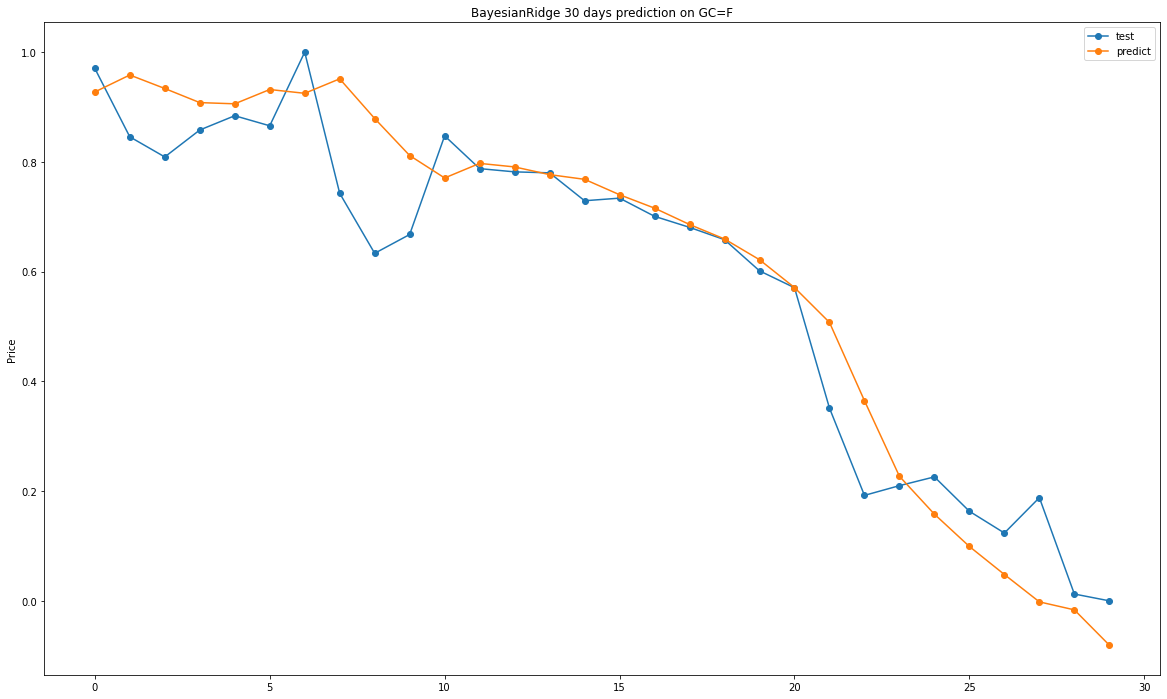

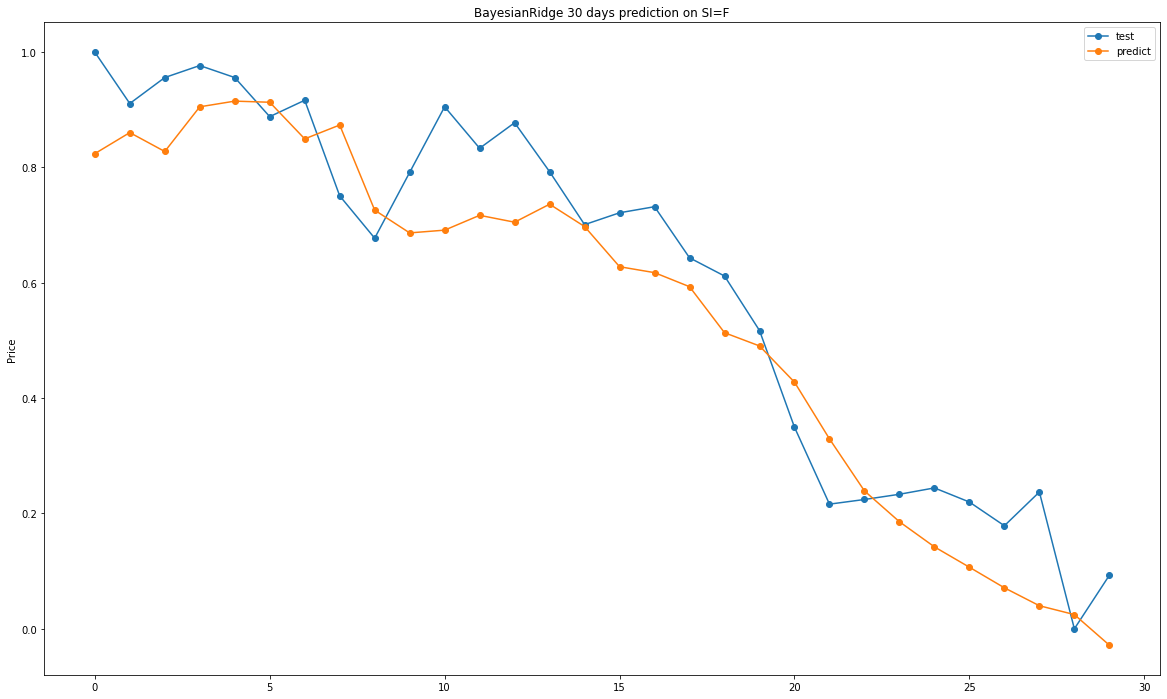

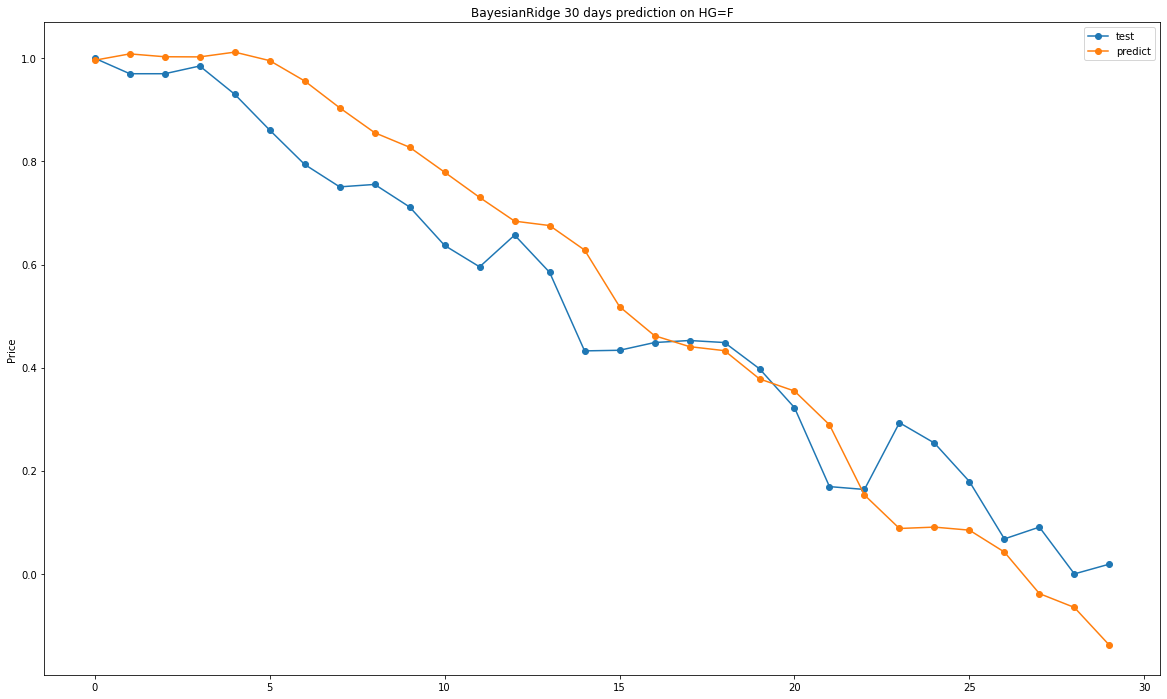

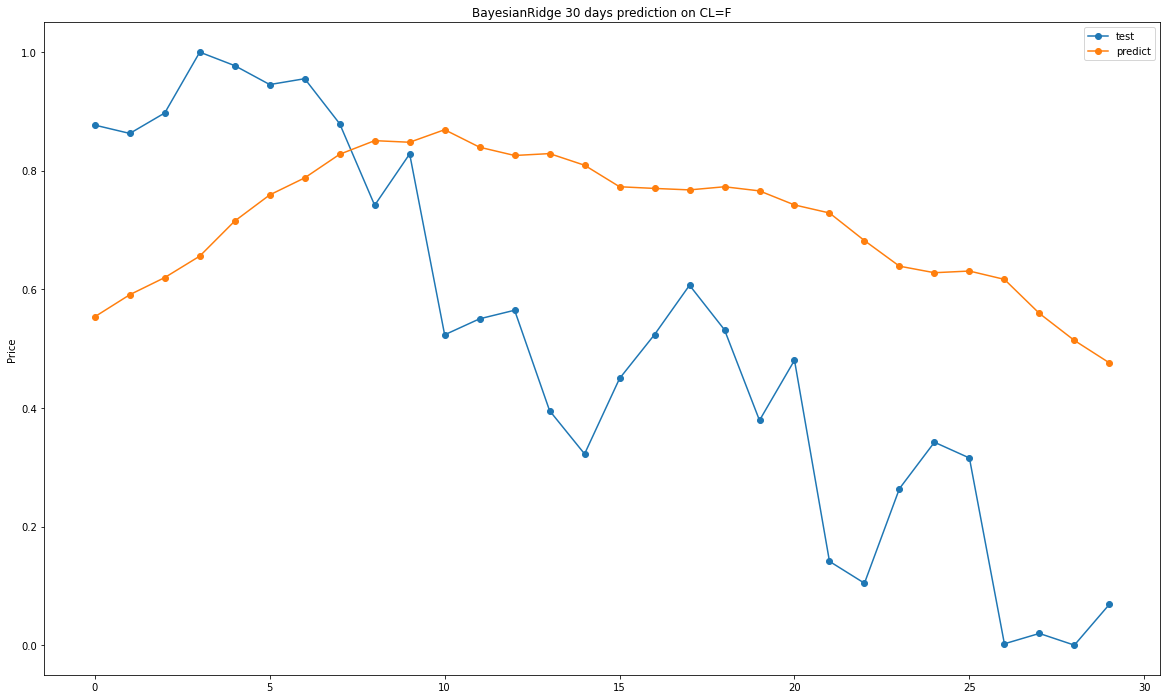

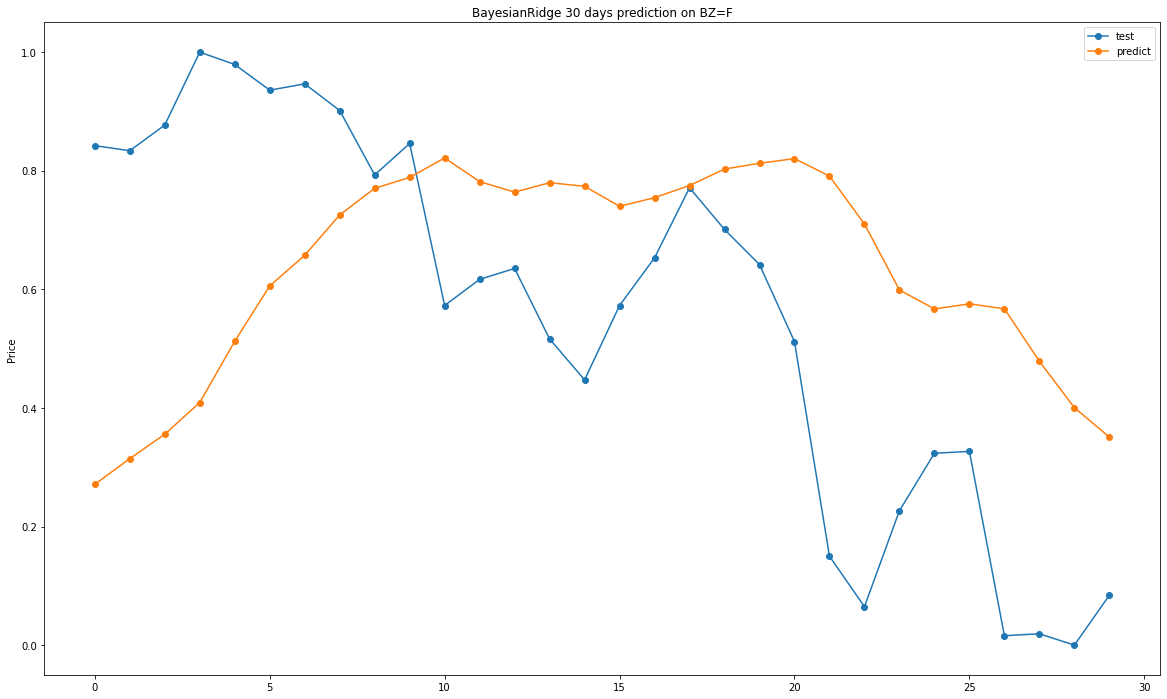

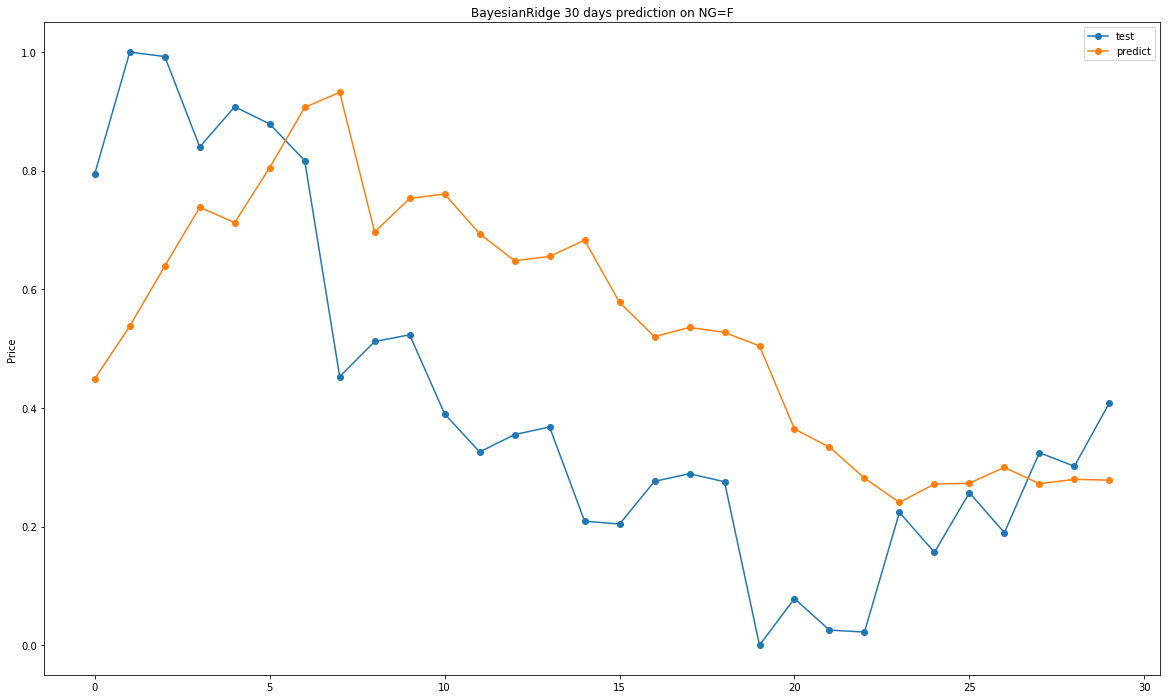

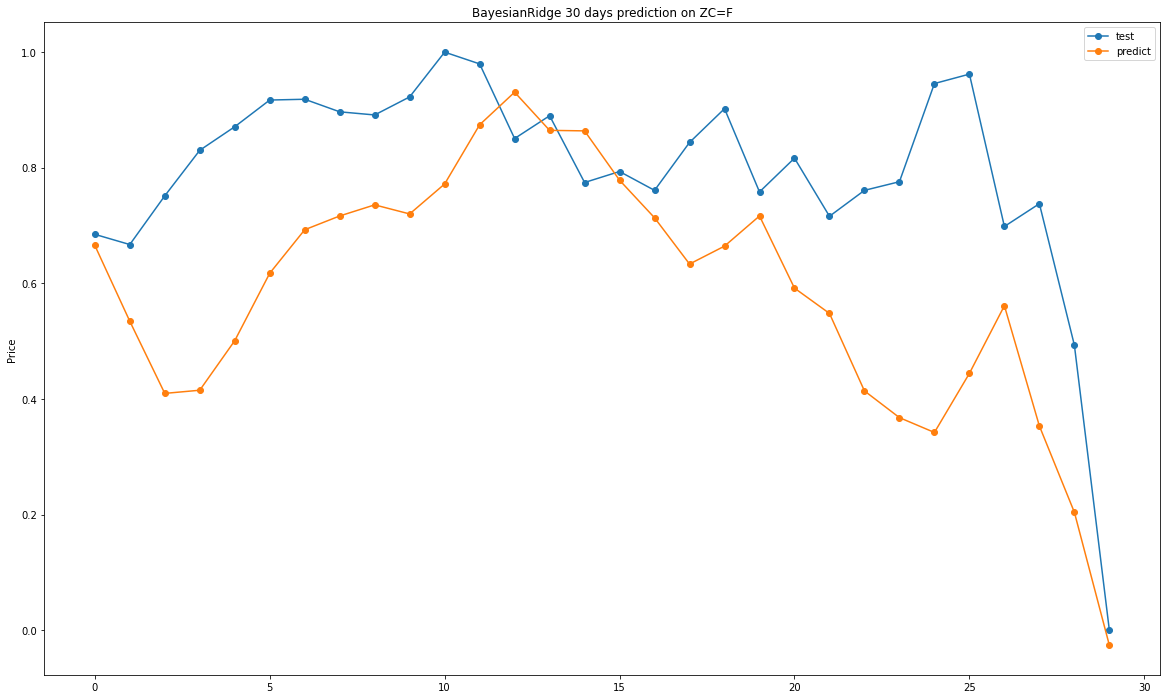

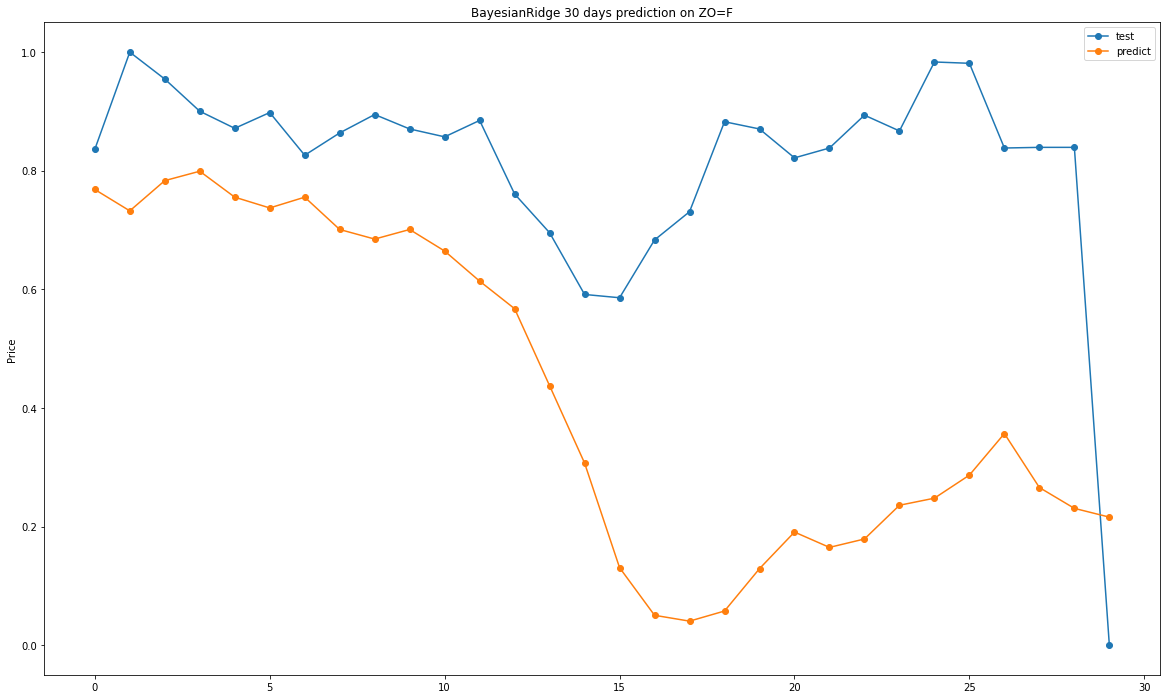

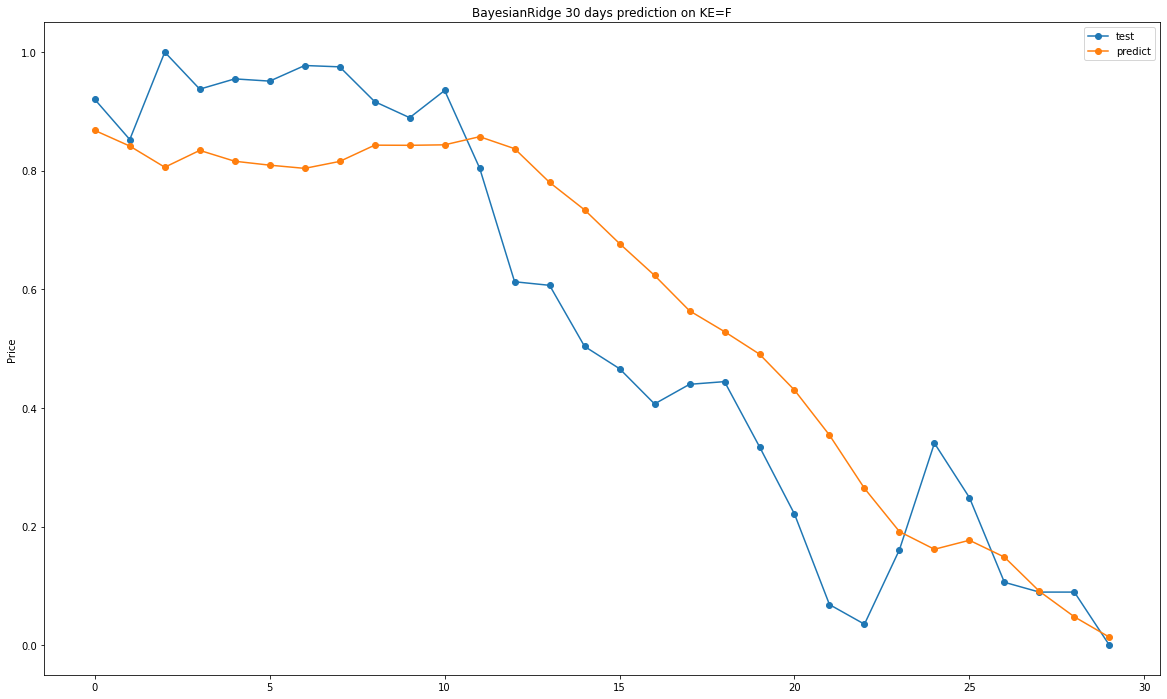

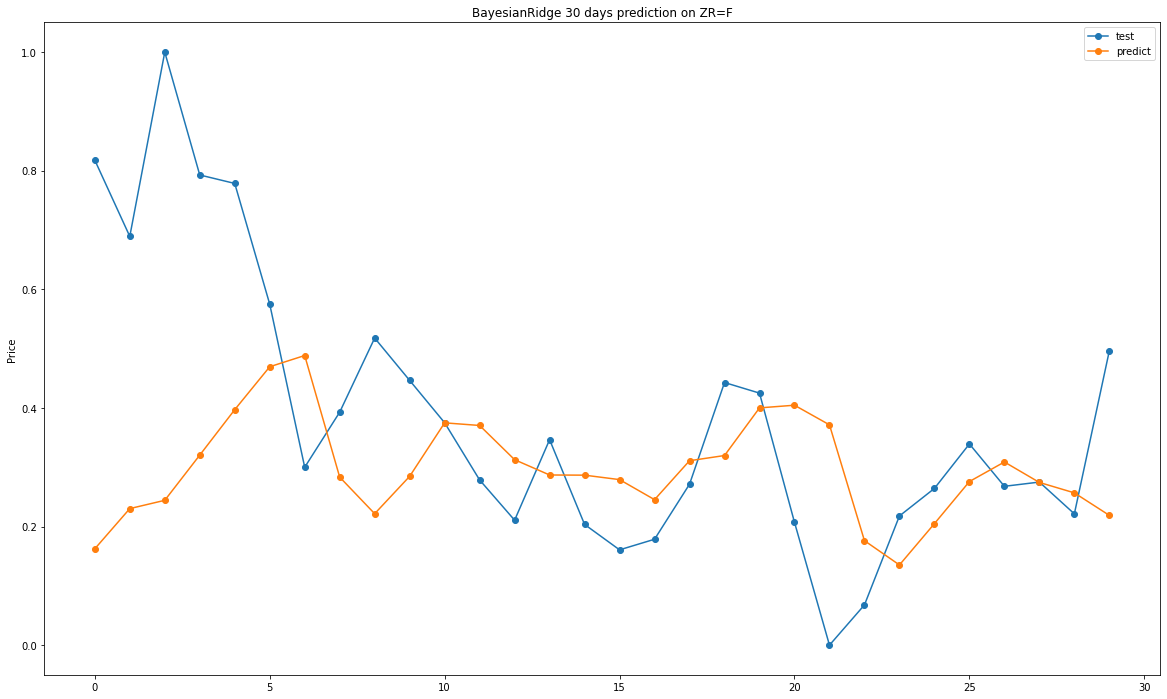

In [20]:
stock_name = []
r2s = []
mses = []
maes = []
mapes = []
running_times = []
df_pred_lstm = pd.DataFrame(columns=['Commodity'])


for stk, data in zip(stocks, trading_datas):
    print (stk)
    if __name__ == '__main__':
        stock_data = data
        STD_periods = [7]
        SMA_periods = [7, 14, 30, 50]
        SMA_envelope_range_percentage = 5
        EMA_period = 8
        MACD_shortPeriod = 12
        MACD_longPeriod = 26
        MACD_signalPeriod = 9
        RSI_period = 14
        Stoch_periods = [14, 14, 14, 14] #RSI, StochRSI, %K(max), %D(min)
        KDJ_periods = [14, 14]
        
        tis = Technical_Indicators(stock_data, STD_periods, SMA_periods, SMA_envelope_range_percentage, EMA_period, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod, RSI_period, Stoch_periods, KDJ_periods)
        stock_results = tis.main()
        result_names = str(stk)
        df_technical_data = stock_results.dropna(axis=0)
        
    prediction_days = 50
    future_days = 30
    df_data = pd.DataFrame(columns=['Close'], index = df_technical_data.tail(df_technical_data.shape[0]).index[prediction_days:len(df_technical_data)].tolist())

    for col in df_technical_data.columns: #,'SMA','MACD_Signal','RSI' 
        if col == 'Close':
            df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
        else:
            col_nam = str(col)+str('-1')
            df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
    
    time_set_num = 1
    data_length = len(df_data)
    for i in range(1, time_set_num+1):
        df_train_period = df_data.iloc[future_days*(i-1): data_length-future_days*(time_set_num-(i-1)), :]
        df_test_period = df_data.iloc[data_length-future_days*(time_set_num-(i-1)): data_length-future_days*(time_set_num-(i)), :]
            
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_train = df_train_period.copy()
        scaled_test = df_test_period.copy()
        
        for col in df_train_period.columns:
            scaled_train[col] = scaler.fit_transform(df_train_period[col].values.reshape(-1,1))
            scaled_test[col] = scaler.fit_transform(df_test_period[col].values.reshape(-1,1))
            
        x_train = scaled_train[scaled_train.columns.drop('Close').tolist()]
        y_train = scaled_train['Close']
        x_test = scaled_test[scaled_test.columns.drop('Close').tolist()]
        y_test = scaled_test['Close']        

        x_train = x_train.to_numpy()
        y_train = y_train.to_numpy()
        x_test = x_test.to_numpy()
        y_test = y_test.to_numpy()
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        
    start_t = time.time()
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=100, batch_size=50)
    scaled_predict = model.predict(x_test)
    end_t = time.time()
    
    r2_scr = r2_score(y_test, scaled_predict)
    mse = mean_squared_error(y_test, scaled_predict)
    mae = mean_absolute_error(y_test, scaled_predict)
    mape = mean_absolute_percentage_error(y_test, scaled_predict)
    print (' R^2 Score', r2_scr)
    print (' Mean Squared Error', mse)
    print (' Mean Absolute Error', mae)
    print (' Mean Absolute Percentage Error', mape)
        
    mdl_names.append(mdl_name)
    stock_name.append(stk)
    r2s.append(r2_scr)
    mses.append(mse)
    maes.append(mae)
    mapes.append(mape)
    running_times.append(end_t-start_t)
        
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot( y_test,'o-', label='test',)
    ax.plot( scaled_predict, 'o-', label='predict')
    ax.set_title(str(mdl_name)+' '+str(future_days)+' days prediction on '+str(stk))
    ax.set_ylabel('Price')
    ax.legend()

df_pred_lstm['Commodity'] = stock_name
df_pred_lstm['R^2'] = r2s
df_pred_lstm['MSE'] = mses
df_pred_lstm['MAE'] = maes
df_pred_lstm['MAPE'] = mapes
df_pred_lstm['Time'] = running_times


In [54]:
df_pred_lstm.to_excel('LSTM_Commodity_Results.xlsx')

## GA 

In [21]:
class GA(object):
    def __init__(self, population_size, chromosome_length, generations, pc, pm):
        #Parameters
        self.population_size = population_size # 20 - 100
        self.chromosome_length = chromosome_length # 
        self.generations = generations # 100 - 500
        self.pc = pc # 0.4-0.99
        self.pm = pm # 0.0001~0.1
        
    def geneEncode(self):
        pop = []
        for i in range(self.population_size):
            gene = []
            for j in range(self.chromosome_length):
                gene.append(random.randint(0, 1))
            pop.append(gene)
        return pop

    def cal_score(self, pop):
        objvalue = []
        params = []
        variable = self.decodeChromo(pop)
        v1 = []
        v2 = []
        v3 = []
        v4 = []
        v5 = []
        v6 = []
        v7 = []
        for i in range(len(variable)):
            temp_var = variable[i]
            # parameter adjustments 
            # num_boost_round
            v1 = (temp_var[0] + 1) * 10 + 100
            # eta
            cons_value = 0.19 / 31 # (0.20-0.01）/ (32 - 1)
            v2 = round((0.01 + temp_var[1] * cons_value), 2)
            # max_depth
            v3 = int(temp_var[2] + 1)
            # gamma
            v4 = round(temp_var[3] * 0.1, 1)
            # min_child_weight
            v5 = round(temp_var[4]*0.625, 1)
            # subsample
            v6 = round(temp_var[5]*0.625 * 0.1, 1)
            # colsample_bytree
            v7 = round(temp_var[6]*0.625 * 0.1, 1)

            score_val = self.model(v1, v2, v3, v4, v5, v6, v7)
            objvalue.append(score_val[0])
            params.append(score_val[1])
        return objvalue, params #目标函数值objvalue[m] 与个体基因 pop[m] 对应 

    def decodeChromo(self, pop):
        variables = []
        for i in range(len(pop)):
            res = []
            # num_boost_round
            slice1 = pop[i][0:4]
            val_1 = 0
            for v1 in range(len(slice1)):
                val_1 += slice1[v1] * (math.pow(2, v1))
            res.append(int(val_1))
            # eta
            slice2 = pop[i][4:11]
            val_2 = 0
            for v2 in range(len(slice2)):
                val_2 += slice2[v2] * (math.pow(2, v2))
            res.append(int(val_2))
            # max_depth
            slice3 = pop[i][11:14]
            val_3 = 0
            for v3 in range(len(slice3)):
                val_3 += slice3[v3] * (math.pow(2, v3))
            res.append(int(val_3))
            # gamma
            slice4 = pop[i][14:19]
            val_4 = 0
            for v4 in range(len(slice4)):
                val_4 += slice4[v4] * (math.pow(2, v4))
            res.append(int(val_4))
            # min_child_weight
            slice5 = pop[i][19:23]
            val_5 = 0
            for v5 in range(len(slice5)):
                val_5 += slice5[v5] * (math.pow(2, v5))
            res.append(int(val_5))
            # subsample
            slice6 = pop[i][23:27]
            val_6 = 0
            for v6 in range(len(slice6)):
                val_6 += slice6[v6] * (math.pow(2, v6))
            res.append(int(val_6))
            # colsample_bytree
            slice7 = pop[i][27:31]
            val_7 = 0
            for v7 in range(len(slice7)):
                val_7 += slice7[v7] * (math.pow(2, v7))
            res.append(int(val_7))

            variables.append(res)
        return variables

    def model(self, v1, v2, v3, v4, v5, v6, v7):
        train_x = x_train  
        train_y = y_train  
        val_y = y_test  
        val_x = x_test 

        model = XGBRegressor(#n_estimators=v1, 
                             learning_rate=v2, 
                             max_depth=v3, 
                             gamma=v4,
                             min_child_weight=v5,
                             subsample=v6,
                             colsample_bytree=v7
                            )

        model.fit(train_x, train_y)  
        predict_test = model.predict(val_x) 
        result_score = r2_score(val_y, predict_test)
        
        pickle.dump(model, open("xgb_temp.pkl", "wb"))
        model2 = pickle.load(open("xgb_temp.pkl", "rb"))
        assert np.allclose(model.predict(x_test), model2.predict(x_test))
        params = model2.get_xgb_params()

        return result_score, params

    def cal_fit_value(self, obj_value):
        fit_value = []
        params = []
        temp = 0.0
        Cmin = 0
        for i in range(len(obj_value[0])):
            if(obj_value[0][i] + Cmin > 0):
                temp = Cmin + obj_value[0][i]
                param = obj_value[1][i]
            else:
                temp = 0.0
                param = obj_value[1][i]
            fit_value.append(temp)
            params.append(param)
        return fit_value, params

    def best(self, pop, fit_value):
        best_individual = []
        best_fit = 0
        
        for i in range(1, len(pop)):
            if(fit_value[0][i] > best_fit):
                best_fit = fit_value[0][i]
                best_config = pop[i]
                best_params = fit_value[1][i]
                bc = [best_config, best_fit]
        return bc, best_params

    def best_decode(self, best_config):
        # 
        slice1 = best_config[0:4]
        val_1 = 0
        for v1 in range(len(slice1)):
            val_1 += slice1[v1] * (math.pow(2, v1))
        val_1 = (val_1 + 1) * 10
        # 
        slice2 = best_config[4:11]
        val_2 = 0
        for v2 in range(len(slice2)):
            val_2 += slice2[v2] * (math.pow(2, v2))
        cons_value = 0.19 / 31 # (0.20-0.01）/ (32 - 1)
        val_2 = round((0.01 + val_2 * cons_value), 2)
        #
        slice3 = best_config[11:14]
        val_3 = 0
        for v3 in range(len(slice3)):
            val_3 += slice3[v3] * (math.pow(2, v3))
        val_3 = int(val_3 + 1)
        #
        slice4 = best_config[14:19]
        val_4 = 0
        for v4 in range(len(slice4)):
            val_4 += slice4[v4] * (math.pow(2, v4))
        val_4 = round(val_4 * 0.1, 1)
        # min_child_weight
        slice5 = best_config[19:23]
        val_5 = 0
        for v5 in range(len(slice5)):
            val_5 += slice5[v5] * (math.pow(2, v5))
        val_5 = round(val_5*0.625, 1)
        # subsample
        slice6 = best_config[23:27]
        val_6 = 0
        for v6 in range(len(slice6)):
            val_6 += slice6[v6] * (math.pow(2, v6))
        val_6 = round((val_6*0.625 * 0.1), 1)
        # colsample_bytree
        slice7 = best_config[27:31]
        val_7 = 0
        for v7 in range(len(slice7)):
            val_7 += slice7[v7] * (math.pow(2, v7))
        val_7 = round((val_7*0.625 * 0.1), 1)
  
        return val_1, val_2, val_3, val_4, val_5, val_6, val_7

    def selection(self, pop, fit_value):
        # Fit value probability
        new_fit_value = []
        total_fit = 0
        for i in range(len(fit_value)):
            total_fit += fit_value[i]
        for i in range(len(fit_value)):
            new_fit_value.append(fit_value[i] / total_fit)

        # cumulated probilities of each fit value
        self.cumulated_sum(new_fit_value)

        # randomly generating float numbers
        ms = []
        pop_len = len(pop)
        for i in range(pop_len):
            ms.append(random.random())
        # sorting the float numbers
        ms.sort()
        # 轮盘赌算法（选中的个体成为下一轮，没有被选中的直接淘汰，被选中的个体代替）
        fitin = 0
        newin = 0
        newpop = pop
        while newin < pop_len:
            if(ms[newin] < new_fit_value[fitin]):
                newpop[newin] = pop[fitin]
                newin = newin + 1
            else:
                fitin = fitin + 1
        pop = newpop

    def cumulated_sum(self, fit_value):
        temp=[]
        for i in range(len(fit_value)):
            t = 0
            j = 0
            while(j <= i):
                t += fit_value[j]
                j = j + 1
            temp.append(t)
        for i in range(len(fit_value)):
            fit_value[i]=temp[i]

    def crossover(self, pop): 
        poplen = len(pop)
        for i in range(poplen - 1):
            if(random.random() < self.pc):
                cpoint = random.randint(0,len(pop[0]))
                temp1 = []
                temp2 = []
                temp1.extend(pop[i][0 : cpoint])
                temp1.extend(pop[i+1][cpoint : len(pop[i])])
                temp2.extend(pop[i+1][0 : cpoint])
                temp2.extend(pop[i][cpoint : len(pop[i])])
                pop[i] = temp1
                pop[i+1] = temp2

    def mutation(self, pop): 
        px = len(pop)
        py = len(pop[0])
        for i in range(px):
            if(random.random() < self.pm):
                mpoint = random.randint(0,py-1)
                if(pop[i][mpoint] == 1):
                    pop[i][mpoint] = 0
                else:
                    pop[i][mpoint] = 1
                    
    def plot_GA(self, result):
        X = []
        Y = []
        for i in range(len(result)):
            X.append(i + 1)
            Y.append(result[i])
        plt.plot(X,Y)
        plt.xlabel('Number of iteration',size = 15)
        plt.ylabel('Value of R2',size = 15)
        plt.title('GA_XGBoost parameter optimization')
        plt.show() 
        
    def plot_performance():
        fig, ax = plt.subplots(figsize=(20,12))
        ax.plot([i for i in range(len(best_predict_test))],y_test,label='test')
        ax.plot([i for i in range(len(best_predict_test))],best_predict_test,label='predict')
        ax.set_ylabel('Price')
        ax.legend()

    def main(self):
        
        result_scores = []
        result_parameters = []
        iter_times = []
        
        init_start = time.time()
        mod_init = XGBRegressor()#num_boost_round=v1, eta=v2, max_depth=v3, gamma=v4,#early_stopping_rounds=20)
        mod_init.fit(x_train, y_train)
        init_predict_test = mod_init.predict(x_test) 
        init_result_score = r2_score(y_test, init_predict_test)
        init_end = time.time()
        
        pickle.dump(mod_init, open("xgb_temp.pkl", "wb"))
        mod_init2 = pickle.load(open("xgb_temp.pkl", "rb"))
        assert np.allclose(mod_init.predict(x_test), mod_init2.predict(x_test))
        params = mod_init2.get_xgb_params()
        for par_key in params.keys():
            if par_key == 'learning_rate':
                init_lr = params[par_key]
            elif par_key == 'max_depth':
                init_mdp = params[par_key]
            elif par_key == 'gamma':
                init_gamma = params[par_key]
            elif par_key == 'min_child_weight':
                init_min_child_weight = params[par_key]
            elif par_key == 'subsample':
                init_subsample = params[par_key]
            elif par_key == 'colsample_bytree':
                init_colsample_bytree = params[par_key]
        init_params = [init_lr, init_mdp, init_gamma, init_min_child_weight, init_subsample, init_colsample_bytree]
        
        result_scores.append(init_result_score)
        result_parameters.append(init_params)
        iter_times.append(init_end - init_start)
        
        print ('The initial score is: ', init_result_score)
        print ('The initial parameters are: ', init_params)


        total_start_time = time.time()
        population = self.geneEncode() #Generating initial population (parents) 
        for i in tqdm_notebook(range(self.generations), desc='Generation Progress'):
            #print ('Generation No.:', i)
            iter_start_time = time.time()
            obj_value = self.cal_score(population) # Object Value/ Model Score
            #print(obj_value)
            fit_value = self.cal_fit_value(obj_value) #Fit values as they always remain positive
            #print(fit_value)
            best_performance = self.best(population, fit_value)
            [best_config, best_score] = best_performance[0] #Finding the best coniguration and score
            #print (best_performance[1])
            #print("best_in/dividual: "+ str(best_individual))
            v1, v2, v3, v4, v5, v6, v7 = self.best_decode(best_config)
            result_scores.append(best_score) #Recording the best configuration generated
            result_parameters.append([v2, v3, v4, v5, v6, v7])
            #print(str(v2), str(v3), str(v4), str(v5), str(v6), str(v7) + " " + str(best_score))
            self.selection(population, fit_value[0]) 
            self.crossover(population) # crossover of gene
            self.mutation(population) # mutation of gene
            iter_end_time = time.time()
            iter_times.append(iter_end_time-iter_start_time)
        total_end_time = time.time()
        total_time = total_end_time-total_start_time

        # Result
        df_results = pd.DataFrame({'Scores': result_scores, 
                                   'Parameters': result_parameters,
                                   'Running Time': iter_times
                                  })
        df_results = df_results.sort_values('Scores', ascending=True)
        print('The best configiration and score are: ', df_results['Parameters'].tolist()[-1], df_results['Scores'].tolist()[-1])
        print('The total running time is: ', total_time)
        
        # Plot
        self.plot_GA(df_results['Scores'].tolist())
        
        return df_results


GC=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.8292667123856837
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.22, 4, 2.9, 5.0, 0.5, 0.1] 0.9071311194260451
The total running time is:  158.3756799697876


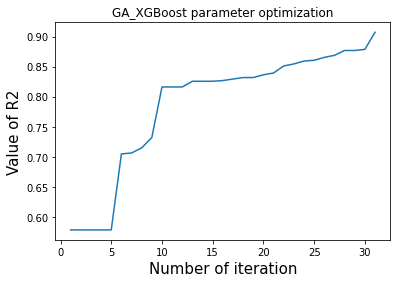

[0.22, 4, 2.9, 5.0, 0.5, 0.1]
[0.9071311194260451]


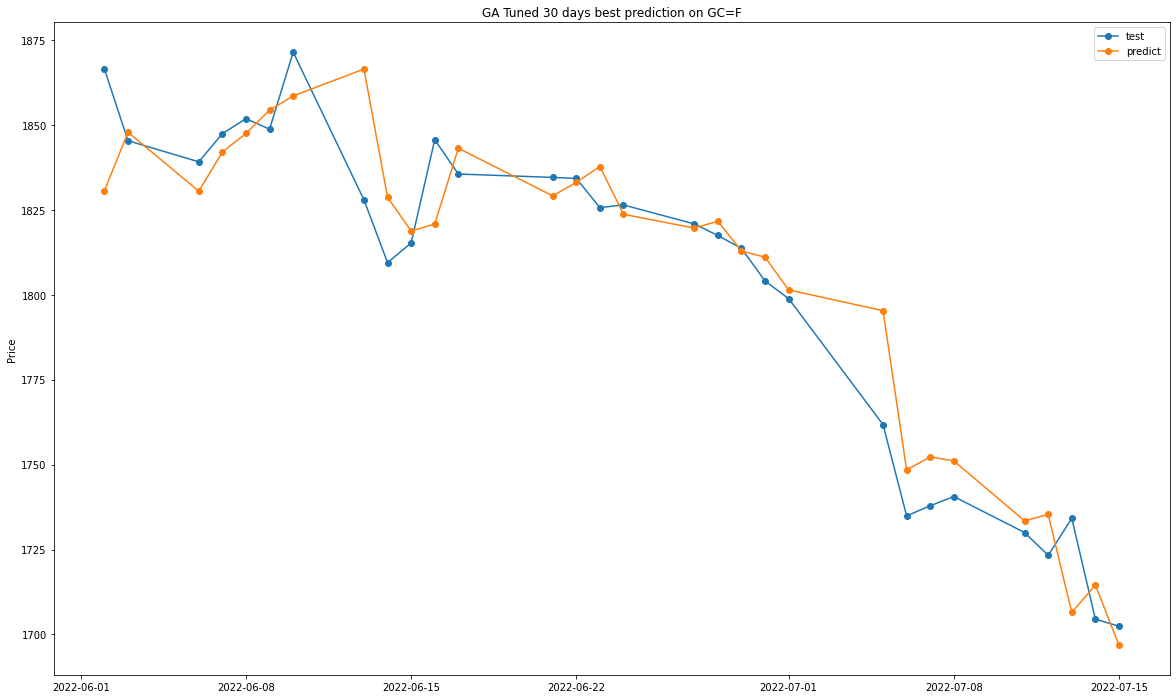

SI=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.9030090052794345
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.14, 4, 1.5, 3.8, 0.8, 0.3] 0.9280023826222009
The total running time is:  420.2903001308441


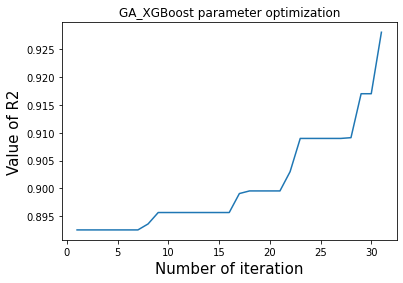

[0.14, 4, 1.5, 3.8, 0.8, 0.3]
[0.9071311194260451, 0.9280023826222009]


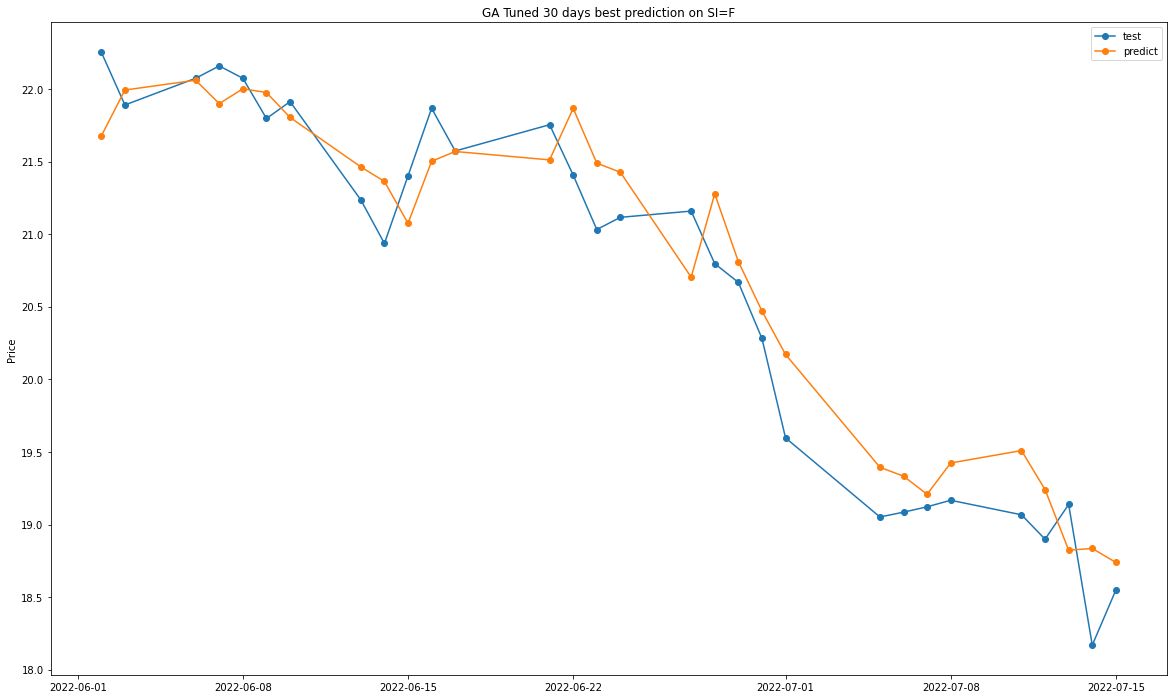

HG=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.9195510139267876
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.14, 5, 2.3, 6.2, 0.8, 0.6] 0.9633864658648267
The total running time is:  373.5784409046173


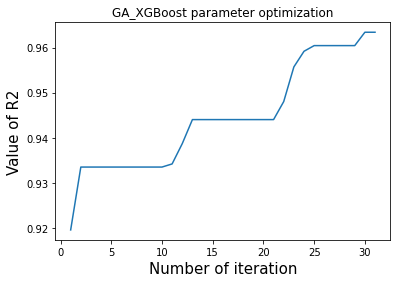

[0.14, 5, 2.3, 6.2, 0.8, 0.6]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267]


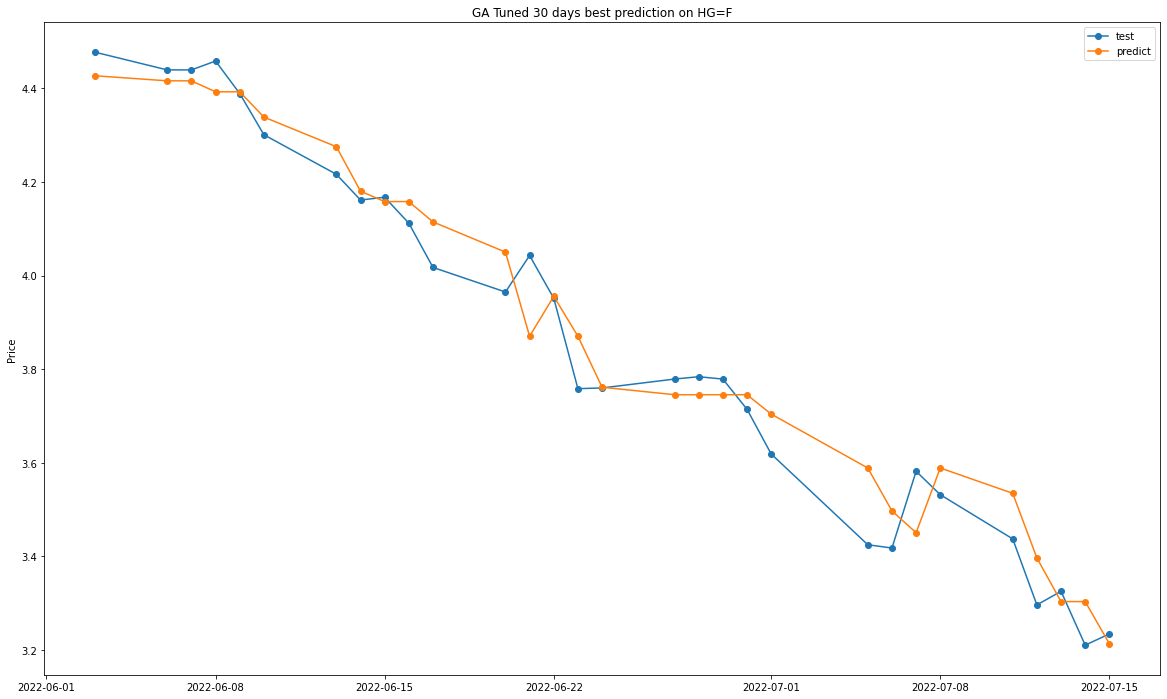

CL=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.26209752136810527
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.38, 1, 0.6, 3.8, 0.4, 0.6] 0.7080863032420288
The total running time is:  181.9709348678589


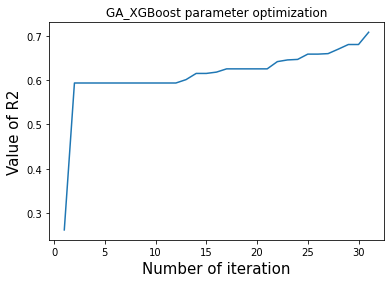

[0.38, 1, 0.6, 3.8, 0.4, 0.6]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267, 0.7080863032420288]


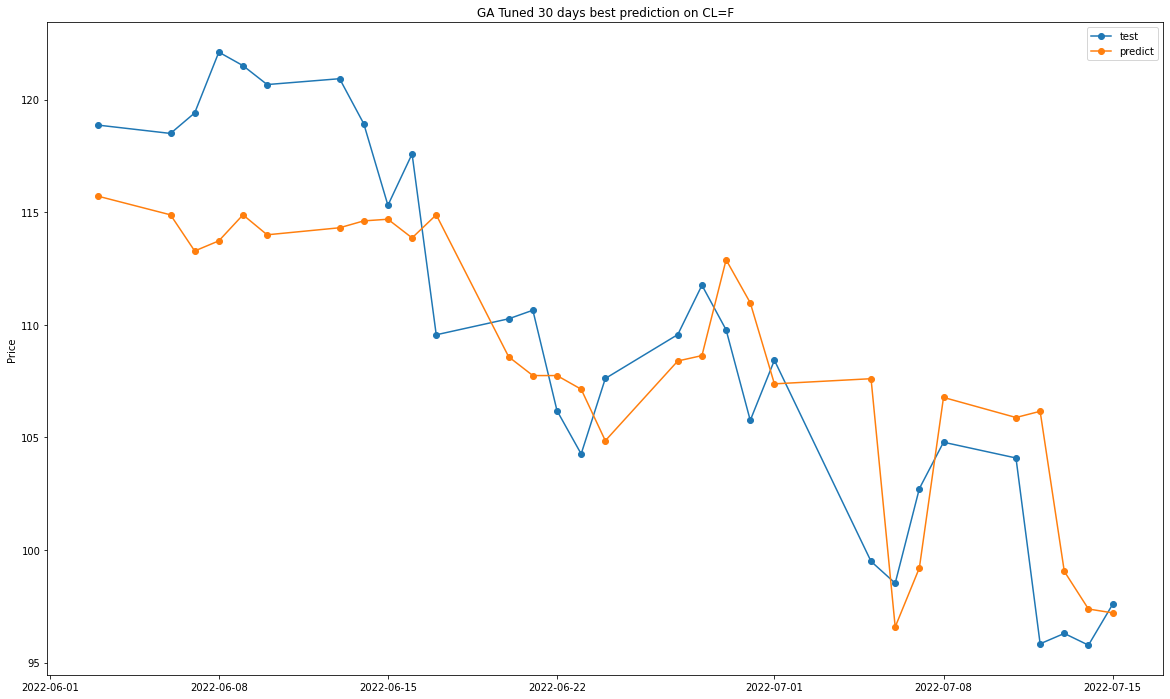

BZ=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.8064285930895196
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.29, 8, 0.0, 6.2, 0.7, 0.5] 0.8317603210438687
The total running time is:  534.3018269538879


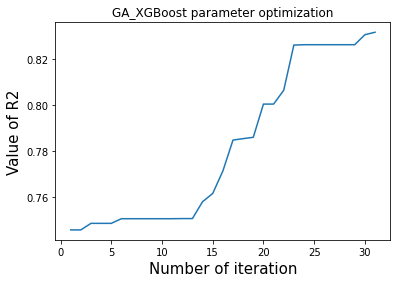

[0.29, 8, 0.0, 6.2, 0.7, 0.5]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267, 0.7080863032420288, 0.8317603210438687]


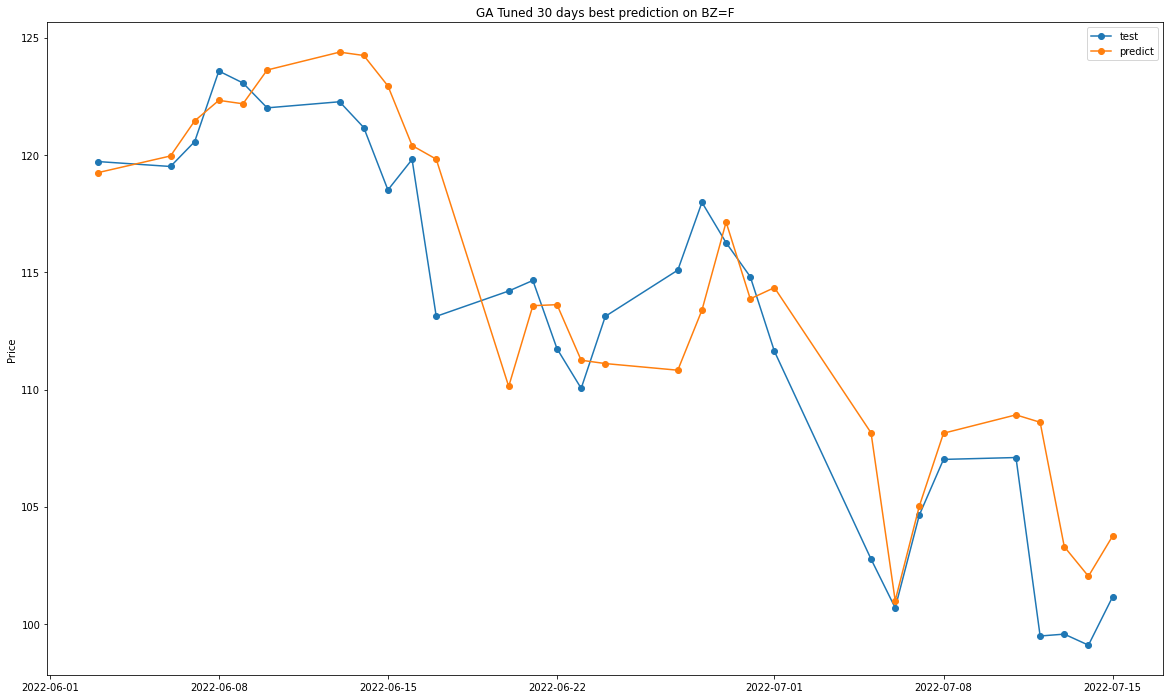

NG=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.6832952989282233
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.33, 2, 1.1, 3.8, 0.6, 0.9] 0.7627672221532351
The total running time is:  288.4724657535553


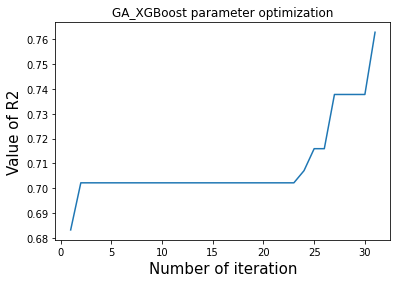

[0.33, 2, 1.1, 3.8, 0.6, 0.9]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267, 0.7080863032420288, 0.8317603210438687, 0.7627672221532351]


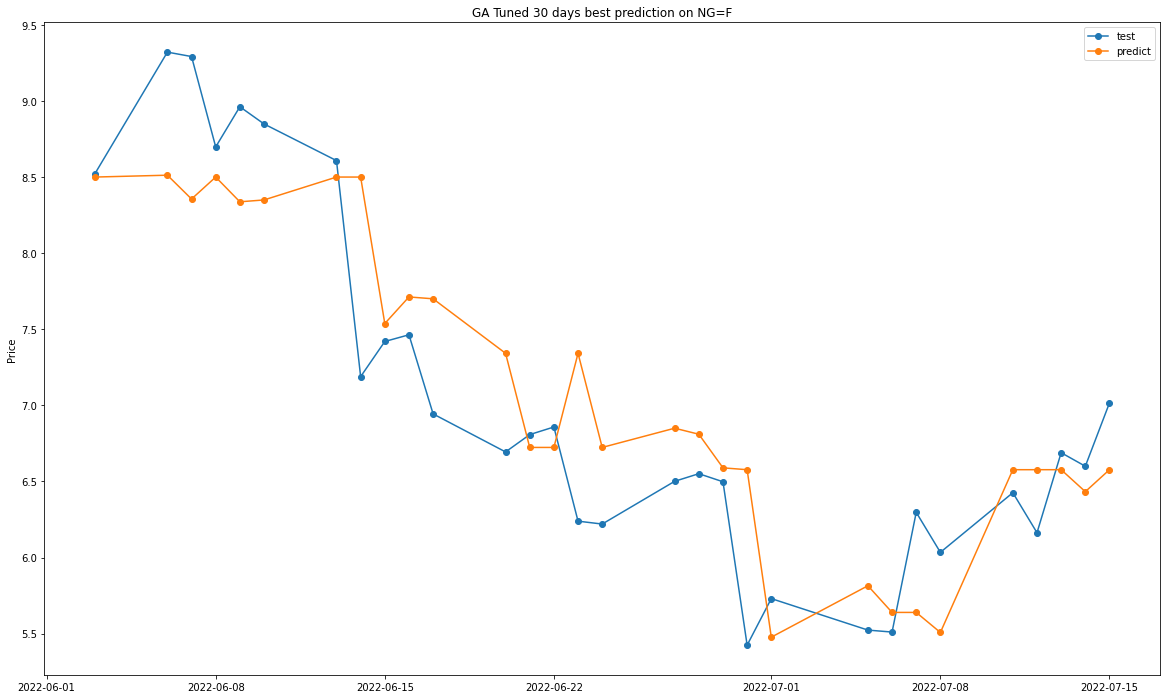

ZC=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.542490153488775
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.35, 6, 2.2, 3.8, 0.8, 0.2] 0.6254417425479308
The total running time is:  179.4556758403778


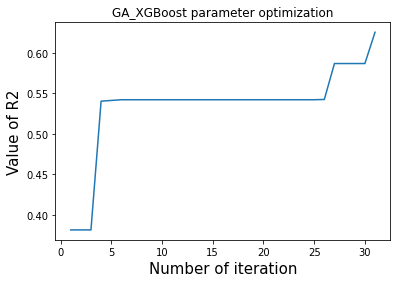

[0.35, 6, 2.2, 3.8, 0.8, 0.2]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267, 0.7080863032420288, 0.8317603210438687, 0.7627672221532351, 0.6254417425479308]


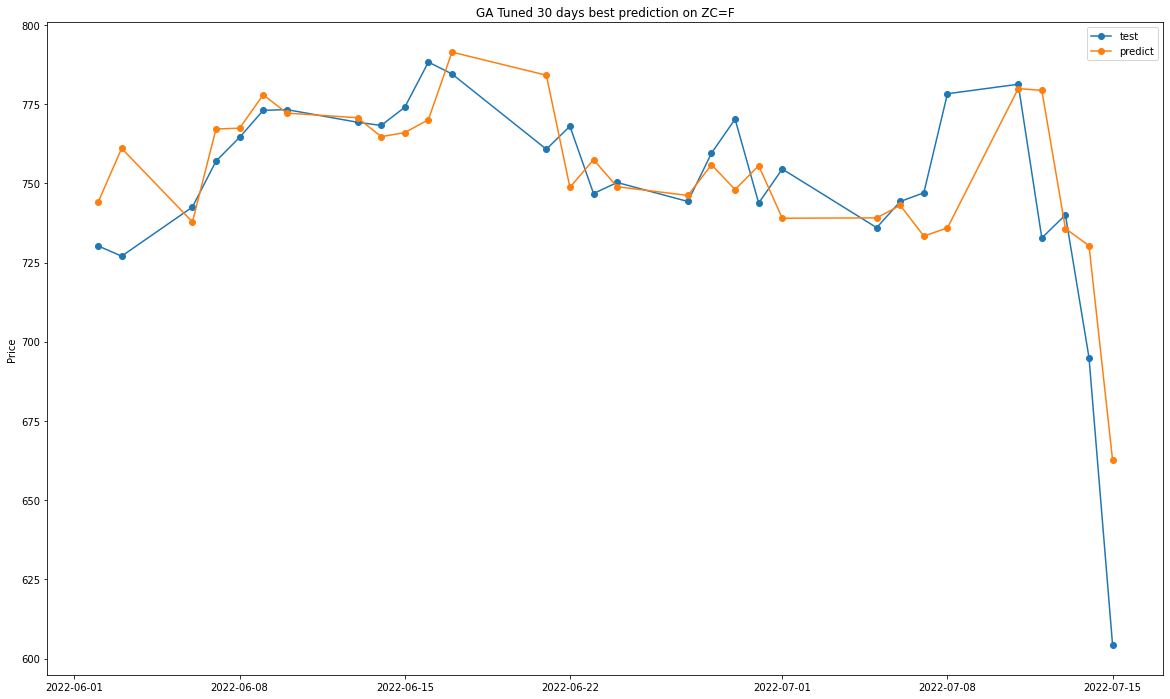

ZO=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  -0.054130583508419816
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.49, 2, 1.4, 2.5, 0.2, 0.8] 0.2534772455222717
The total running time is:  185.27540183067322


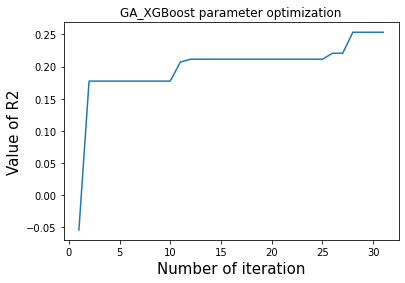

[0.49, 2, 1.4, 2.5, 0.2, 0.8]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267, 0.7080863032420288, 0.8317603210438687, 0.7627672221532351, 0.6254417425479308, 0.2534772455222717]


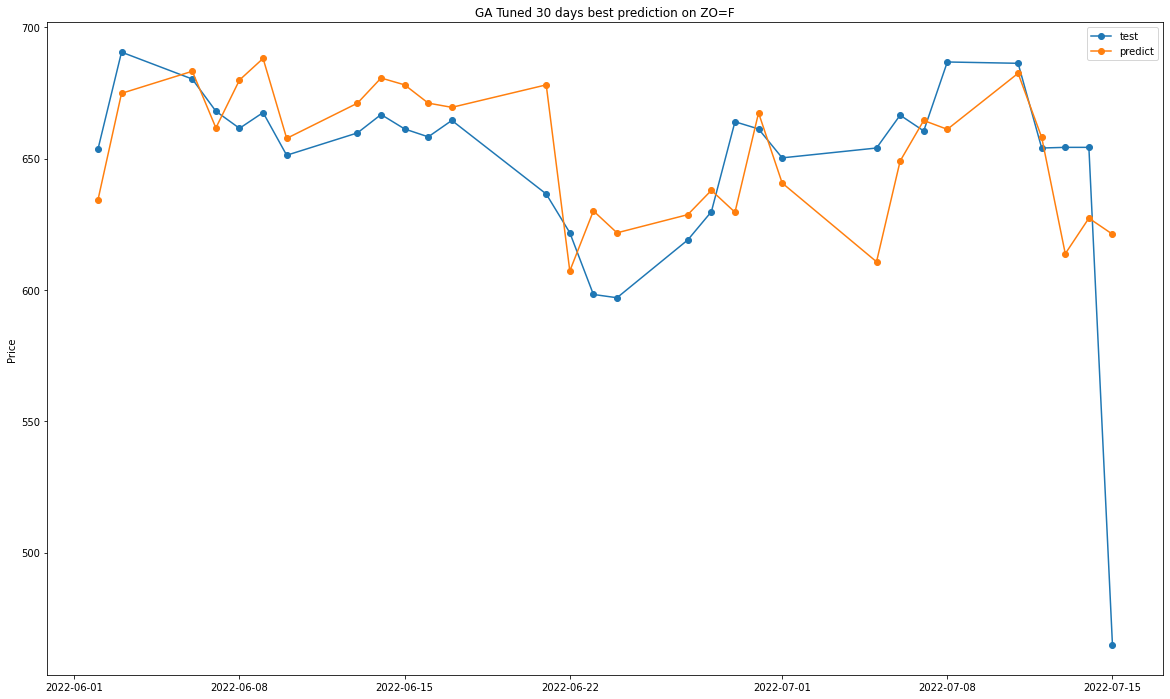

KE=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  0.7902671893823963
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.38, 5, 0.3, 3.8, 0.7, 0.9] 0.8514693652971836
The total running time is:  392.31271481513977


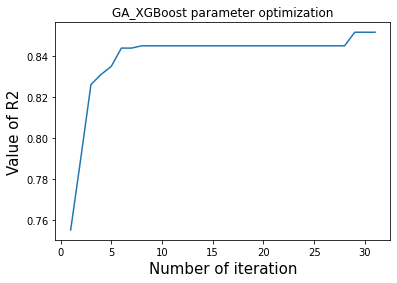

[0.38, 5, 0.3, 3.8, 0.7, 0.9]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267, 0.7080863032420288, 0.8317603210438687, 0.7627672221532351, 0.6254417425479308, 0.2534772455222717, 0.8514693652971836]


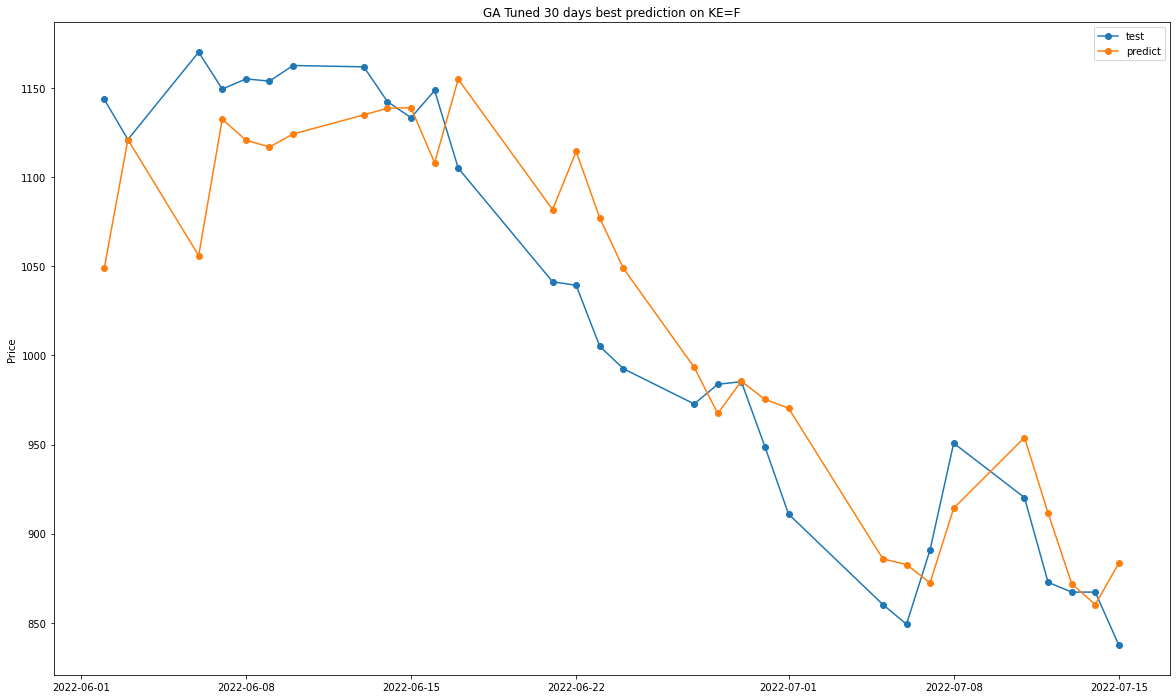

ZR=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.GA_XGBoostRegressor-----------------
The initial score is:  -0.005317149011803579
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Generation Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.16, 1, 0.8, 5.0, 0.4, 0.3] 0.6365250403374465
The total running time is:  151.20421719551086


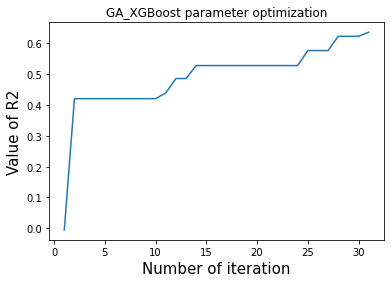

[0.16, 1, 0.8, 5.0, 0.4, 0.3]
[0.9071311194260451, 0.9280023826222009, 0.9633864658648267, 0.7080863032420288, 0.8317603210438687, 0.7627672221532351, 0.6254417425479308, 0.2534772455222717, 0.8514693652971836, 0.6365250403374465]


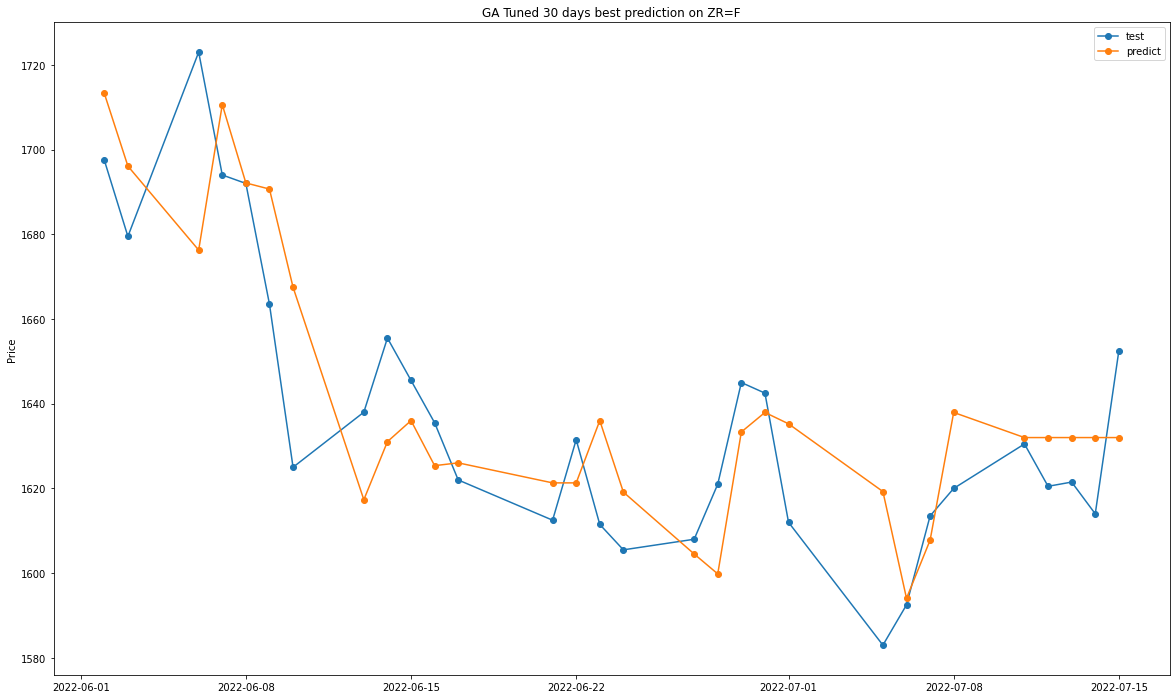

        R^2 Commodity                    Best_Params          MSE        MAE  \
0  0.907131      GC=F  [0.22, 4, 2.9, 5.0, 0.5, 0.1]   236.406445  11.229810   
1  0.928002      SI=F  [0.14, 4, 1.5, 3.8, 0.8, 0.3]     0.115974   0.295512   
2  0.963386      HG=F  [0.14, 5, 2.3, 6.2, 0.8, 0.6]     0.005641   0.059907   
3  0.708086      CL=F  [0.38, 1, 0.6, 3.8, 0.4, 0.6]    20.300444   3.768814   
4  0.831760      BZ=F  [0.29, 8, 0.0, 6.2, 0.7, 0.5]    10.206193   2.449579   
5  0.762767      NG=F  [0.33, 2, 1.1, 3.8, 0.6, 0.9]     0.311306   0.436740   
6  0.625442      ZC=F  [0.35, 6, 2.2, 3.8, 0.8, 0.2]   423.948029  14.183695   
7  0.253477      ZO=F  [0.49, 2, 1.4, 2.5, 0.2, 0.8]  1234.098332  21.740981   
8  0.851469      KE=F  [0.38, 5, 0.3, 3.8, 0.7, 0.9]  1999.208975  35.767275   
9  0.636525      ZR=F  [0.16, 1, 0.8, 5.0, 0.4, 0.3]   384.994798  15.968469   

       MAPE  Running Time  
0  0.006246    159.902340  
1  0.014516    422.223440  
2  0.016074    375.170670  
3  0.03

In [22]:
stock_names = []
best_param = []
r2s = []
mses = []
maes = []
mapes = []
running_times = []
df_ga_best = pd.DataFrame(columns=['R^2'])

for stk, data in zip(stocks, trading_datas):
    print (stk)
    if __name__ == '__main__':
        stock_data = data
        STD_periods = [7]
        SMA_periods = [7, 14, 30, 50]
        SMA_envelope_range_percentage = 5
        EMA_period = 8
        MACD_shortPeriod = 12
        MACD_longPeriod = 26
        MACD_signalPeriod = 9
        RSI_period = 14
        Stoch_periods = [14, 14, 14, 14] #RSI, StochRSI, %K(max), %D(min)
        KDJ_periods = [14, 14]

        tis = Technical_Indicators(stock_data, STD_periods, SMA_periods, SMA_envelope_range_percentage, EMA_period, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod, RSI_period, Stoch_periods, KDJ_periods)
        stock_results = tis.main()
        result_names = str(stk)
        df_technical_data = stock_results.dropna(axis=0)
        #df_technical_data = df_technical_data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
        

    prediction_days = 50
    future_days = 30
    df_data = pd.DataFrame(columns=['Close'], index = df_technical_data.tail(df_technical_data.shape[0]).index[prediction_days:len(df_technical_data)].tolist())

    for col in df_technical_data.columns: #,'SMA','MACD_Signal','RSI' 
        #print (col)
        
        #df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
        #col_nam = str(col)+str('-1')
        #df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
        if col == 'Close':
            df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
            
            prediction_day = 7
            for index_init in range(prediction_day):
                rolling_data = df_technical_data.iloc[index_init: index_init+(len(df_technical_data[col]) - prediction_days),:][col].tolist()
                col_name = str(col)+str(index_init-prediction_day)
                df_data[col_name] = rolling_data
            '''
        elif col == 'Open':
            df_data['Open'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Open'].tolist()
            '''
        else:
            col_nam = str(col)+str('-1')
            df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()      
    
    
    
    XGB = XGBRegressor() #num_boost_round=v1, eta=v2, max_depth=v3, gamma=v4,#early_stopping_rounds=20)

    
    
    
    time_set_num = 1
    data_length = len(df_data)
    
    for i in range(1, time_set_num+1):
        df_train_period = df_data.iloc[future_days*(i-1): data_length-future_days*(time_set_num-(i-1)), :]
        df_test_period = df_data.iloc[data_length-future_days*(time_set_num-(i-1)): data_length-future_days*(time_set_num-(i)), :]
        
        x_train = df_train_period[df_train_period.columns.drop('Close').tolist()]
        y_train = df_train_period['Close']
        x_test = df_test_period[df_test_period.columns.drop('Close').tolist()]
        y_test = df_test_period['Close']
        
    mdlst = time.time()
    if __name__ == '__main__':
        print('----------------1.Load Data-------------------')
        trainX, trainY = x_train, y_train
        print('----------------2.Parameter Setting------------')
        population_size = 20
        chromosome_length = 31
        generations = 30
        pc = 0.6 #0.6
        pm = 0.05 #0.01
        print('----------------3.GA_XGBoostRegressor-----------------')
        ga = GA(population_size, chromosome_length, generations, pc, pm)
        df_ga_results = ga.main()
    mdled = time.time()
    best_params = df_ga_results['Parameters'].tolist()[-1]
    print (best_params)
    best_XGB = XGBRegressor(learning_rate=best_params[0], 
                            max_depth=best_params[1], 
                            gamma=best_params[2],
                            min_child_weight=best_params[3],
                            subsample=best_params[4],
                            colsample_bytree=best_params[5],
                           )
    best_XGB.fit(x_train, y_train)
    best_predict = best_XGB.predict(x_test)
    
    r2_scr = r2_score(y_test, best_predict)
    mse = mean_squared_error(y_test, best_predict)
    mae = mean_absolute_error(y_test, best_predict)
    mape = mean_absolute_percentage_error(y_test, best_predict)
    '''
    print (mdl_name,"'s performances:")
    print (' R^2 Score', r2_scr)
    print (' Mean Squared Error', mse)
    print (' Mean Absolute Error', mae)
    print (' Mean Absolute Percentage Error', mape)
    '''
    stock_names.append(stk)
    best_param.append(best_params)
    r2s.append(r2_scr)
    print (r2s)
    mses.append(mse)
    maes.append(mae)
    mapes.append(mape)
    running_times.append(mdled-mdlst)
          
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(y_test.index, y_test,'o-', label='test',)
    ax.plot(y_test.index, best_predict, 'o-', label='predict')
    ax.set_title('GA Tuned '+str(future_days)+' days best prediction on '+str(stk))
    ax.set_ylabel('Price')
    ax.legend()
    plt.show()    
        
    
'''
df_pred_results['Model'] = mdl_names
'''
df_ga_best['Commodity'] = stock_names
df_ga_best['Best_Params'] = best_param
df_ga_best['R^2'] = r2s
df_ga_best['MSE'] = mses
df_ga_best['MAE'] = maes
df_ga_best['MAPE'] = mapes
df_ga_best['Running Time'] = running_times
print (df_ga_best)


## PSO

In [23]:
class PSO(object):
### Overall configuration of PSO tuned Model
    def __init__(self,particle_num,particle_dim,iter_num,c1,c2,w,max_value,min_value):
        '''Parameters for PSO tuned Model
        - particle_num(int): Initial Particle numbers
        - particle_dim(int): Particle Dimension (Number of Parameters)
        - iter_num(int): Maximum Iteration Number
        - c1(float): Partial learning coefficient 表示粒子移动到该粒子历史最优位置(pbest)的加速项的权重
        - c2(float): Global learning coefficient 表示粒子移动到所有粒子最优位置(gbest)的加速项的权重
        - w(float): Weight of the direciton(Velocity) of the particles 
        - max_value(float): Maximum of the range for the parametetrs (an adjustable range for all parameters)
        - min_value(float): Minimum of the range for the parametetrs (an adjustable range for all parameters)
        '''
        self.particle_num = particle_num
        self.particle_dim = particle_dim
        self.iter_num = iter_num 
        self.c1 = c1  # Usually set as 2
        self.c2 = c2  # Usually set as 2
        self.w = w    # Usually set as 1
        self.max_value = max_value
        self.min_value = min_value
        
        
### Particle Initialization
    def swarm_origin(self):

        particle_loc = [] 
        particle_dir = []
        for i in range(self.particle_num):
            tmp1 = []
            tmp2 = []
            for j in range(self.particle_dim):
                p_loc = random.random()
                p_dir = random.random()
                tmp1.append(p_loc * (self.max_value - self.min_value) + self.min_value)
                tmp2.append(p_dir)
            particle_loc.append(tmp1)
            particle_dir.append(tmp2)

        return particle_loc, particle_dir

### Fitness value calculation (model application and evaluation)
    def fitness(self, particle_loc):
        
        ## Obtaining Fitness Value
        fitness_value = []
        for i in range(self.particle_num):
            
            ## Parameter adjustments
            # XGBoostRegressor Parameters
            #p1 = round((particle_loc[i][0] * (max_value*10 - min_value*1000) + min_value*1000)/10) * 10
            p2 = round((particle_loc[i][1]/max_value)*0.8, 2) # eta
            p3 = round((particle_loc[i][2]/max_value)*20) # max_depth
            p4 = round((particle_loc[i][3]/max_value)*2, 1) # gamma
            p5 = round((particle_loc[i][4]/max_value)*10) # min_child_weight
            p6 = round((particle_loc[i][5]/max_value)*1, 1) # subsample
            p7 = round((particle_loc[i][6]/max_value)*1, 1) # colsample_bytree

            model = XGBRegressor(#num_boost_round=p1,
                                 eta=p2,
                                 max_depth=int(p3),
                                 gamma=p4,
                                 min_child_weight=int(p5), 
                                 subsample=p6,
                                 colsample_bytree=p7
                                )
            
            ## Model Training
            model.fit(x_train, y_train)
            predict_test = model.predict(x_test)
            ## Fitness Score/ Evaluation of model
            # R^2 Score
            result_score = r2_score(y_test, predict_test) 
            fitness_value.append(result_score)
            #print (p2, p3, p4, p5, p6, p7, result_score)
        ## The current best score and parameter setting
        current_fitness = 0.0
        current_parameter = []
        for i in range(self.particle_num):
            if current_fitness < fitness_value[i]:
                current_fitness = fitness_value[i]
                current_parameter = particle_loc[i]

        return fitness_value, current_fitness, current_parameter 
        

### Particle location and direction updates
    def update(self, particle_loc, particle_dir, gbest_parameter, pbest_parameters):

        ## 1.Updating Particles' Locations and Directions
        for i in range(self.particle_num):
            # Particle Direction / Velocity update
            #particle_dir[i] = self.w * particle_dir[i] + self.c1 * random.random() * (pbest_parameters[i] - particle_loc[i]) + self.c2 * random.random() * (gbest_parameter - particle_dir[i])
            a1 = [x * self.w for x in particle_dir[i]]
            a2 = [y * self.c1 * random.random() for y in list(np.array(pbest_parameters[i]) - np.array(particle_loc[i]))]
            a3 = [z * self.c2 * random.random() for z in list(np.array(gbest_parameter) - np.array(particle_dir[i]))]
            particle_dir[i] = list(np.array(a1) + np.array(a2) + np.array(a3)) #Direction / Velocity update 
            particle_loc[i] = list(np.array(particle_loc[i]) + np.array(particle_dir[i])) #Location update

        ## 2. Bonding the updated Locations in the reasonable/ feasible range
        # List of the values of Each Parameter after the update
        parameter_list = []
        for i in range(self.particle_dim):
            tmp1 = []
            for j in range(self.particle_num):
                tmp1.append(particle_loc[j][i])
            parameter_list.append(tmp1)
            
        # The Maximum and Minimum values of the updated paramters (particle locations)
        value = []
        for i in range(self.particle_dim):
            tmp2 = []
            tmp2.append(max(parameter_list[i]))
            tmp2.append(min(parameter_list[i]))
            value.append(tmp2)
            
        # Bounding the updated parameter values inside the range of [max_value, min_value]
        for i in range(self.particle_num):
            for j in range(self.particle_dim):
                # new location = ( updated_location - updated_max/(updated_max - updated_min)*(set_max - set_min) ) + set_min
                particle_loc[i][j] = (particle_loc[i][j] - value[j][1])/(value[j][0] - value[j][1]) * (self.max_value - self.min_value) + self.min_value
        return particle_loc, particle_dir

    
### Performance Plot
    def iter_plot(self, results):
        X = []
        Y = []
        for i in range(self.iter_num):
            X.append(i + 1)
            Y.append(results[i])
        plt.plot(X,Y)
        plt.xlabel('Number of iteration', 
                   size = 15)
        plt.ylabel('Value of CV', 
                   size = 15)
        plt.title('PSO_XGBoost parameter optimization')
        plt.show()
        
## Main Process        
    def main(self):
        init_start = time.time()
        mod_init = XGBRegressor()#num_boost_round=v1, eta=v2, max_depth=v3, gamma=v4,#early_stopping_rounds=20)
        mod_init.fit(x_train, y_train)
        init_predict_test = mod_init.predict(x_test) 
        init_result_score = r2_score(y_test, init_predict_test)
        init_end = time.time()
        pickle.dump(mod_init, open("xgb_temp.pkl", "wb"))
        mod_init2 = pickle.load(open("xgb_temp.pkl", "rb"))
        assert np.allclose(mod_init.predict(x_test), mod_init2.predict(x_test))
        params = mod_init2.get_xgb_params()
        for par_key in params.keys():
            if par_key == 'learning_rate':
                init_lr = params[par_key]
            elif par_key == 'max_depth':
                init_mdp = params[par_key]
            elif par_key == 'gamma':
                init_gamma = params[par_key]
            elif par_key == 'min_child_weight':
                init_min_child_weight = params[par_key]
            elif par_key == 'subsample':
                init_subsample = params[par_key]
            elif par_key == 'colsample_bytree':
                init_colsample_bytree = params[par_key]
        init_params = [init_lr, init_mdp, init_gamma, init_min_child_weight, init_subsample, init_colsample_bytree]
        print ('The initial score is: ', init_result_score)
        print ('The initial parameters are: ', init_params)

        result_scores = []
        result_parameters = []
        iter_times = []
        
        result_scores.append(init_result_score)
        result_parameters.append(init_params)
        iter_times.append(iter_times)

        total_start_time = time.time()
        iter_times = []
        best_fitness = 0.0 
        ## Initial POSITIONS and DIRECTIONS
        particle_loc, particle_dir = self.swarm_origin()
        ## Global Best, Partial/ Local Best, Score and Parameter recording
        # Global Best gbest_parameter
        gbest_parameter = []
        for i in range(self.particle_dim):
            gbest_parameter.append(0.0)
        
        # Partial/ Local Best pbest_parameters
        pbest_parameters = []
        for i in range(self.particle_num):
            tmp1 = []
            for j in range(self.particle_dim):
                tmp1.append(0.0)
            pbest_parameters.append(tmp1)

        # Score Recording fitness_value
        fitness_value = []
        for i in range(self.particle_num):
            fitness_value.append(0.0)
        
        ## Iteration Process
        for i in tqdm_notebook(range(self.iter_num), desc='Iteration Progress'):
            iter_start_time = time.time()
            # Calculating the scores of the particles 
            current_fitness_value, current_best_fitness, current_best_parameter = self.fitness(particle_loc)
            # The current best score / current best configuration 
            for j in range(self.particle_num):
                if current_fitness_value[j] > fitness_value[j]:
                    pbest_parameters[j] = particle_loc[j]
            # Updating the global best
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                gbest_parameter = current_best_parameter
            # Demonstrating the best score and parameters so far 
            iter_parameters = []
            iter_parameters.append(round((gbest_parameter[1]/max_value)*0.8, 2))
            iter_parameters.append(round((gbest_parameter[2]/max_value)*20))
            iter_parameters.append(round((gbest_parameter[3]/max_value)*2, 1))
            iter_parameters.append(round((gbest_parameter[4]/max_value)*10))
            iter_parameters.append(round((gbest_parameter[5]/max_value)*1, 1))
            iter_parameters.append(round((gbest_parameter[6]/max_value)*1, 1)) 
            #print('Iteration No.:',i+1,'\n','Best parameters:', iter_parameters,'\n','Best fitness',best_fitness)
            result_scores.append(best_fitness)
            result_parameters.append(iter_parameters)
            
            # Update fitness_value
            fitness_value = current_fitness_value
            # Update Particles
            particle_loc, particle_dir = self.update(particle_loc, particle_dir, gbest_parameter, pbest_parameters)
            iter_end_time = time.time()
            iter_times.append(iter_end_time-iter_start_time)
        total_end_time = time.time()
        total_time = total_end_time-total_start_time

        ## Results
        df_results = pd.DataFrame({'Scores': result_scores, 
                                   'Parameters': result_parameters,
                                   #'Running Time': iter_times
                                  })
        df_results = df_results.sort_values('Scores', ascending=True)
        
        print('The best configiration and score are: ', df_results['Parameters'].tolist()[-1], df_results['Scores'].tolist()[-1])
        print('The total running time is: ', total_time)
        
        ## Plot
        self.iter_plot(df_results['Scores'].tolist())
        return df_results
    

GC=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.8292667123856837
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.24, 7, 0.2, 4, 0.4, 0.3] 0.9346898669489935
The total running time is:  162.92048597335815


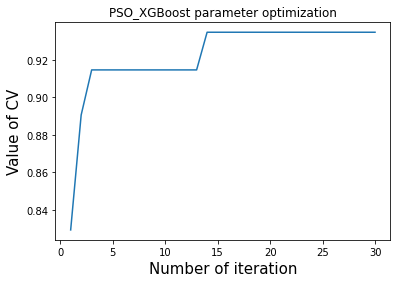

[0.24, 7, 0.2, 4, 0.4, 0.3]


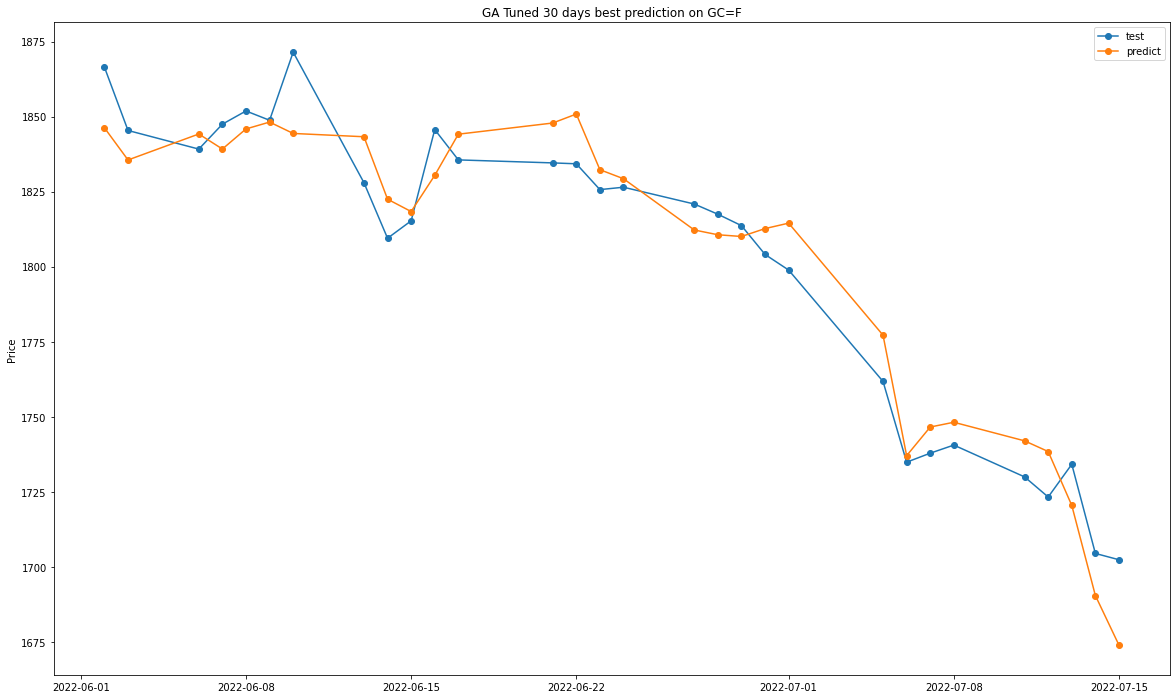

SI=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.9030090052794345
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.19, 2, 0.4, 10, 1.0, 0.6] 0.933503053412531
The total running time is:  169.63856410980225


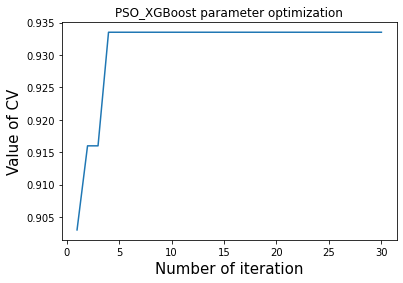

[0.19, 2, 0.4, 10, 1.0, 0.6]


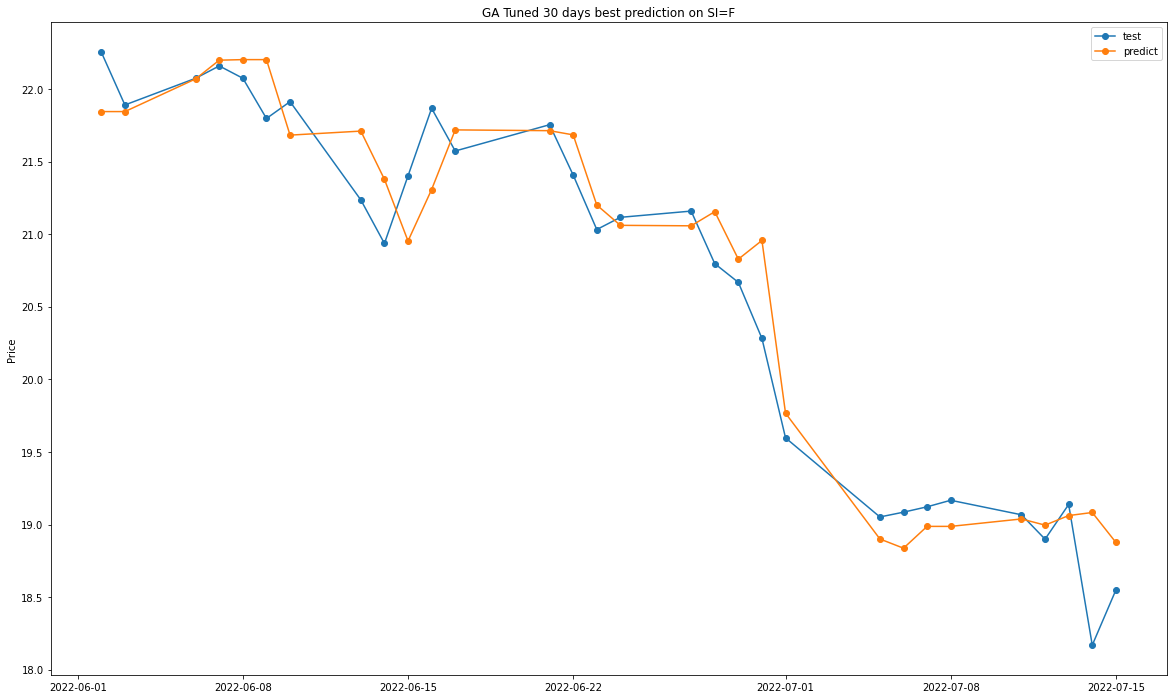

HG=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.9195510139267876
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.04, 6, 0.4, 2, 0.6, 0.5] 0.9670755939700759
The total running time is:  120.21043491363525


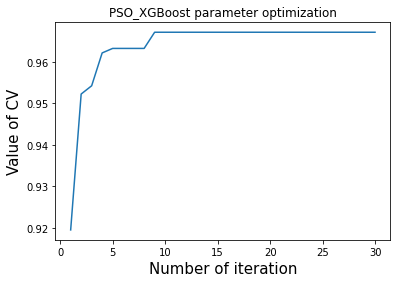

[0.04, 6, 0.4, 2, 0.6, 0.5]


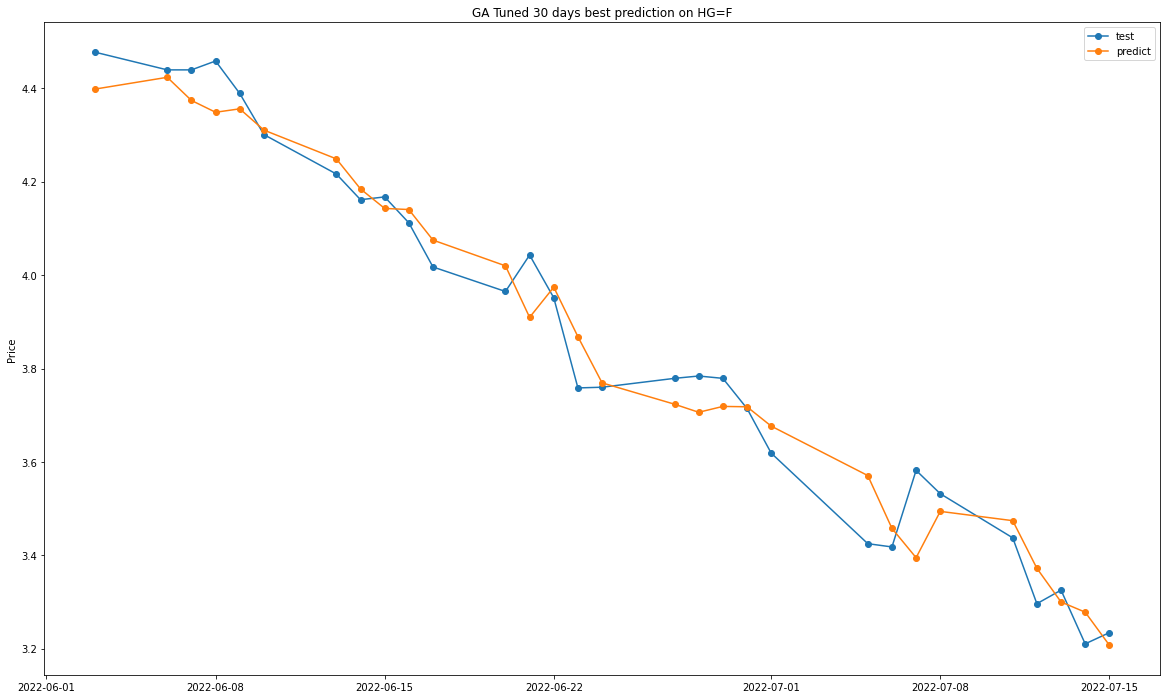

CL=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.26209752136810527
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.27, 1, 1.0, 1, 0.1, 0.0] 0.834527596999047
The total running time is:  136.70843315124512


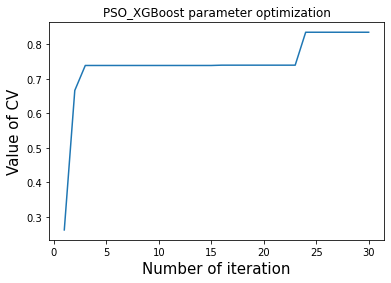

[0.27, 1, 1.0, 1, 0.1, 0.0]


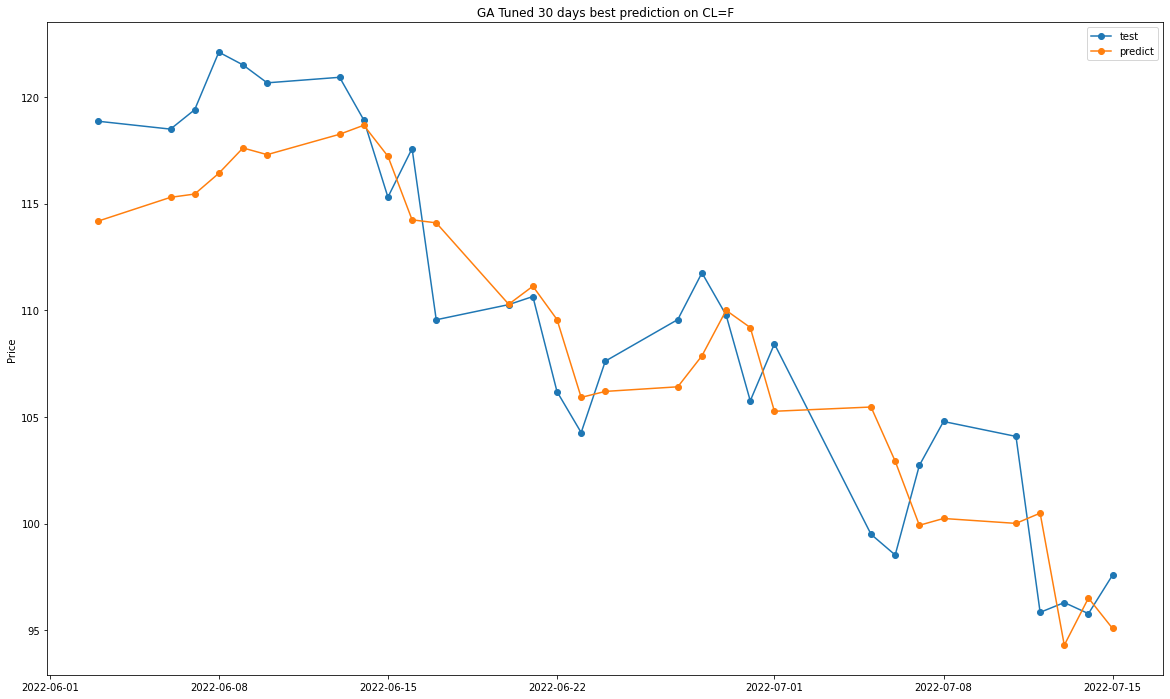

BZ=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.8064285930895196
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.05, 11, 1.0, 5, 0.4, 1.0] 0.8595899063421419
The total running time is:  103.46189022064209


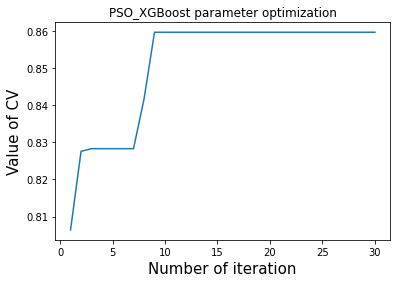

[0.05, 11, 1.0, 5, 0.4, 1.0]


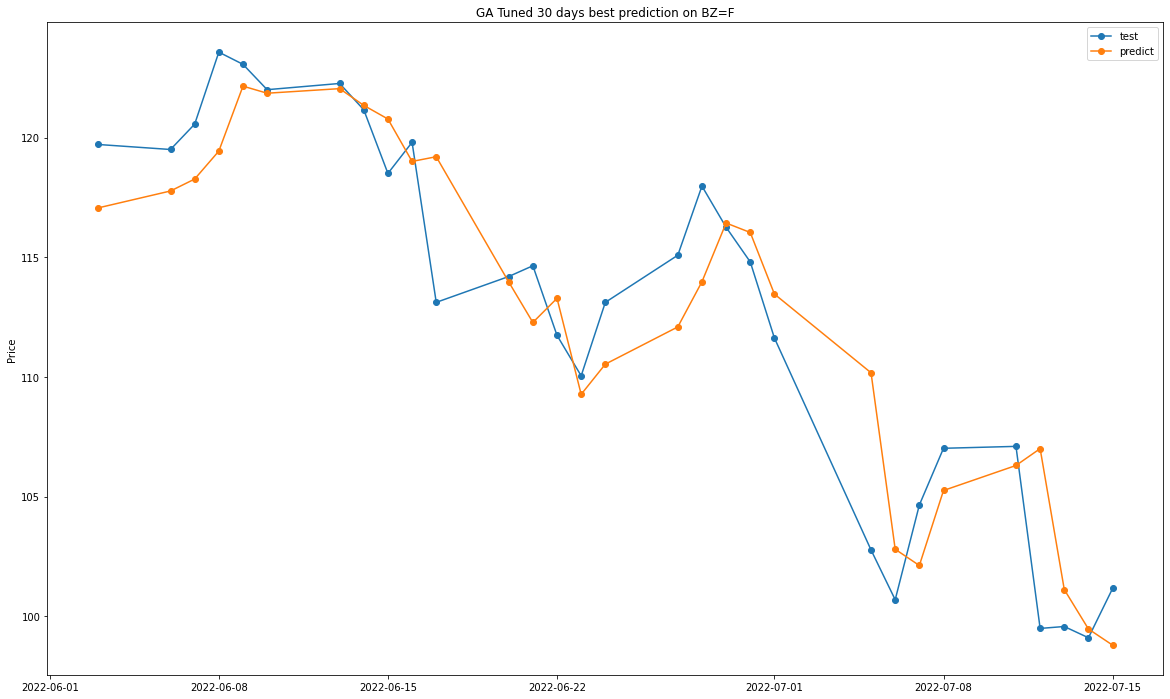

NG=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.6832952989282233
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.3, 2, 0.5, 2, 0.3, 0.1] 0.8495938995168695
The total running time is:  170.18552708625793


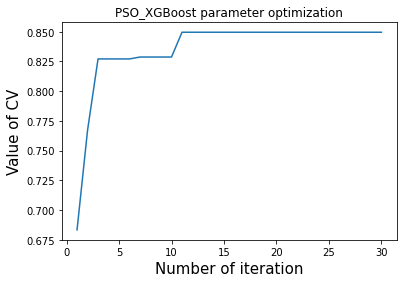

[0.3, 2, 0.5, 2, 0.3, 0.1]


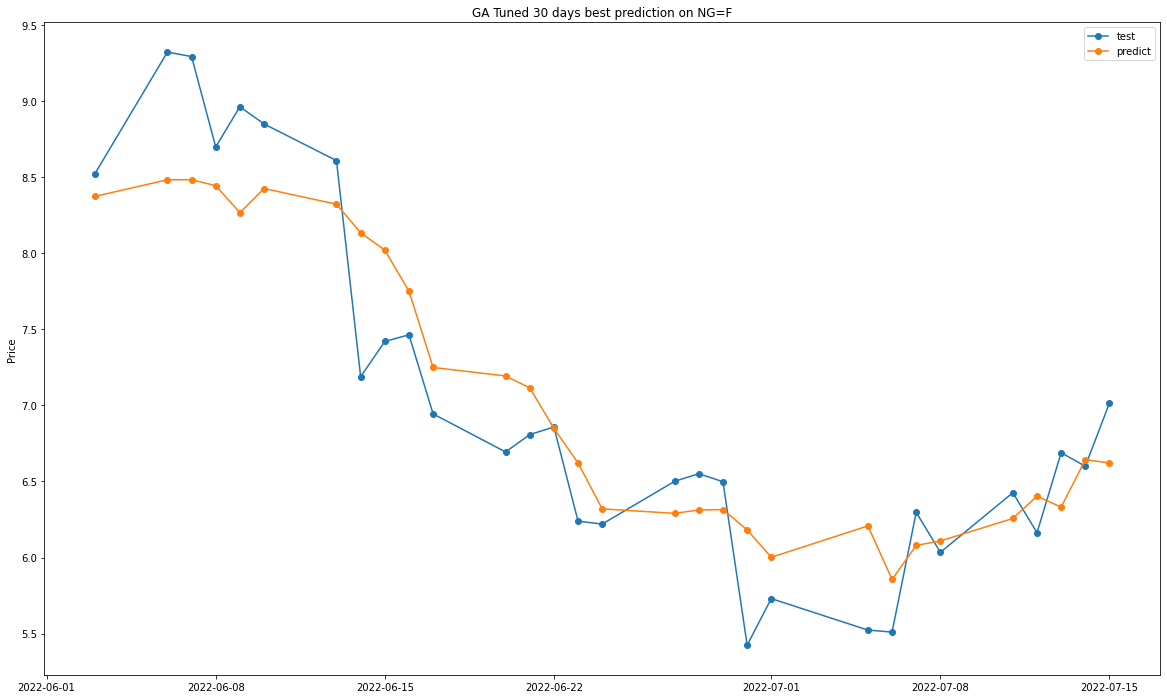

ZC=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.542490153488775
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.19, 1, 0.1, 4, 0.1, 1.0] 0.6164358645663428
The total running time is:  150.41785788536072


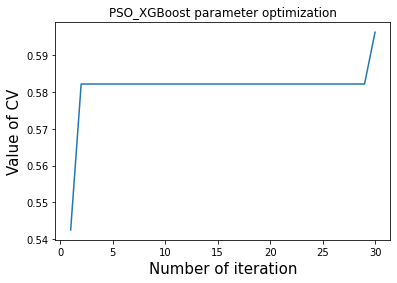

[0.19, 1, 0.1, 4, 0.1, 1.0]


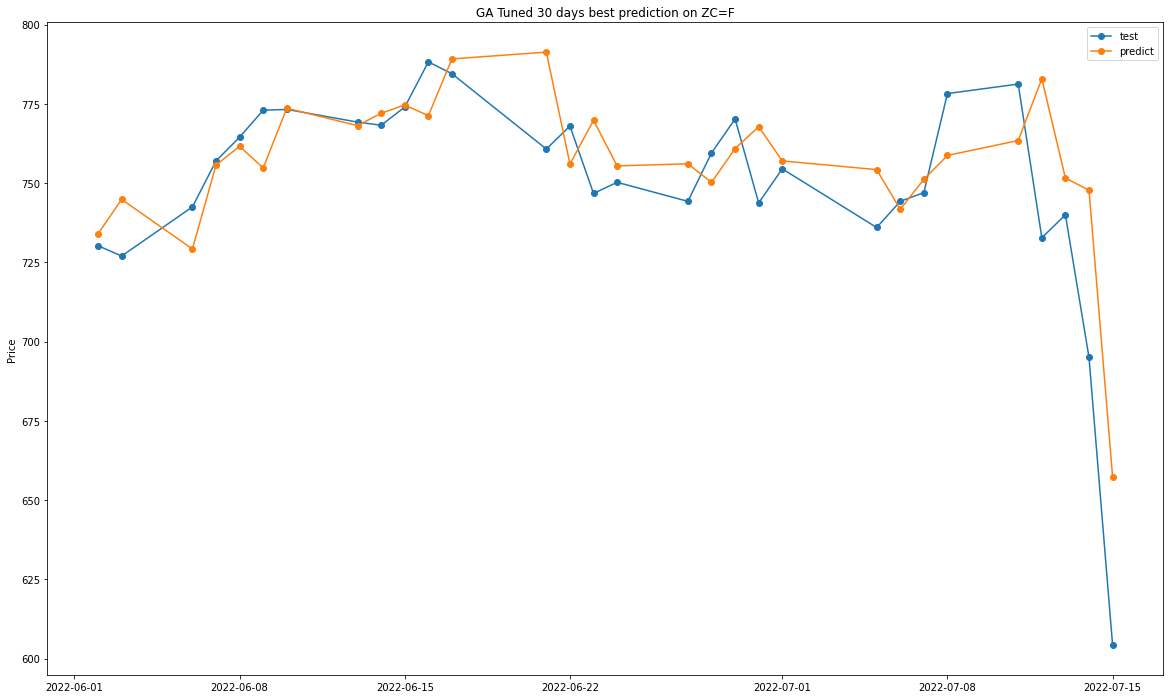

ZO=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  -0.054130583508419816
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.22, 5, 0.6, 5, 1.0, 1.0] 0.2258475134868605
The total running time is:  132.15904879570007


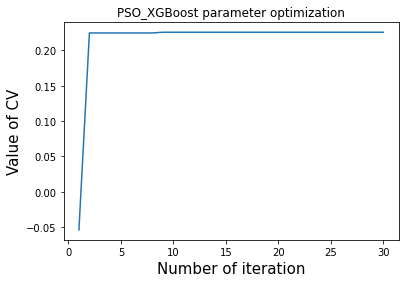

[0.22, 5, 0.6, 5, 1.0, 1.0]


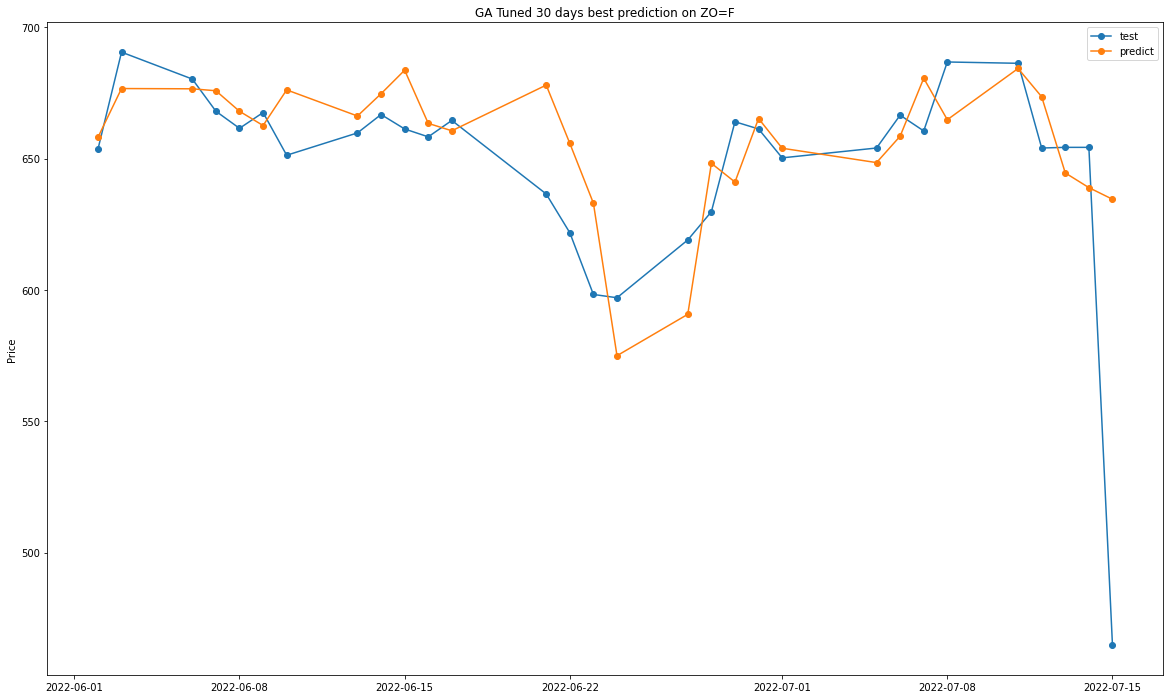

KE=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  0.7902671893823963
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.32, 6, 1.4, 0, 0.7, 0.5] 0.9113434577699492
The total running time is:  144.03858470916748


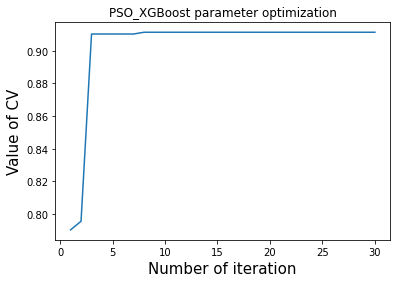

[0.32, 6, 1.4, 0, 0.7, 0.5]


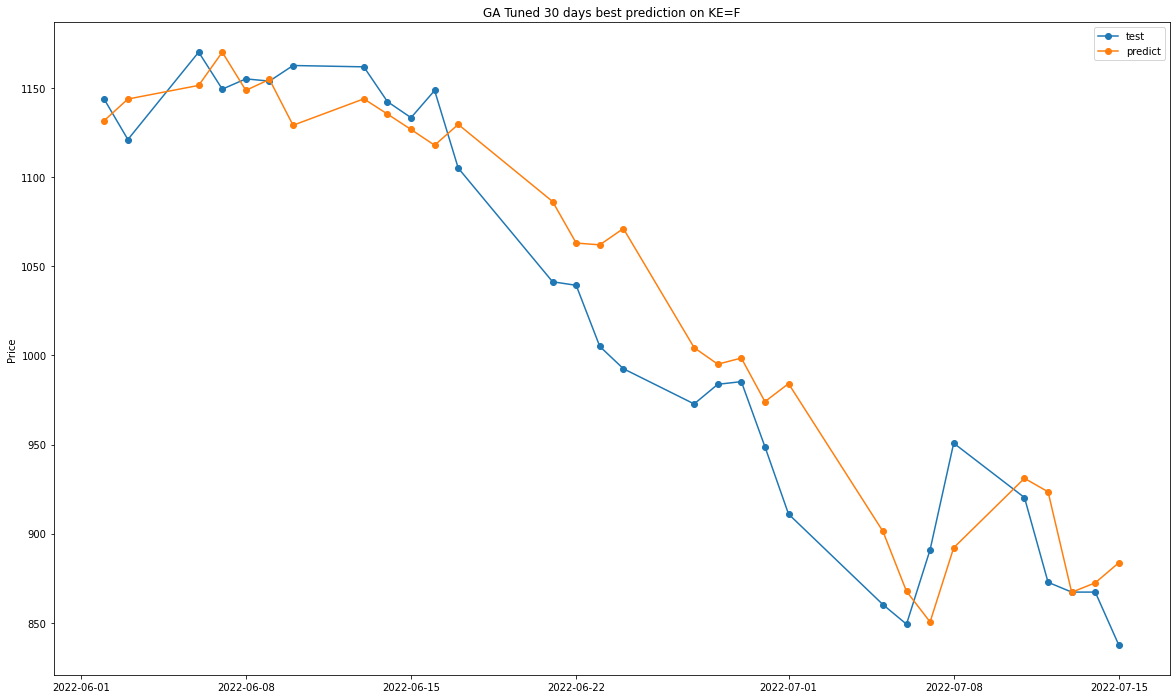

ZR=F
----------------1.Load Data-------------------
----------------2.Parameter Setting------------
----------------3.PSO_XGBoostRegressor-----------------
The initial score is:  -0.005317149011803579
The initial parameters are:  [0.300000012, 6, 0, 1, 1, 1]


Iteration Progress:   0%|          | 0/30 [00:00<?, ?it/s]

The best configiration and score are:  [0.1, 4, 0.2, 3, 0.5, 0.1] 0.5912394807071244
The total running time is:  172.68338704109192


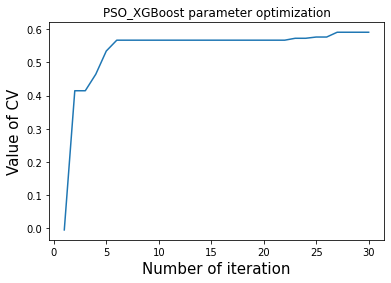

[0.1, 4, 0.2, 3, 0.5, 0.1]


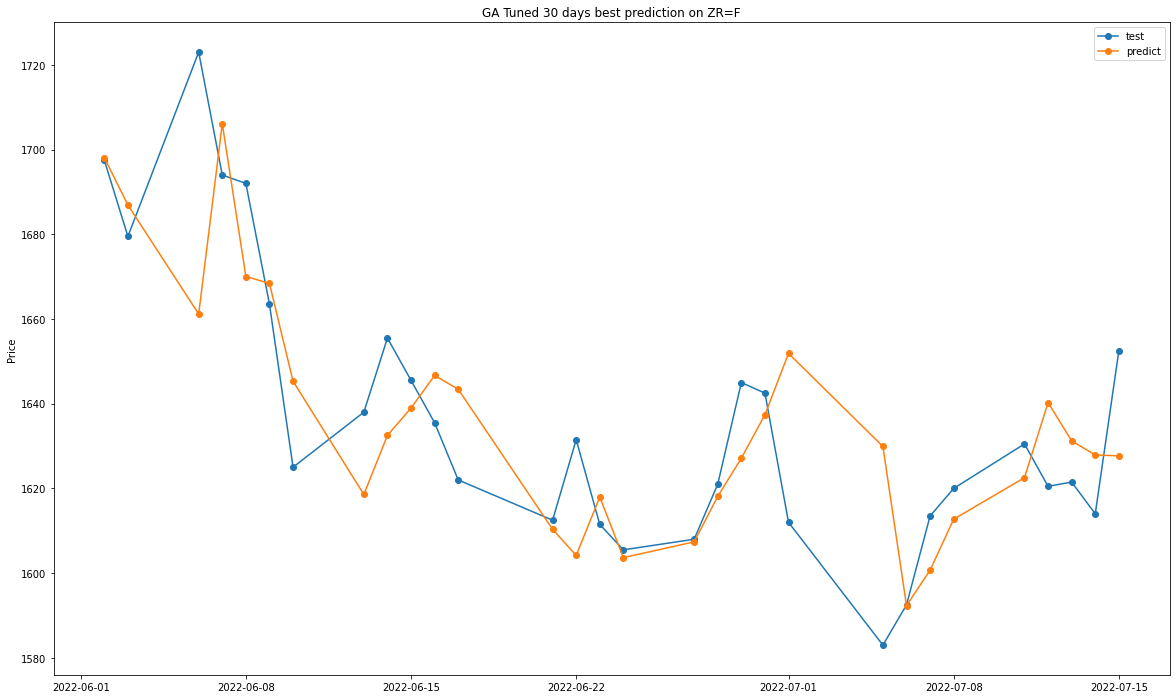

        R^2 Commodity                   Best_Params          MSE        MAE  \
0  0.934690      GC=F   [0.24, 7, 0.2, 4, 0.4, 0.3]   166.253069  11.071358   
1  0.933503      SI=F  [0.19, 2, 0.4, 10, 1.0, 0.6]     0.107113   0.249934   
2  0.967076      HG=F   [0.04, 6, 0.4, 2, 0.6, 0.5]     0.005073   0.056886   
3  0.834528      CL=F   [0.27, 1, 1.0, 1, 0.1, 0.0]    11.507385   3.000153   
4  0.859590      BZ=F  [0.05, 11, 1.0, 5, 0.4, 1.0]     8.517922   2.186169   
5  0.849594      NG=F    [0.3, 2, 0.5, 2, 0.3, 0.1]     0.197369   0.369557   
6  0.616436      ZC=F   [0.19, 1, 0.1, 4, 0.1, 1.0]   434.141435  14.754447   
7  0.225848      ZO=F   [0.22, 5, 0.6, 5, 1.0, 1.0]  1279.773840  19.783466   
8  0.911343      KE=F   [0.32, 6, 1.4, 0, 0.7, 0.5]  1193.309079  27.728174   
9  0.591239      ZR=F    [0.1, 4, 0.2, 3, 0.5, 0.1]   432.961526  15.267920   

       MAPE  Running Time  
0  0.006166    164.458615  
1  0.012244    171.075247  
2  0.015030    121.615987  
3  0.027549    138

In [26]:
stock_names = []
best_param = []
r2s = []
mses = []
maes = []
mapes = []
run_times = []
df_pso_best = pd.DataFrame(columns=['R^2'])

for stk, data in zip(stocks, trading_datas):
    print (stk)
    if __name__ == '__main__':
        stock_data = data
        STD_periods = [7]
        SMA_periods = [7, 14, 30, 50]
        SMA_envelope_range_percentage = 5
        EMA_period = 8
        MACD_shortPeriod = 12
        MACD_longPeriod = 26
        MACD_signalPeriod = 9
        RSI_period = 14
        Stoch_periods = [14, 14, 14, 14] #RSI, StochRSI, %K(max), %D(min)
        KDJ_periods = [14, 14]

        tis = Technical_Indicators(stock_data, STD_periods, SMA_periods, SMA_envelope_range_percentage, EMA_period, MACD_shortPeriod, MACD_longPeriod, MACD_signalPeriod, RSI_period, Stoch_periods, KDJ_periods)
        stock_results = tis.main()
        result_names = str(stk)
        df_technical_data = stock_results.dropna(axis=0)
        #df_technical_data = df_technical_data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
        

    prediction_days = 50
    future_days = 30
    df_data = pd.DataFrame(columns=['Close'], index = df_technical_data.tail(df_technical_data.shape[0]).index[prediction_days:len(df_technical_data)].tolist())

    for col in df_technical_data.columns: #,'SMA','MACD_Signal','RSI' 
        #print (col)
        
        #df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
        #col_nam = str(col)+str('-1')
        #df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()
        
        if col == 'Close':
            df_data['Close'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Close'].tolist()
            
            prediction_day = 7
            for index_init in range(prediction_day):
                rolling_data = df_technical_data.iloc[index_init: index_init+(len(df_technical_data[col]) - prediction_days),:][col].tolist()
                col_name = str(col)+str(index_init-prediction_day)
                df_data[col_name] = rolling_data
            '''
        elif col == 'Open':
            df_data['Open'] = df_technical_data.iloc[prediction_days: (len(df_technical_data[col])),:]['Open'].tolist()
            '''
        else:
            col_nam = str(col)+str('-1')
            df_data[col_nam] = df_technical_data.iloc[prediction_days-1: (len(df_technical_data[col])-1),:][col].tolist()      
    
    
    
    XGB = XGBRegressor() #num_boost_round=v1, eta=v2, max_depth=v3, gamma=v4,#early_stopping_rounds=20)

    time_set_num = 1
    data_length = len(df_data)
    
    for i in range(1, time_set_num+1):
        df_train_period = df_data.iloc[future_days*(i-1): data_length-future_days*(time_set_num-(i-1)), :]
        df_test_period = df_data.iloc[data_length-future_days*(time_set_num-(i-1)): data_length-future_days*(time_set_num-(i)), :]
        
        x_train = df_train_period[df_train_period.columns.drop('Close').tolist()]
        y_train = df_train_period['Close']
        x_test = df_test_period[df_test_period.columns.drop('Close').tolist()]
        y_test = df_test_period['Close']
    mdlst = time.time()
    if __name__ == '__main__':
        print('----------------1.Load Data-------------------')
        #trainX, trainY = x_train, y_train
        print('----------------2.Parameter Setting------------')
        particle_num = 20
        particle_dim = 7
        iter_num = 30
        c1 = 2
        c2 = 2
        w = 3
        max_value = 1
        min_value = 0.01
        print('----------------3.PSO_XGBoostRegressor-----------------')
        pso = PSO(particle_num, particle_dim, iter_num, c1, c2, w, max_value, min_value)
        df_pso_results = pso.main()
    mdled = time.time()
    best_params = df_pso_results['Parameters'].tolist()[-1]
    #best_time = df_pso_results['Running Time'].tolist()[-1]
    print (best_params)
    best_XGB = XGBRegressor(eta=best_params[0], 
                            max_depth=best_params[1], 
                            gamma=best_params[2],
                            min_child_weight=best_params[3],
                            subsample=best_params[4],
                            colsample_bytree=best_params[5]
                           )
    best_XGB.fit(x_train, y_train)
    best_predict = best_XGB.predict(x_test)

    r2_scr = r2_score(y_test, best_predict)
    mse = mean_squared_error(y_test, best_predict)
    mae = mean_absolute_error(y_test, best_predict)
    mape = mean_absolute_percentage_error(y_test, best_predict)
    '''
    print (mdl_name,"'s performances:")
    print (' R^2 Score', r2_scr)
    print (' Mean Squared Error', mse)
    print (' Mean Absolute Error', mae)
    print (' Mean Absolute Percentage Error', mape)
    '''
    stock_names.append(stk)
    best_param.append(best_params)
    r2s.append(r2_scr)
    mses.append(mse)
    maes.append(mae)
    mapes.append(mape)
    run_times.append(mdled-mdlst)
          
    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(y_test.index, y_test,'o-', label='test',)
    ax.plot(y_test.index, best_predict, 'o-', label='predict')
    ax.set_title('GA Tuned '+str(future_days)+' days best prediction on '+str(stk))
    ax.set_ylabel('Price')
    ax.legend()
    plt.show()    
        
    
'''
df_pred_results['Model'] = mdl_names
'''
df_pso_best['Commodity'] = stock_names
df_pso_best['Best_Params'] = best_param
df_pso_best['R^2'] = r2s
df_pso_best['MSE'] = mses
df_pso_best['MAE'] = maes
df_pso_best['MAPE'] = mapes
df_pso_best['Running Time'] = run_times
print (df_pso_best)


In [41]:
#df_pred_results


<ipython-input-57-684132151011>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stks)


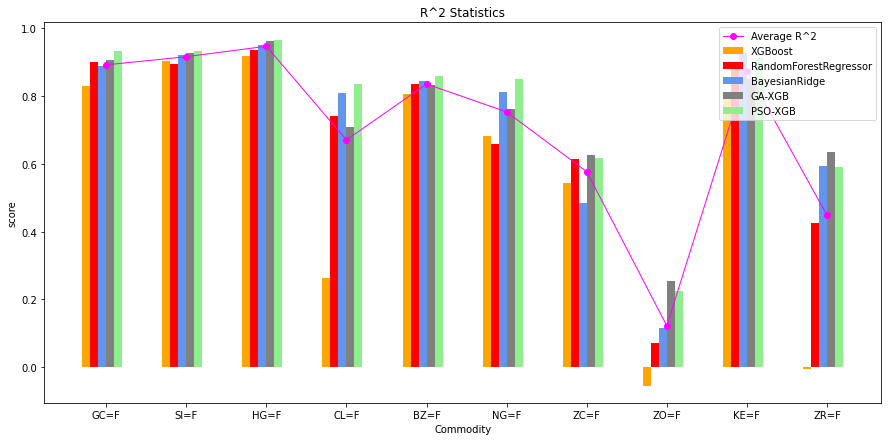

<ipython-input-57-684132151011>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stks)


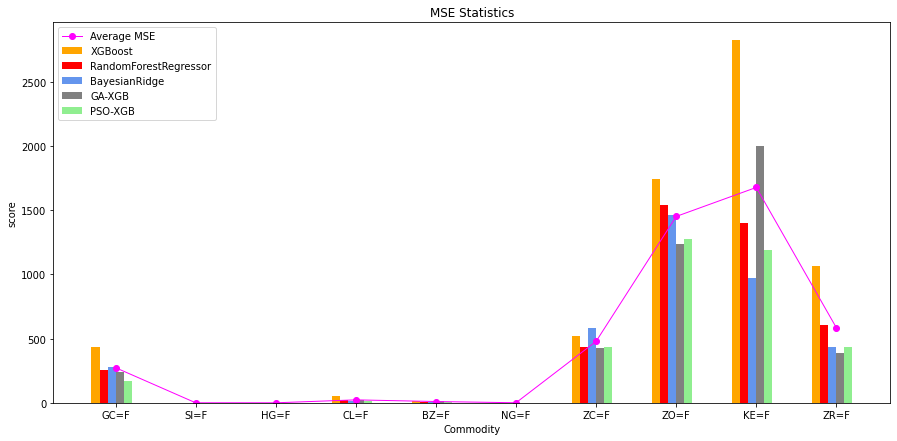

<ipython-input-57-684132151011>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stks)


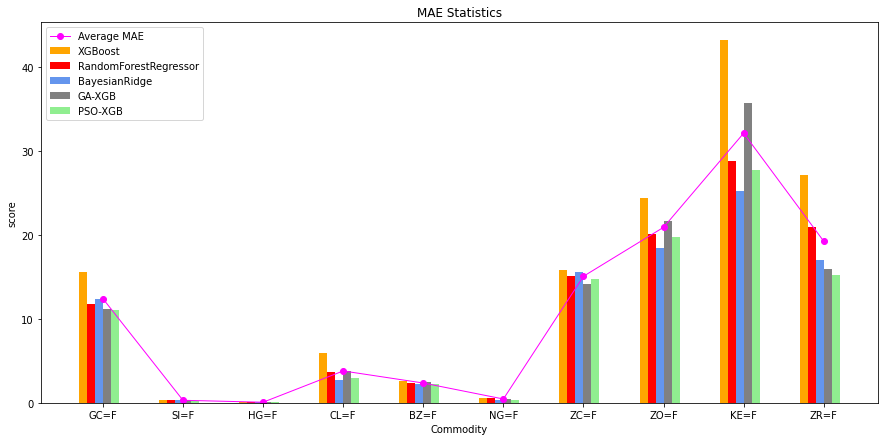

<ipython-input-57-684132151011>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stks)


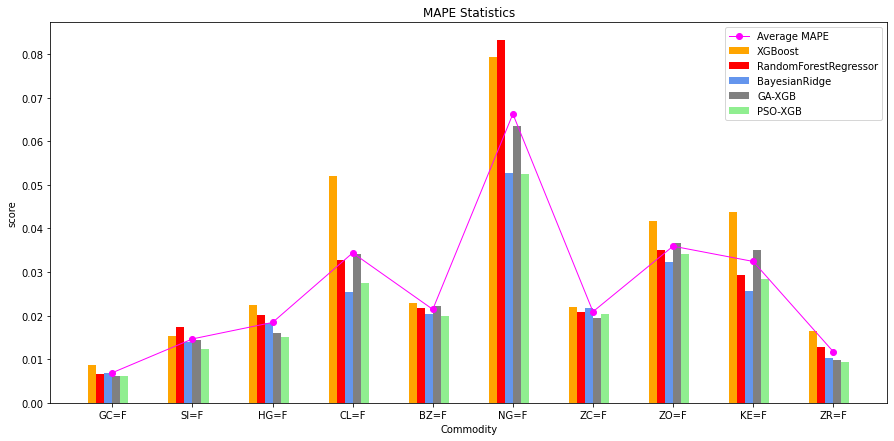

<ipython-input-57-684132151011>:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(stks)


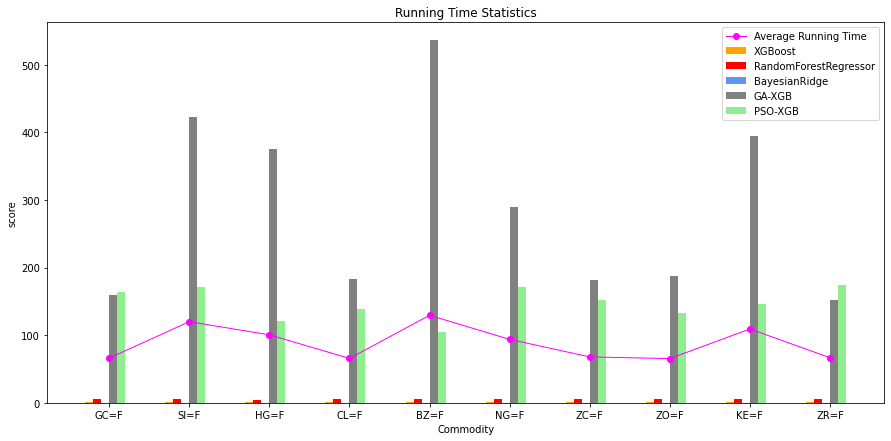

In [57]:
lstm_time = df_pred_lstm['Time'].tolist()
df_pred_lstm['Running Time'] = lstm_time
lstmnm=[]
for i in range(len(df_pred_lstm['Running Time'])):
    lstmnm.append('LSTM')
df_pred_lstm['Model'] = lstmnm
ganm = []
for i in range(len(df_ga_best['R^2'])):
    ganm.append('GA-XGB')
df_ga_best['Model'] = ganm
psonm = []
for i in range(len(df_pso_best['R^2'])):
    psonm.append('PSO-XGB')
df_pso_best['Model'] = psonm
rsts = [df_pred_results, df_ga_best, df_pso_best]
mdll = []
stks = []
r2_scores = []
mse_scores = []
mae_scores = []
mape_scores = []
runing_tim = []
for i in range(len(rsts)):
    for mdl in rsts[i]['Model']:
        mdll.append(mdl)
    for stk in rsts[i]['Commodity']:
        stks.append(stk)
    for r in rsts[i]['R^2']:
        r2_scores.append(r)
    for se in rsts[i]['MSE']:
        mse_scores.append(se)
    for ae in rsts[i]['MAE']:
        mae_scores.append(ae)
    for ape in rsts[i]['MAPE']:
        mape_scores.append(ape)
    for tim in rsts[i]['Running Time']:
        runing_tim.append(tim)
df_pfm = pd.DataFrame({'Model':mdll,
                       'Commodity':stks,
                       'R^2':r2_scores,
                       'MSE':mse_scores,
                       'MAE':mae_scores,
                       'MAPE':mape_scores,
                       'Running Time':runing_tim
                      })   

market = 'Commodity'
metrics = ['R^2', 'MSE', 'MAE', 'MAPE','Running Time']
df = df_pfm

modls = ['XGBoost','RandomForestRegressor','BayesianRidge','GA-XGB','PSO-XGB']

stks = ['GC=F', 'SI=F', 'HG=F', 'CL=F', 'BZ=F', 'NG=F', 'ZC=F', 'ZO=F', 'KE=F', 'ZR=F']
for metric in metrics:
    
    stk_avg = []
    perfm_scores = []

    for stk in stks:
        df_by_stk = df[df[market]==stk]
        stk_avg.append(df_by_stk[metric].mean())

    for md in modls:
        df_by_md = df[df['Model']==md]
        cur_scr = []
        for stk in stks:
            df_by_stk = df_by_md[df_by_md[market]==stk]
            cur_scr.append(df_by_stk[metric].tolist()[0])
        perfm_scores.append(cur_scr)

    x = np.arange(len(stks))
    width = 0.1

    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(stks, stk_avg,'o-', color='fuchsia', linewidth=1,  label='Average '+str(metric))

    rec1 = ax.bar(x - 5*(width/2), perfm_scores[0], width, label=modls[0], color='orange')
    rec2 = ax.bar(x - 3*(width/2), perfm_scores[1], width, label=modls[1], color='red')
    rec3 = ax.bar(x - width/2, perfm_scores[2], width, label=modls[2], color='cornflowerblue')
    rec4 = ax.bar(x + width/2, perfm_scores[3], width, label=modls[3], color='grey')
    rec5 = ax.bar(x + 3*(width/2), perfm_scores[4], width, label=modls[4], color='lightgreen')
    #rec6 = ax.bar(x + 5*(width/2), perfm_scores[5], width, label=modls[5], color='lightgreen')


    ax.set_xticklabels(stks)
    #ax.bar_label(rec1, padding=3)
    #ax.bar_label(rec2, padding=3)
    #ax.bar_label(rec3, padding=3)
    #ax.bar_label(rec4, padding=3)
    #ax.bar_label(rec5, padding=3)
    #ax.bar_label(rec6, padding=3)

    ax.legend()
    #fig.tight_layout(stks)
    plt.xlabel(market)
    plt.ylabel('score')
    plt.title(str(metric)+' Statistics')
    plt.show()

In [55]:
df_pfm.to_excel('ALL_Commodity_Results.xlsx')